# l-1 trend filtering (18 pts)

В своей знаменитой статье [l-1 trend filtering](https://web.stanford.edu/~boyd/papers/l1_trend_filter.html) Стивен Бойд и его коллеги предложили подход к выявлению тренда в финансовых временных рядах с помощью выпуклой оптимизации. В частности, вместо построения стохастической модели временного ряда, они предложили отталкиваться от задачи - построить кусочно-линейную линию тренда, наилучшим образом аппроксимирующую данный временной ряд.

Это привело к задачи оптимизации следующего вида:

**TrendFilter problem**
$$
\min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1
$$
где $y \in R^T$ - временной ряд фактических цен акции (с момента времени $t = 1$ до момента времени $T$), матрица $D \in R^{(T-2) \times T}$ является трехдиагональной: $[Dx]_i = x_i - 2 \cdot x_{i+1} + x_{i+2} \quad$ ($1\leq i \leq T-2$).

Первый член в целевой функции отвечает за близость решения к фактическим данным, а второй форсирует решение  быть кусочно-линейной функцией с минимальным числом "изломов". 

Задание:
1. (1 pts.) Скачайте тестовые данные: данные о цене закрытия акций российских финансовых компаний (например, с finam.ru). Это ваши тестовые данные. 
2. (3 pts.) Выпишите двойственную задачу для задачи Trend Filter.
3. (3 pts.) Численно решите задачу Trend Filter используя одну из версий проксимального градиентного спуска.
4. (5 pts.) Выпишите сглаженную версию задачи Trend Filter и найдите ее решение используя метод быстрого градиентного спуска (версия из лекции про сглаживание).
5. (4 pts.) Выпишите схему ADMM для решения задачи Trend Filter, реализуйте ее и найдите численное решение задачи. 
6. (2 pts.) Сравните полученные результаты на тестовых данных.

1. Построим двойственную задачу. Для этого сделаем замену $Dx = z$. Получим следующую задачу оптимизации
$$\begin{cases}
   \min\limits_{x,z}\frac{1}{2}||y-x||^2_2 + \lambda ||z||_1\\
   subject~to~z = Dx
 \end{cases}$$
 
 Построим функцию Лагранжа $L(x,z,\nu) = \frac{1}{2}||y-x||^2_2 + \lambda ||z||_1 + \nu^T(Dx-z)$. Тогда $g(\nu) = \inf\limits_{x,z} L(x,z,\nu)$. Получившаяся задача сепарабельна по переменным. Запишем условие оптимальности по $x:$
 $$x - y + D^T\nu = 0 \Rightarrow x = y - D^T\nu.$$
 Запишем условие оптимальности по $z_i:$
 $$\lambda\begin{cases}1, \qquad z_i > 0\\-1, \qquad z_i < 0\\ [-1,1], \qquad z_i = 0\end{cases} - \nu_i.$$
 Отсюда получаем, что должно выполняться $-\lambda \leq \nu_i \leq \lambda$. 
 
 Таким образом, мы находим функцию $g(\nu):$
 
 $$g(\nu) = \begin{cases} -\frac{1}{2}\nu^TDD^T\nu+y^TD^T\nu, \qquad if~-\lambda\textbf{1} \leq \nu \leq\lambda\textbf{1}\\
 -\infty, \qquad otherwise\end{cases}$$
 
 Тогда двойственная задача имеет вид
 
 $$\begin{cases} \frac{1}{2}\nu^TDD^T\nu-y^TD^T\nu \rightarrow \min\\
 subject~to~-\lambda\textbf{1} \leq \nu \leq\lambda\textbf{1}\end{cases}$$

2. 

In [244]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [245]:
df = pd.read_csv("data1.csv", sep = ";", encoding="utf-8", header=None) #считывание данных
df.head()
y = np.array(df.iloc[1:, 7]) #берем столбец цен акций в момент закрытия
for i in range(0, len(y)):
    y[i] = float(y[i])
n = len(y) #длина вектора - это значение T

In [246]:
D = np.zeros((n-2, n))
for i in range(0, n - 2):
    D[i][i] = 1
    D[i][i + 1] = -2
    D[i][i + 2] = 1
A = D.dot(D.T) #матрица DD^T
lambdas, vectors = np.linalg.eig(A) #определяем собственные числа матрицы DD^T

In [247]:
max_l = lambdas.max() #определеяем максимальное собственное число
h = 1/max_l #определяем шаг для градиентного спуска

Далее мы будем решать двойственную задачу, а не прямую. В данном случае это будет проекция градиентного спуска на множество $-\textbf{1}\lambda \leq \nu \leq \textbf{1}\lambda$. В данном случае $g(\nu) =\frac{1}{2}\nu^TDD^T\nu-y^TD^T\nu \Rightarrow \nabla g(\nu) = DD^T\nu - Dy$. Шаг мы уже определили. $\nu_{k+1} = \nu_k - h\nabla g(\nu_k)$. В нашем случае надо также брать проекцию на множество. 


In [248]:
lmb = 1 #зададим лямбда = 1
def grad_step(nu_k): #один шаг градиентного спуска
    nu_k = nu_k -  h*A.dot(nu_k) + h*D.dot(y)
    for i in range(0, len(nu_k)):
        if nu_k[i] > lmb:
            nu_k[i] = lmb
        elif nu_k[i] < -lmb:
            nu_k[i] = -lmb
    return nu_k

def g(nu): #функция вычисления g(nu)
    a = A.dot(nu)
    b = nu.T
    c = 1.0/2*b.dot(a)
    d = D.T.dot(nu)
    e = y.T
    f = e.dot(d)
    return c - f

In [249]:
errors_prox = []
nu_old = np.zeros(n - 2)# начальная инициализация
nu_new = np.zeros(n - 2)
nu_new[0] = 1
g_old = g(nu_old)
g_new = g(nu_new)
eps = math.fabs(g_old - g_new)  #здесь хранится норма разности градиента двух соседних итераций
print(eps)

while eps > 10**(-4): #критерий останова - разность g на двух соседних итерациях меньше e
    nu_old = nu_new
    nu_new = grad_step(nu_new)
    g_old = g_new
    g_new = g(nu_new)
    eps = math.fabs(g_old - g_new)
    errors_prox.append(eps)
    print(eps)

2.4799999999999898
25.557889855574764
7.153365505109125
4.326664646606819
3.126102168035956
2.470977916166305
2.0677948923071128
1.7981989635365139
1.6059104656392975
1.4615828089610616
1.3488294459852952
1.257950801470706
1.182896688605645
1.062967646165724
0.8902179517337458
0.8067781111634744
0.7607775591234045
0.7007471142569486
0.6502735850727959
0.6132933113627743
0.5874477526163986
0.5414079670444352
0.5060937485352781
0.48152216150426597
0.4646908754467205
0.4419763786025257
0.42300451509019155
0.40998713939686127
0.3980763005734289
0.3768929750153873
0.3584703970508514
0.34485741129047653
0.33218751535902413
0.32247193625465087
0.30910766122936906
0.2956659051686188
0.2868843876323268
0.2799945436397948
0.27064291175766897
0.25655926270306395
0.2468582606921501
0.23535541315933983
0.2279476523065398
0.22217134544990813
0.2172439542960376
0.2100976157015566
0.20471477132787186
0.20051363907785458
0.1912232308255284
0.18107854297602444
0.17235453163209513
0.16268660233984633
0.1

0.00034120777657165036
0.0003396349094515472
0.00033808508672450444
0.00033655762192097427
0.00033505186335958115
0.0003335671919728611
0.0003321030190619467
0.0003306587840938846
0.00032923394891781754
0.0003278280025682534
0.0003264404531364562
0.0003250708300868155
0.0003237186822389049
0.00032238357677272234
0.0003210650959601935
0.0003197628400641861
0.000318476423217362
0.00031720547410429845
0.000315949635350421
0.0003147085612908995
0.0003134819199033245
0.0003122693888997219
0.0003110706587676759
0.00030988542989973666
0.00030871341169813604
0.00030755432449325326
0.0003064078969998718
0.00030527386657297484
0.00030415197956301654
0.0003030419891985048
0.0003019436569076106
0.0003008567526023853
0.0002997810502733955
0.0002987163333045828
0.00029766239063633293
0.00029661901720601236
0.00029558601325163636
0.0002945631865998166
0.0002935503479761792
0.0002925473163912784
0.00029155391206359127
0.00029056996413601155
0.00028959530368410924
0.00028862976733989854
0.0002876731957

In [250]:
x0_prox = y - D.T.dot(nu_old) #вычисляем по оптимальному nu оптимальный x
x_opt_prox = y - D.T.dot(nu_new)
er = np.linalg.norm(x0_prox - x_opt_prox)
opt_prox = 1.0/2*np.linalg.norm(y-x_opt_prox)**2 + np.linalg.norm(D.dot(x_opt_prox), ord=1)
print (er, opt_prox, x_opt_prox[0:3])

0.0015843149206591907 70.21110585943435 [91.32799999999946 91.78500000000024 92.24200000000057]


Сравним полученное $x$ и $y$, из теории $x$ - это сглаженный $y$.

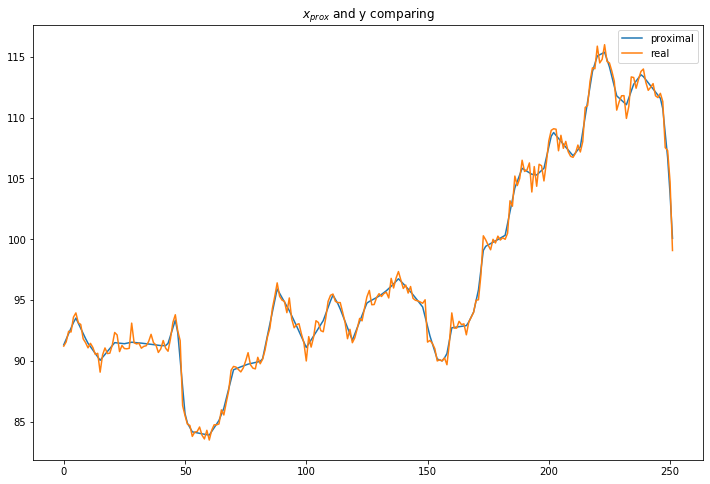

In [251]:
plt.figure(figsize=(12,8))
plt.plot(x_opt_prox, label = 'proximal')
plt.plot(y, label = 'real')
plt.title('$x_{prox}$ and y comparing')
plt.legend()
plt.show()

График, изображающий изменение модуля разности значений функций в двух соседних точках

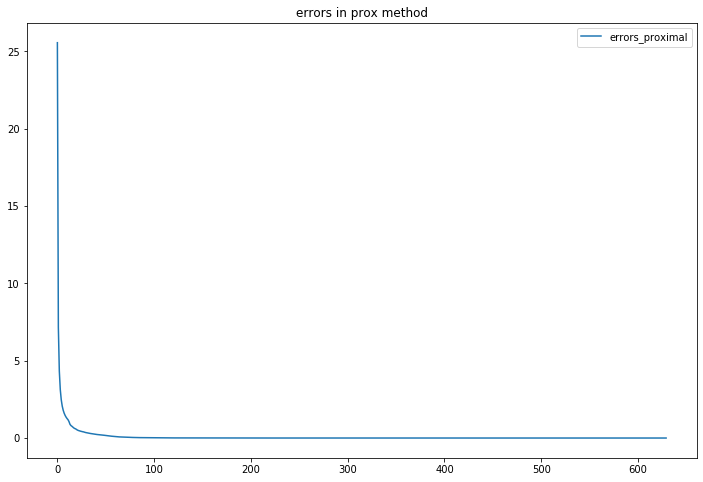

In [252]:
plt.figure(figsize=(12,8))
plt.plot(errors_prox, label = 'errors_proximal')
plt.title('errors in prox method')
plt.legend()
plt.show()

$$------------------------------------------------------------------------------------------------------------------------------$$

2. Сглаженное решение

Пусть $f_{\mu} = \frac{1}{2}||y-x||_2^2 + \lambda||Dx||_1 - \frac{\mu}{2}||u||_2^2$. Эту функцию можно переписать в виде 

$$f_{\mu} = \frac{1}{2}||y-x||_2^2+\max\limits_{-1\leq u_i \leq 1}\left[\sum\limits_{i=1}^n\lambda (u_i(Dx)_i - \frac{\mu}{2}u_i^2\right].$$

Запишем $L_i = \frac{\mu}{2}u_i^2 - \lambda u_i(Dx)_i + a_i(-1-u_i)+b_i(u_i-1)$. Отсюда получаем, что $L_i' = \mu u_i -\lambda (Dx)_i - a_i + b_i = 0$. Отсюда можем выразить $u_i$:

$$u_i = \frac{a_i-b_i+\lambda(Dx)_i}{\mu},$$

при условии, что $a_i(u_i+1) = 0, b_i(u_i-1) = 0$. Также у нас есть ограничение, что $-1\leq u_i \leq 1$. Тогда получаем, что если $-1<u_i <1$, то $a_i=b_i=0$ и $u_i=\frac{\lambda(Dx)_i}{\mu}$, если при этом $ -\mu < \lambda(Dx)_i < \mu$. Если же $-\mu \geq \lambda(Dx)_i$, то $u_i = -1$ и если $\mu \leq \lambda(Dx)_i$, то $u_i = 1$. Таким образом, получаем, что

$$u_i = \begin{cases}-1, \qquad \lambda(Dx)_i \leq -\mu\\
1, \qquad \lambda(Dx)_i  \geq \mu\\
\frac{\lambda(Dx)_i}{\mu}, \qquad -\mu < \lambda(Dx)_i <\mu\end{cases}.\qquad\qquad\qquad(1)$$


Таким образом, при любом $x$ мы можем найти оптимальное $u_{opt}$, по которому восстанавливаем $f_{\mu}$. При этом получаем, что $$f_{\mu} = \frac{1}{2}||y-x||_2^2 + \lambda<u_{opt}, Dx> - \frac{\mu||u_{opt}||_2^2}{2}.$$

Тогда градиент равен

$$\nabla f_{\mu}(x) = x - y + \lambda D^Tu_{opt}.$$

Из лекций ШАДа используем теорему, что если $f_{\mu}(x) = \max\limits_u\left[x^TAu - \varphi(u)-\mu d_2(u)\right]$, то функция имеет липшецев градиент с константой $$L_{\mu} = \frac{1}{\mu \sigma_2}||A||_{1,2}^2,$$ где $d_2(u) \geq \frac{\sigma_2}{2}||u||_2^2$. 

В нашем случае $\sigma_2 = 1$, $||\lambda D||^2_{1,2} = \max{\lambda(DD^T)} \Rightarrow L_{\mu} = \frac{\lambda}{\mu}\max{\lambda(DD^T)} + 1$

(единица добавляется от квадрата второй нормы разности).




Шаги быстрого градиентного спуска:
$$1. Compute f_{\mu}(x_k)~and~\nabla f_{\mu}(x_k).$$

В нашем случае $f_{\mu}(x_k) = \frac{1}{2}||y-x_k||_2^2 + \lambda<u_{opt}, Dx_k> - \frac{\mu||u_{opt}||_2^2}{2}, \nabla f_{\mu}(x_k) = x_k - y + \lambda D^Tu_{opt}.$

$$2. Find~z_k = T_Q(x_k) = argmin_{z}\left[\nabla^T f_{\mu}(x_k)(z-x_k)+\frac{L}{2}||z-x_k||_2^2\right].$$

В нашем случае надо найти $argmin_{z}\left[(x_k - y + \lambda D^Tu_{opt})^T(z-x_k)+\frac{2}{\mu}||z-x_k||_2^2\right]$. Приравняем градиент выражение нулю, откуда найдем $z$:

$$x_k - y + \lambda D^Tu_{opt} + L(z-x_k) = 0 \Rightarrow z_k = -\frac{1}{L}(x_k-y+\lambda D^Tu_{opt}) + x_k$$

$$3. Find~r_k = argmin_r\left[\frac{L}{\sigma_2}d(r) +  \sum\limits_{i=0}^k\alpha_i\left(f(x_i) + \nabla^Tf(x_i)(r-x_i)\right)\right].$$

В нашем случае это будет 

$$r_k = argmin_r \left[\frac{L}{2}||r||_2^2 + \sum\limits_{i=0}^k\frac{i+1}{2}(f(x_i) + \nabla^Tf(x_i)(r-x_i))\right].$$

Приравняем градиент по $r$ к нулю и найдем оптимальное $r$:

$$Lr + \sum\limits_{i=0}^k \frac{i+1}{2}\nabla f(x_i) = 0 \Rightarrow r_k = - \frac{1}{L}\sum\limits_{i=0}^k \frac{i+1}{2}\nabla f(x_i).$$

$$4. Set~x_{k+1} = \frac{2}{k+3} r_k + \frac{k+1}{k+3}z_k.$$

In [217]:
def opt_u(x_k):#функция, вычисляющая u_opt
    a = D.dot(x_k)
    b = np.zeros(n - 2)
    for i in range(n-2):
        if (lmb*a[i] < mu and lmb*a[i] > -mu):
            b[i] = lmb*a[i]/mu
        elif (lmb*a[i] >= mu):
            b[i] = 1
        else:
            b[i] = -1
    return b

def f_mu(x_k, u): #функция вычисления f_mu
    a_k = D.dot(x_k)
    return (np.linalg.norm(x_k - y))**2/2.0 + lmb * (u.T.dot(a_k)) - mu/2.0*np.linalg.norm(u)**2

def grad_f(x_k, u): #функция вычисления gradient(f)
    return x_k - y + lmb*D.T.dot(u)

def opt_z(x_k, u): #функция, вычисляющая z_k
    return -1.0/L*(grad_f(x_k, u))+x_k

def opt_r(k, x_k, u): #функция, вычисляющая r_k
    sum = 0
    for i in range(k + 1):
        sum += (i+1)/2.0*(mas_grad_f[i])
    return -1.0/L*sum

def next_x(k, r_k, z_k):
    return 2.0/(k + 3)*r_k+float((k+1))/(k+3)*z_k

In [218]:
mas_f = [] # массив f(x_i)
mas_grad_f = [] #массив gradient(f(x_i))
x0_smooth = np.zeros(n) #начальные точки
#x1_smooth = np.ones(n)
mu = 0.01
#u0_smooth = opt_u(x0_smooth)
#u1_smooth = opt_u(x1_smooth)
lmb = 1
L = lmb*max(np.linalg.eigvals(D.dot(D.transpose())))/mu + 1

In [219]:
mas_f.append(f_mu(x0_smooth, u0_smooth))
mas_f.append(f_mu(x1_smooth, u1_smooth))
mas_grad_f.append(grad_f(x0_smooth, u0_smooth))
mas_grad_f.append(grad_f(x1_smooth, u1_smooth))

In [223]:
errors_smooth = [] #массив, в котором будем хранить невязку
mas_f = []# массив, в котором будем хранить значения функций
mas_grad_f = [] #массив gradient(f(x_i))
x_smooth = np.zeros(n)#инициализация
z_opt = np.zeros(n)
r_opt = np.zeros(n)
k = 0
u_smooth = opt_u(x_smooth)
mas_f.append(f_mu(x_smooth, u_smooth))
mas_grad_f.append(grad_f(x_smooth, u_smooth))
er = 1
while er > 0.001:
    gradient = mas_grad_f[k]
    z_opt = x_smooth - gradient/L
    r_opt = r_opt - float((k+1))*gradient/(2*L)
    x_smooth = 2*r_opt/(i+3) + (i+1)*z_opt/(i+3)
    u_smooth = opt_u(x_smooth)
    k+=1
    mas_f.append(f_mu(x_smooth, u_smooth))
    mas_grad_f.append(grad_f(x_smooth, u_smooth))
    er = abs(mas_f[k] - mas_f[k-1])
    errors_smooth.append(er)
    print (er)
    print (x_smooth[0], x_smooth[1])

1482.979498459259
0.056755222981817316 0.056972985841317825
1481.156803838443
0.11345657812645715 0.11398874848232132
1485.2413599982392
0.17034956308722643 0.1712016575234516
1495.1493694237433
0.22765961276467753 0.22882646217021319
1510.8072760475334
0.28560710839868486 0.2870867433745044
1532.142580561107
0.34441014677941056 0.3462050750236009
1559.0830245518591
0.40428493013167854 0.4064014324108071
1591.556253502611
0.46544574376585984 0.46789309509456684
1629.4895792240277
0.5281048836398314 0.5308947847732405
1672.809779273346
0.5924725969197697 0.5956188009867805
1721.442915233085
0.6587570409901169 0.6622751186174478
1775.3141682103742
0.7271642561942098 0.7310714512488735
1834.3477796830703
0.7978981472454927 0.8022132899349576
1898.466795718763
0.871160469610106 0.8759039252475942
1967.592659657821
0.9471508184387778 0.9523444580013201
2041.6454755510204
1.0260666185311176 1.0317338021294156
2120.5437300018966
1.1081031144006845 1.114268681900229
2204.2041219291277
1.193453

3249.3171588738587
79.48768578684083 79.89460855477579
2994.2650788648025
80.40921417390746 80.8206536442023
2741.052741273277
81.32705201950205 81.74298813315495
2489.9776582649374
82.24090278271211 82.6613144058139
2241.3352361797697
83.15046947077805 83.57533437580979
1995.4182808258847
84.0554547962761 84.48474963345645
1752.5165333994
84.95556133522902 85.38926159516531
1512.916131380859
85.85049168589082 86.28857165505339
1276.899198784265
86.73994862798584 87.18238133873645
1044.7432769401148
87.62363528222248 88.07039245927837
816.7209274687716
88.50125526994299 88.95230727524508
593.0991489635668
89.37251287281443 89.82782865078828
374.1389943432649
90.23711319250876 90.69666021766216
160.0950570282754
91.09476231036061 91.55850653905325
48.78498271928568
91.94516744703014 92.413073275084
252.26080943341285
92.78803712223123 93.26006734983176
450.0999176666095
93.6230813146133 94.09919711968949
642.0780481819003
94.45001162190647 94.9301725428815
827.9796139174098
95.268541421

745.2096905898502
85.78512311314854 86.217243384827
799.8989325631837
85.30115230384475 85.73091628850833
850.489409019634
84.8259660963943 85.25341810489212
896.8891419424535
84.35987176672276 84.78505758944421
939.0193251747232
83.90316926352554 84.32613613342252
976.8144875453199
83.45615096955925 83.87694752449839
1010.222615476714
83.0191014679344 83.4377777123632
1039.2052346606342
82.59229731366199 83.00890457954718
1063.7374505311454
82.17600681069979 82.59059771767619
1083.8079472695426
81.77048979473713 82.18311820939199
1099.4189455560172
81.37599742194831 81.7867184161594
1110.5861189336047
80.9927719639366 81.40164177218462
1117.338468993661
80.62104660908244 81.02812258466555
1119.7181599896794
80.2610452705002 80.6663858405949
1117.7803132029694
79.91298240080133 80.31664702033284
1111.5927616697954
79.57706281385371 79.97911191816405
1101.2357660924463
79.25348151372165 79.65397647004896
1086.8016927864628
78.9424235309652 79.3414265887751
1068.3946546746483
78.64406376

418.1252301667737
97.83322398720142 98.32577988446295
414.5490648580553
97.60637998364147 98.09780314060185
409.32604798826105
97.37404960399437 97.86431382214218
402.50115070930224
97.1365395007402 97.62562010374656
394.12627244063515
96.89416100451592 97.38203486024204
384.25993245725203
96.64722975218113 97.13387529283851
372.966933194381
96.3960653098436 96.88146255028515
360.3179970168503
96.14099079128447 96.6251213454077
346.389378175561
95.88233247223053 96.36517956747592
331.2624518783
95.62041940092834 96.10196789085771
315.0232825343769
95.3555830054808 95.83581938042319
297.7621732809057
95.08815669841326 95.56706909416647
279.5731990017755
94.81847547894104 95.2960536835192
260.5537251697217
94.54687553341492 95.02311099183419
240.80391489694193
94.27369383442542 94.74857965152157
220.42622658662185
93.99926773904988 94.47279868032298
199.52490459350508
93.723934586729 94.1961070772135
178.20546534021048
93.44803129726185 93.91884341842147
156.5741813746199
93.171893969409

94.81205303169418
94.16520330080625 94.64000259064679
93.83547027542932
94.04714005035083 94.5213498648498
92.35057305033502
93.92572088457048 94.39932519226542
90.35352025666248
93.8011628004627 94.27414664708964
87.88782129875221
93.67368659001562 94.14603611635174
84.94393458630418
93.54351647533456 94.0152189332349
81.57403345417936
93.41087973916609 93.88192350577366
77.78855624331084
93.27600635141383 93.74638094152381
73.63867452622242
93.13912859224652 93.60882466881012
69.12364844760833
93.0004806724055 93.46949005516046
64.30509581212249
92.86029835132344 93.32861402354183
59.201381583762725
92.71881855366978 93.18643466701702
53.869877167430786
92.57627898494194 93.04319086244347
48.31483259232445
92.43291774672291 92.89912188383822
42.60207633399227
92.28897295222671 92.75446701603394
36.75722621107269
92.14468234275365 92.60946516925019
30.83578395471065
92.00028290567555 92.46435449520392
24.847646829459407
91.85601049456952 92.31937200538034
18.864507938580743
91.7120994

4.503364535599218
91.07991618173384 91.53962467055709
6.06200648039345
91.00449706259326 91.4638366085094
7.598766884188549
90.9303726613827 91.38934992777976
8.962024479201787
90.8576831770302 91.31630551004744
10.1975636418087
90.78656505973319 91.24484046928423
11.379847035870014
90.71715075467384 91.17508789422502
12.39028271110898
90.64956845473372 91.10717659988657
13.259928994505799
90.5839418626872 91.0412308886086
14.048322643393902
90.52038996332855 90.97737032108226
14.654967875579672
90.45902680597166 90.91570949779947
15.119821542265186
90.39996129773519 90.85635785134521
15.445915644994358
90.34329700800815 90.79941944992183
15.569307758696453
90.28913198446281 90.74499281248322
15.680133804059295
90.23755858096312 90.69317073581763
15.53646767704987
90.1886632976862 90.64404013391135
15.29756206946226
90.14252663375585 90.59768188987866
14.898507190913051
90.09922295265368 90.5541707207411
14.383090994925283
90.05882036065492 90.51357505528715
13.695775298807973
90.02138

1.6349638266770796
90.51626453793993 90.97691794215312
2.048447323157774
90.52615586202128 90.98350822546533
2.484728719054573
90.53643188271337 90.99694296377733
2.7653719009155395
90.55039230859232 91.00692767351391
3.1450306155169585
90.56435567314598 91.02427672363498
3.5709515491188597
90.58204695714298 91.03717685630103
3.706657927025475
90.59902751796336 91.0586907342351
4.019266402427633
90.61990548865637 91.0745053984259
4.242391366647979
90.63956496234411 91.09972302831184
4.306172624197586
90.66315300129095 91.11883444674248
4.460015263197647
90.68561669470147 91.14677239847688
4.650085280672087
90.71173858545576 91.16939525702723
4.5287849790842785
90.73726872119661 91.19922247152218
4.578463835140113
90.76602876521518 91.22479184551763
4.535182934211164
90.79446189500717 91.25644280885253
4.424479915482252
90.82581695647552 91.28394591361791
4.24332001855575
90.85641340024398 91.31790680456523
4.107132366323853
90.88991497298193 91.34655169660734
4.005998461286012
90.92176

0.7105997022400601
91.4827750201793 91.94257184466
0.8736698936379099
91.50282647664399 91.9586570352376
1.0654897256702895
91.5202363740058 91.97862614470031
0.9845794812287352
91.538982731388 91.98884207019474
1.0033006103325164
91.55283365465118 92.00951882760963
0.9334427561486791
91.56569360584443 92.02551001016192
1.031145026410698
91.57639387264294 92.04436469713906
1.0540508655334264
91.58824563804427 92.06024839743414
1.0072989204642084
91.60204864458456 92.06897460848612
0.9768831403608971
91.61346556768115 92.08182125347888
0.9398410253875653
91.624606354438 92.09406251024475
0.9012160323102592
91.6369188902799 92.10009368840808
0.8234121534184169
91.64552198456688 92.11270841123313
0.6707425655808947
91.65489451060823 92.12127151757792
0.7134141186354555
91.66501659643832 92.12490279803801
0.6035558090147362
91.67262790756975 92.13067962160699
0.521591862519287
91.67891127268109 92.13266365985686
0.45555822936043455
91.68035008687588 92.14376601406451
0.2817162134150948
91.

In [224]:
opt_smooth = 1.0/2*np.linalg.norm(y-x_smooth)**2 + np.linalg.norm(D.dot(x_smooth), ord=1)
print (opt_smooth, x_smooth[0:3])

71.22671368568572 [91.32067745819323 91.78657573088539 92.24920890187218]


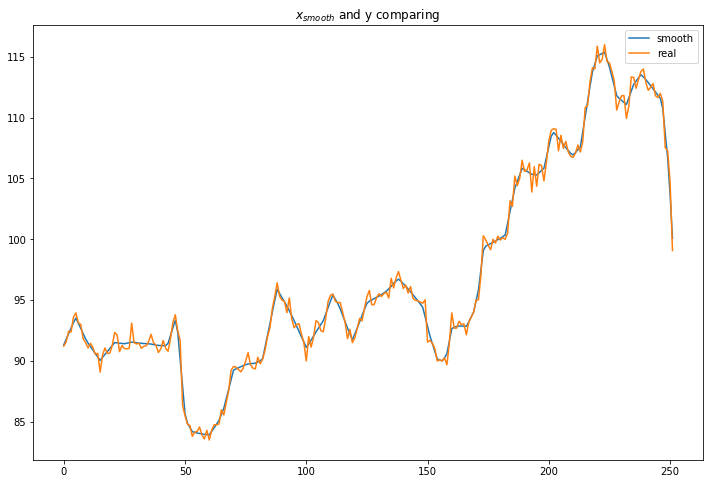

In [225]:
plt.figure(figsize=(12,8))
plt.plot(x_smooth, label = 'smooth')
plt.plot(y, label = 'real')
plt.title('$x_{smooth}$ and y comparing')
plt.legend()
plt.show()

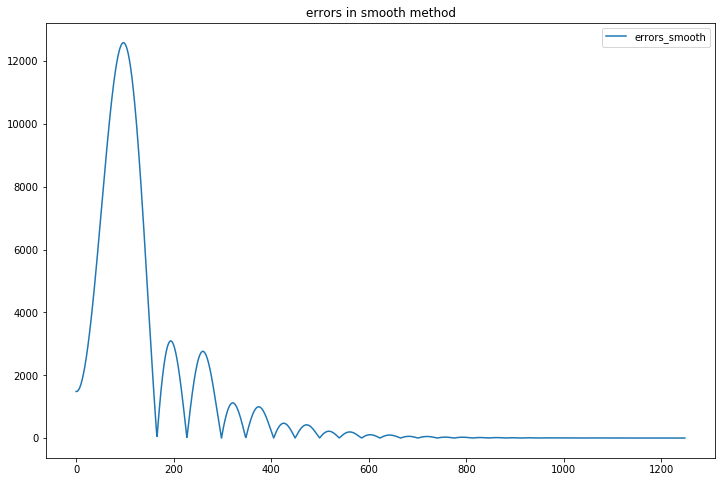

In [226]:
plt.figure(figsize=(12,8))
plt.plot(errors_smooth, label = 'errors_smooth')
plt.title('errors in smooth method')
plt.legend()
plt.show()

$$------------------------------------------------------------------------------------------------------------------------------$$

3. Выпишем схему для метода ADMM. От исходной задачи перейдем к эквивалентной задаче $$\begin{cases}\min\limits_{x,z}~\frac{1}{2}||y-x||^2_2 + \lambda||z||_1\\
subject~to~z = Dx\end{cases}$$
Построим модификацию функции Лагранжа $$L_r = \frac{1}{2}||y-x||_2^2+\lambda ||z||_1 + \frac{1}{2r}||\mu+r(Dx-z)||_2^2-\frac{||\mu||_2^2}{2r}.$$
Общая схема метода ADMM:
$$\begin{cases}x^{k+1} = argmin~L_r(x,z^k,\mu^k)\\
z^{k+1} = argmin~L_r(x^{k+1}, z, \mu^k)\\
\mu^{k+1} = \mu^k + r(Dx^{k+1} - z^{k+1})\end{cases}$$

Условие оптимальности по $x$:
$$\nabla_xL_r = 0 = x - y + D^T(\mu + r(Dx-z)) \Rightarrow x = (I + rD^TD)^{-1}(y+rD^Tz-D^T\mu)$$
Отсюда получаем, что $$x^{k+1} = (I + rD^TD)^{-1}(y + rD^Tz^k -D^T\mu^k)$$
Условие оптимальности по $z$:
$$\lambda \partial||z||_1 - (\mu + r(Dx - z)) = 0$$
Перейдем к координатной записи
$$\lambda \begin{cases} 1, z_i > 0 \\
-1, z_i < 0 \\
[-1,1], z_i = 0
\end{cases} - \mu_i -r(Dx)_i + rz_i = 0 \Rightarrow z_i = \frac{1}{r}\begin{cases}\mu_i +r(Dx)_i - \lambda, \qquad if~(\mu_i + r(Dx)_i) > \lambda\\
\mu_i +r(Dx)_i + \lambda,\qquad if~(\mu_i + r(Dx)_i) < -\lambda\\
0, \qquad if~(\mu_i + r(Dx)_i) \in [-\lambda, \lambda]\end{cases}$$
Отсюда можем определить формулу преобразования для $z$:
$$z^{k+1}_i = \frac{1}{r}\begin{cases}\mu_i^k +r(Dx^{k+1})_i - \lambda, \qquad if~(\mu_i^k + r(Dx^{k+1})_i) > \lambda\\
\mu_i^k +r(Dx^{k+1})_i + \lambda,\qquad if~(\mu_i^k + r(Dx^{k+1})_i) < -\lambda\\
0, \qquad if~(\mu_i^k + r(Dx^{k+1})_i) \in [-\lambda, \lambda]\end{cases}$$
Для параметра $\mu$ преобразование известно:
$$\mu^{k+1} = \mu^k + r(Dx^{k+1} - z^{k+1}).$$
Далее идет численная реализация данного метода

In [229]:
r=100#задали параметры система
l = 1 

x0_admm = np.zeros(n)#инициализация x
x1_admm = np.ones(n)
#x1 = x_opt
mu0_admm = np.zeros(n - 2) #инициализация mu
mu1_admm = np.ones(n - 2)
z0_admm = np.zeros(n - 2) #инициализация z
z1_admm = np.ones(n - 2)

A = D.T.dot(D) #матрица D^TD
B = np.linalg.inv(r*A + np.eye(n)) #матрица (D^TD + I)^(-1)

In [230]:
def L_r(x, mu, z): #функция для вычисления L_r
    a = 1.0/2*np.linalg.norm(y-x)**2 + l*np.linalg.norm(z, ord=1)
    b = mu + r*(D.dot(x) - z)
    c = 1.0/2/r*np.linalg.norm(b)**2 - 1.0/2/r*np.linalg.norm(mu)**2
    return c

def x_new(mu_old, z_old): #функция преобразования x
    a = y + r*D.T.dot(z_old) - D.T.dot(mu_old)
    return B.dot(a)

def mu_new(x_old, mu_old, z_old): #функция преобразования mu
    return mu_old + r*(D.dot(x_old) - z_old)

def z_new(x_old, mu_old): #функция преобразования z
    a = mu_old + r*(D.dot(x_old))
    ans = np.zeros(n - 2)
    for i in range(0, n - 2):
        if (a[i] > l):
            ans[i] = (a[i] - l)/r
        elif (a[i] < -l):
            ans[i] = (a[i] + l)/r
        else:
            ans[i] = 0
    return ans

In [236]:
a0 = L_r(x0_admm, mu0_admm, z0_admm)
a1 = L_r(x1_admm, mu1_admm, z1_admm)
errors_admm = []
eps1 = math.fabs(a0 - a1)
errors_admm.append(eps1)
#eps = np.linalg.norm(x1-x_opt)
print (eps1)
while eps1 > 10**(-6):
    x0_admm = x1_admm
    x1_admm = x_new(mu1_admm, z1_admm)
    z0_admm = z1_admm
    z1_admm = z_new(x1_admm, mu1_admm)
    mu0_admm = mu1_admm
    mu1_admm = mu_new(x1_admm, mu0_admm, z1_admm)
    a0 = a1
    a1 = L_r(x1_admm, mu1_admm, z1_admm)
    eps1 = math.fabs(a0 - a1)
    errors_admm.append(eps1)
    #eps = np.linalg.norm(x1 - x_opt)
    print (eps1)

7.710510778702329e-05
0.0011707869848248675
0.009996692619642644
0.009960584239546932
0.014429287356416132
0.009046624538690318
0.0007161010383447408
0.0003769713852003198
0.0009205178105315959
0.005650634713412761
0.0006574106553529635
0.0006319571963520065
0.0006182924624895669
0.0012208536968462136
0.00011675290174317787
0.0008778099768655956
3.0859399026139656e-06
0.0024421480140591756
0.0005125665738762164
0.0030768865309387383
5.5669077047793e-05
0.0019524155400025833
0.0024928580395983113
0.0016870502932949671
0.001061478178219999
0.0020945443324908997
0.0004413929215745238
8.994252394112223e-05
0.0011142325063345782
0.002145703767735596
0.00016168398585836297
0.0003758080745565051
0.0004683952568337313
0.0005893832159360457
0.0006033914494419923
0.0002973704478334005
0.00010506361278539433
2.805191834842624e-05
0.0023249198261322546
0.006279661339126719
0.005578759230701835
0.0006107650376350193
0.0005547364301362601
0.00040277985097758595
0.00022043379699077104
7.0206624043667

In [239]:
opt1 = 1.0/2*np.linalg.norm(y-x1_admm)**2 + np.linalg.norm(D.dot(x1_admm), ord=1)
err1 = np.linalg.norm(x1_admm - x_opt_prox)
err2 = np.linalg.norm(x1_admm - x1_smooth)
print (opt1, err1, err2)


70.70366545367446 0.7998171916887252 1528.2511110161145


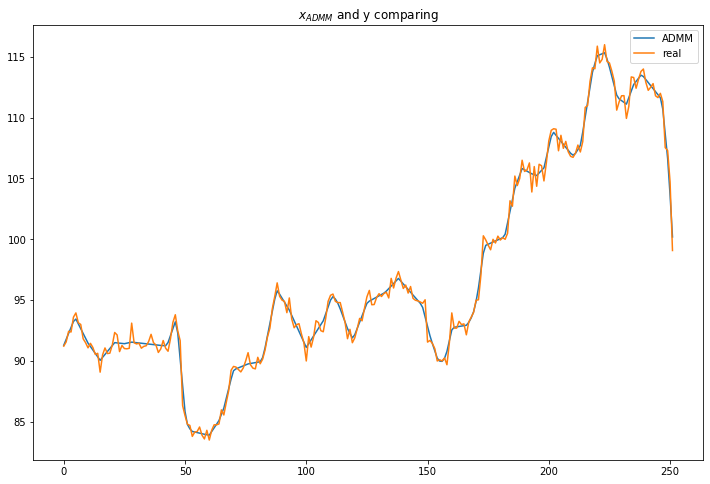

In [240]:
plt.figure(figsize=(12,8))
plt.plot(x1_admm, label = 'ADMM')
plt.plot(y, label = 'real')
plt.title('$x_{ADMM}$ and y comparing')
plt.legend()
plt.show()

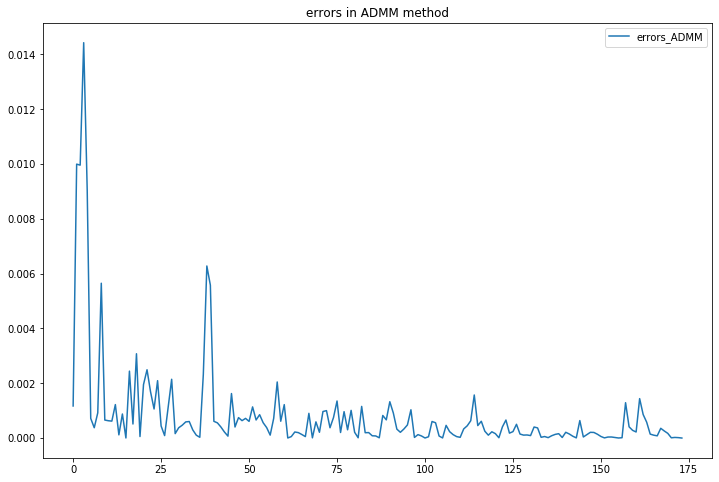

In [242]:
plt.figure(figsize=(12,8))
plt.plot(errors_admm[1:], label = 'errors_ADMM')
plt.title('errors in ADMM method')
plt.legend()
plt.show()

In [235]:
print(np.linalg.norm(x1_admm - y), np.linalg.norm(x_smooth - y), np.linalg.norm(y - x_opt_prox))

9.707394058683239 8.35880376570729 8.391722612622912


# ADMM (13 pts)

Техника сглаживания оказала достаточно большое влияние на развитие методов восстановления тензоров (matrix completion problem является частным случаем). 

Рассмотрим задачу восстановления матрицы $Y$. Мы наблюдаем только небольшой набор элементов матрицы $Y$, множество индексов известных элементов обозначим через $E$. То есть мы знаем $Y_{ij}$ для всех $(i,j) \in E$, и не знаем $Y_{ij}$ для всех $(i,j) \notin E$.

Понятно, что без наличия какой-либо дополнительной информации о матрице $Y$ эта постановка является тривиальной: любая матрица $X$, для которой выполнено $X_{i,j} = Y_{i,j}, \quad (i,j) \in E$ является разумным ответом. Таких матриц бесконечно много. Соответственно задача восстановления матриц обычно рассматривается как частный случай задачи приближения матрицы, а критерий качества (целевая функция) говорит не столько о близости $X$ к $Y$, сколько о полезных свойствах матрицы $X$ (этим свойствам матрица $Y$ может и не обладать).

Одна из самых популярных постановок, с которой Вы наверняка сталкивались, например, строя рекомендательные системы, является задача о поиске наилучшего приближения заданной матрицы матрицей малого ранга:

$$
\begin{align*}
& \min_{X} rk(X) \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$
Как известно, в общем случае эта задача является NP-трудной.

Для того, чтобы обойти это припятствие ранк матрицы аппроксимируется той или иной выпуклой функцией от матрицы $X$.

Опять же стандартным выбором является переход к постановке задачи с использованием 1-й нормы Шаттена (она же trace norm).

$\textbf{RegMC problem}$

$$
\begin{align*}
& \min_{X}\|X \|_* \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$

Здесь $X_* = \sum \sigma_i(X)$. 


1. (1 pts) Сведите задачу RegMC к виду, пригодному для решения алгоритмом ADMM
2. (5 pts) Выпишите аналитическую запись всех шагов вычисления алгоритма ADMM для численного решения задачи, полученной в пункте 1.
3. (2 pts) Реализуйте метод ADMM. 
4. (5 pts) Протестируйте алгоритм из п.3 на тестовых данных. Сравните полученные результаты с результатами алгоритмов из ДЗ4.
От Вас требуется сравнить скорость сходимости методов на тестовых данных. Предложите метод сравнения и обоснуйте свой выбор.





Построим эквивалентную задачу
$$
\begin{cases}
\min_X~ ||X||_* + I_Q(Z)
\\
subject~to~X = Z
\end{cases}
$$

Здесь введена индикаторная функция множества $E$:
$$
I_E(Z) = \begin{cases}
0,if~\forall~(i,j)\in E \rightarrow Z_{i,j} = Y_{i,j}\\
+\infty, ~in~other~cases
\end{cases}
$$

Уже в таком виде задачу можно решать при помощи ADMM. Для этого запишем измененный лагранжиан

$$
L(X, Z, U) = ||X||_* + I_E(Z) + \frac{1}{2r}||U + r(X - Z)||_F^2 - \frac{||U||_F^2}{2r}.
$$

Тогда преобразования запишутся следующим образом

$$
\begin{cases}
&X^{k+1} = argmin_{X}\left(||X||_* + \dfrac{1}{2r}||r(X - Z^{k}) + U^k||_F^2\right)
\\
&Z^{k+1} = \pi_E\left(X^{k+1} + \frac{1}{r}U^k\right)
\\
&U^{k+1} = U^k + r(X^{k+1} - Z^{k+1}).
\end{cases}
$$

Нужно уметь решать задачу $argmin_{X}\left(||X||_* + \frac{1}{2r}||r(X - Z^{k}) + U^k||_F^2\right)$. Для этого используем сингулярное разложение. Заметим, что все сингулярные числа неотрицательны, поэтому вектор, составленный из сингулярных чисел, будет иметь первую норму, равную норме Шаттена исходной матрицы. Используем это, а также тот факт, что фробениусовская норма матрицы в квадрате есть сумма квадратов сингулярных чисел, то есть вторая норма в квадрате вектора, составленного из сингулярных чисел. Введем вектор $s(A)$ - вектор, составленный из сингулярных чисел матрицы $A$. Обозначим $x = s(X), z = s(Z), u = s(U)$, тогда получим задачу уже на вектора:

$$
argmin_{x}(||x||_{1} + \frac{1}{2r}||r(x - z) + u||_2^2)
$$
Здесь мы считаем, что все матрицы имеют одни и те же $W$ и $V$ в сингулярном разложении. Видно, что задача сепарабельная. Получаем для $i$-ой компоненты задачу

$$
argmin_{x_i}(|x_i| + \frac{1}{2r}|r(x_i - z_i) + u_i|^2)
$$

$$
x_i = \begin{cases}
\frac{rz_i - u_i - 1}{r},~if~ \frac{rz_i - u_i}{r} > \frac{1}{r}\\
\frac{rz_i - u_i + 1}{r},~if~ \frac{rz_i - u_i}{r} < \frac{-1}{r}\\
0,~if~ \frac{rz_i - u_i}{r} \in \left[\frac{-1}{r}, \frac{1}{r}\right]
\end{cases}.
$$
На самом деле второй случай можно убрать, так как сингулярное число должно быть неотрицательным.

Найдя новый $x$, можем найти и саму матрицу $X$: $X^{k+1} = W\Sigma V^T$, где $\Sigma_{i,i} = x_i, \Sigma_{i,j} = 0,~if~i \neq j$.

Для нахождения $Z^{k+1}$ нужно взять проекцию на множество. В данном случае это будет выглядеть так:
$$
Z_{i,j}^{k+1} = \begin{cases}Y_{i,j},~ \forall (i,j) \in E\\
(X^{k+1} + \frac{1}{r}U^k)_{i,j}, ~in~other~cases
\end{cases}
$$

In [83]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [122]:
n = 5
m = 8

In [123]:
np.random.seed(0)
Y = 10*np.random.rand(n,m)
E = [[1,2], [2,3], [2,2], [4,5], [0,0]]

In [124]:
def opt_x(Z, U):
    W, S, V = np.linalg.svd(r*Z - U, full_matrices=True)
    x = np.zeros(len(S))
    for i in range(len(S)):
        if (S[i] > 1):
            x[i]=(S[i] - 1)/r
        else:
            x[i] = 0
    P = np.zeros((n,m))
    for i in range(len(S)):
        P[i][i] = x[i]
    #print(P)
    return W.dot(P).dot(V)

def proector(A):
    for pare in E:
        A[pare[0]][pare[1]] = Y[pare[0]][pare[1]]
    return A

def opt_z(X, U):
    Z = X+(1/r)*U
    Z = proector(Z)
    return Z

def L_r(X, U, Z):
    a = np.linalg.norm(X, ord='nuc')
    b = (1/(2*r))*(np.linalg.norm(r*(X-Z) + U))**2
    c = (1/(2*r))*(np.linalg.norm(U))**2
    return a + b - c

In [125]:
np.random.seed(0)
X = np.random.rand(n,m)
Z = np.random.rand(n,m)
U = np.random.rand(n,m)
r = 1000

In [126]:
for i in range(100000):
    W, S, V = np.linalg.svd(X, full_matrices=True)
    X = opt_x(Z, U)
    Z = opt_z(X, U)
    U = U + r*(X - Z)
    print (L_r(X, U, Z))

362871.41612395394
120949.09811206919
31.37691742013387
31.375717187490693
31.37451701777258
31.37331687304154
31.372116753294556
31.370916658528582
31.36971658874058
31.36851654392754
31.36731652408641
31.366116529214164
31.36491655930777
31.36371661436421
31.36251669438045
31.361316799353453
31.360116929280196
31.358917084157635
31.357717263982764
31.35651746875256
31.35531769846397
31.354117953113988
31.352918232699583
31.351718537217735
31.350518866665414
31.34931922103959
31.348119600337252
31.34692000455538
31.34572043369094
31.344520887740906
31.343321366702277
31.342121870572015
31.340922399347104
31.33972295302453
31.33852353160127
31.337324135074294
31.33612476344061
31.33492541669718
31.333726094840976
31.33252679786901
31.33132752577826
31.3301282785657
31.32892905622831
31.327729858763103
31.32653068616703
31.325331538437087
31.324132415570283
31.32293331756359
31.32173424441399
31.32053519611849
31.31933617267406
31.318137174077695
31.316938200326383
31.315739251417142
31

30.835741862046632
30.834552685783223
30.83336353319457
30.832174404277914
30.830985299030502
30.829796217449598
30.82860715953244
30.827418125276292
30.826229114678416
30.825040127736067
30.8238511644465
30.822662224806965
30.82147330881472
30.820284416467054
30.819095547761183
30.81790670269442
30.816717881263994
30.81552908346717
30.814340309301205
30.813151558763405
30.81196283185099
30.810774128561256
30.80958544889145
30.80839679283886
30.807208160400734
30.806019551574376
30.804830966357027
30.803642404745975
30.802453866738485
30.80126535233184
30.8000768615233
30.798888394310154
30.79769995068968
30.796511530659146
30.795323134215856
30.794134761357057
30.79294641208003
30.791758086382096
30.790569784260487
30.78938150571252
30.788193250735482
30.787005019326628
30.785816811483276
30.78462862720268
30.783440466482165
30.782252329319004
30.78106421571047
30.779876125653878
30.778688059146525
30.777500016185677
30.77631199676863
30.775124000892706
30.773936028555173
30.772748079

30.26878917124469
30.26761104341893
30.26643293812538
30.265254855362418
30.264076795128354
30.262898757421613
30.26172074224054
30.26054274958353
30.259364779448937
30.258186831835193
30.257008906740687
30.255831004163824
30.25465312410302
30.253475266556702
30.252297431523303
30.251119619001248
30.249941828989
30.248764061485
30.247586316487727
30.246408593995614
30.245230894007168
30.24405321652086
30.24287556153518
30.241697929048623
30.240520319059723
30.239342731566943
30.23816516656885
30.23698762406397
30.235810104050817
30.234632606527953
30.23345513149394
30.23227767894733
30.231100248886715
30.229922841310646
30.228745456217744
30.227568093606582
30.226390753475773
30.22521343582393
30.224036140649705
30.222858867951693
30.221681617728567
30.220504389978945
30.21932718470153
30.218150001894962
30.216972841557926
30.215795703689118
30.214618588287237
30.21344149535097
30.212264424879066
30.21108737687023
30.20991035132322
30.208733348236773
30.207556367609623
30.2063794094405

29.79397256128466
29.79378114180789
29.79358974857159
29.79339838157195
29.793207040805147
29.793015726267367
29.792824437954778
29.792633175863582
29.792441939989956
29.792250730330082
29.792059546880143
29.791868389636328
29.791677258594827
29.791486153751816
29.791295075103488
29.791104022646046
29.790912996375642
29.790721996288507
29.7905310223808
29.790340074648718
29.79014915308846
29.789958257696195
29.789767388468128
29.789576545400465
29.78938572848937
29.789194937731054
29.789004173121693
29.788813434657488
29.788622722334647
29.788432036149345
29.788241376097794
29.788050742176164
29.78786013438068
29.787669552707523
29.787478997152874
29.787288467712962
29.787097964383978
29.78690748716208
29.786717036043523
29.786526611024478
29.786336212101137
29.786145839269718
29.785955492526405
29.785765171867425
29.78557487728894
29.785384608787194
29.78519436635836
29.785004149998652
29.784813959704262
29.78462379547142
29.784433657296297
29.784243545175123
29.784053459104094
29.783

29.704142894372843
29.70396376238284
29.703784654837236
29.703605571732435
29.703426513064855
29.703247478830914
29.703068469027013
29.702889483649567
29.70271052269499
29.7025315861597
29.702352674040114
29.70217378633264
29.701994923033688
29.701816084139686
29.701637269647037
29.701458479552173
29.701279713851488
29.70110097254143
29.700922255618387
29.700743563078795
29.70056489491908
29.700386251135637
29.700207631724897
29.70002903668328
29.699850466007216
29.69967191969311
29.699493397737385
29.699314900136486
29.699136426886813
29.698957977984797
29.698779553426863
29.698601153209427
29.69842277732892
29.698244425781752
29.698066098564368
29.69788779567319
29.69770951710464
29.697531262855136
29.697353032921136
29.697174827299023
29.696996645985255
29.696818488976255
29.69664035626844
29.696462247858268
29.696284163742142
29.696106103916495
29.695928068377768
29.69575005712239
29.695572070146795
29.695394107447395
29.69521616902065
29.695038254862986
29.694860364970825
29.69468

29.60888113699208
29.608714965301196
29.608548816143163
29.608382689514645
29.60821658541231
29.608050503832814
29.60788444477283
29.60771840822902
29.607552394198034
29.607386402676543
29.60722043366123
29.607054487148748
29.606888563135758
29.60672266161893
29.606556782594936
29.60639092606043
29.606225092012096
29.606059280446594
29.605893491360597
29.605727724750768
29.60556198061378
29.605396258946307
29.605230559745017
29.605064883006573
29.60489922872767
29.604733596904957
29.60456798753509
29.604402400614788
29.604236836140696
29.60407129410948
29.603905774517845
29.60374027736244
29.603574802639955
29.60340935034704
29.603243920480406
29.603078513036703
29.602913128012617
29.60274776540483
29.602582425210006
29.60241710742484
29.602251812046
29.60208653907016
29.601921288494015
29.60175606031425
29.601590854527515
29.601425671130503
29.601260510119918
29.60109537149242
29.600930255244695
29.60076516137342
29.600600089875297
29.600435040746984
29.60027001398518
29.6001050095865

29.523269375791024
29.52311477279491
29.52296019061202
29.522805629239244
29.522651088673477
29.522496568911624
29.52234206995058
29.522187591787247
29.52203313441851
29.521878697841284
29.521724282052457
29.52156988704893
29.52141551282761
29.521261159385396
29.52110682671917
29.520952514825876
29.520798223702375
29.52064395334559
29.52048970375241
29.52033547491976
29.52018126684452
29.52002707952361
29.51987291295392
29.51971876713238
29.519564642055872
29.519410537721306
29.5192564541256
29.519102391265633
29.518948349138356
29.518794327740633
29.518640327069402
29.518486347121563
29.518332387894016
29.518178449383672
29.51802453158745
29.51787063450227
29.51771675812501
29.517562902452596
29.517409067481957
29.51725525320998
29.5171014596336
29.516947686749702
29.51679393455522
29.51664020304706
29.51648649222215
29.516332802077386
29.51617913260968
29.51602548381597
29.515871855693142
29.51571824823816
29.51556466144788
29.51541109531926
29.515257549849196
29.515104025034628
29.5

29.443308614672894
29.44316473346395
29.44302087146572
29.442877028675333
29.44273320508992
29.4425894007066
29.44244561552249
29.442301849534726
29.442158102740432
29.442014375136736
29.44187066672075
29.441726977489612
29.44158330744045
29.441439656570378
29.441296024876536
29.441152412356058
29.441008819006043
29.440865244823662
29.440721689806015
29.440578153950238
29.440434637253475
29.440291139712834
29.440147661325458
29.440004202088478
29.439860761999025
29.439717341054244
29.43957393925125
29.439430556587176
29.43928719305916
29.439143848664333
29.439000523399844
29.438857217262818
29.438713930250383
29.438570662359677
29.43842741358785
29.438284183932026
29.43814097338936
29.437997781956955
29.437854609631962
29.437711456411535
29.437568322292798
29.437425207272895
29.43728211134897
29.43713903451815
29.436995976777595
29.43685293812442
29.4367099185558
29.43656691806883
29.436423936660677
29.436280974328504
29.43613803106942
29.43599510688059
29.43585220175914
29.43570931570

29.364725357892986
29.36459191996655
29.364458499685398
29.364325097046887
29.364191712048367
29.36405834468719
29.36392499496071
29.363791662866284
29.363658348401266
29.363525051563023
29.363391772348905
29.363258510756253
29.363125266782447
29.362992040424846
29.36285883168078
29.362725640547637
29.362592467022758
29.36245931110352
29.36232617278727
29.362193052071355
29.36205994895316
29.36192686343004
29.36179379549934
29.361660745158453
29.361527712404712
29.36139469723549
29.36126169964815
29.361128719640057
29.36099575720857
29.360862812351055
29.36072988506487
29.3605969753474
29.36046408319599
29.36033120860801
29.360198351580827
29.360065512111827
29.359932690198345
29.359799885837756
29.35966709902745
29.35953432976477
29.359401578047102
29.359268843871796
29.359136127236233
29.359003428137786
29.358870746573814
29.358738082541695
29.358605436038808
29.358472807062505
29.358340195610175
29.35820760167917
29.35807502526689
29.357942466370684
29.35780992498794
29.357677401116

29.297035332863874
29.296910804152034
29.296786291750102
29.29666179565564
29.29653731586622
29.296412852379383
29.296288405192687
29.29616397430371
29.296039559709982
29.2959151614091
29.295790779398597
29.29566641367604
29.295542064238997
29.29541773108504
29.29529341421169
29.29516911361656
29.295044829297183
29.29492056125113
29.294796309475963
29.29467207396925
29.29454785472854
29.29442365175142
29.294299465035444
29.294175294578178
29.294051140377196
29.293927002430046
29.293802880734326
29.293678775287567
29.293554686087354
29.293430613131246
29.29330655641684
29.29318251594167
29.293058491703317
29.29293448369936
29.29281049192735
29.29268651638487
29.292562557069495
29.292438613978792
29.292314687110313
29.292190776461663
29.29206688203039
29.291943003814072
29.291819141810283
29.291695296016602
29.291571466430597
29.29144765304984
29.291323855871905
29.29120007489437
29.291076310114807
29.2909525615308
29.29082882913991
29.29070511293973
29.29058141292782
29.29045772910177
2

29.237222871152525
29.237106139971832
29.23698942393575
29.236872723042037
29.236756037288423
29.236639366672637
29.236522711192453
29.236406070845593
29.236289445629815
29.236172835542842
29.23605624058245
29.235939660746364
29.235823096032334
29.2357065464381
29.235590011961417
29.23547349260001
29.23535698835166
29.235240499214083
29.23512402518506
29.2350075662623
29.23489112244358
29.234774693726628
29.234658280109223
29.23454188158908
29.23442549816397
29.23430912983164
29.234192776589826
29.234076438436308
29.233960115368806
29.233843807385096
29.233727514482908
29.233611236660003
29.233494973914148
29.23337872624308
29.233262493644553
29.23314627611633
29.233030073656145
29.23291388626177
29.232797713930946
29.232681556661465
29.232565414451035
29.232449287297445
29.232333175198434
29.23221707815175
29.232100996155186
29.231984929206458
29.23186887730335
29.23175284044361
29.231636818625002
29.231520811845265
29.231404820102192
29.23128884339353
29.23117288171701
29.23105693507

29.18168626741903
29.181576707639834
29.181467161939434
29.181357630315738
29.181248112766674
29.181138609290127
29.18102911988405
29.18091964454634
29.18081018327493
29.180700736067713
29.180591302922625
29.18048188383758
29.180372478810483
29.18026308783928
29.18015371092186
29.180044348056168
29.1799349992401
29.1798256644716
29.179716343748566
29.179607037068937
29.17949774443062
29.179388465831547
29.179279201269637
29.179169950742807
29.179060714248987
29.178951491786094
29.178842283352033
29.178733088944774
29.178623908562205
29.178514742202257
29.17840558986285
29.178296451541932
29.178187327237406
29.17807821694721
29.177969120669243
29.177860038401462
29.177750970141787
29.17764191588813
29.177532875638445
29.177423849390614
29.177314837142614
29.17720583889235
29.17709685463776
29.176987884376754
29.17687892810729
29.176769985827278
29.176661057534634
29.176552143227326
29.176443242903257
29.176334356560364
29.176225484196586
29.17611662580984
29.176007781398074
29.175898950

29.127387987554684
29.12728537090463
29.12718276730991
29.1270801767686
29.1269775992788
29.126875034838584
29.12677248344604
29.126669945099277
29.12656741979634
29.126464907535354
29.12636240831439
29.12625992213152
29.12615744898487
29.126054988872504
29.125952541792508
29.125850107742995
29.12574768672202
29.1256452787277
29.125542883758115
29.125440501811358
29.12533813288552
29.12523577697868
29.125133434088944
29.12503110421442
29.124928787353152
29.12482648350328
29.124724192662875
29.124621914830026
29.124519650002835
29.124417398179407
29.12431515935781
29.124212933536153
29.124110720712537
29.12400852088505
29.12390633405177
29.12380416021082
29.12370199936028
29.123599851498266
29.123497716622854
29.123395594732152
29.123293485824234
29.123191389897233
29.123089306949222
29.12298723697831
29.12288517998259
29.12278313596017
29.122681104909137
29.122579086827603
29.122477081713654
29.122375089565402
29.122273110380938
29.122171144158386
29.12206919089581
29.121967250591332
2

29.070097359019687
29.0700019911913
29.069906635362145
29.069811291530502
29.069715959694616
29.06962063985276
29.06952533200321
29.069430036144215
29.06933475227405
29.069239480390976
29.06914422049325
29.069048972579168
29.06895373664698
29.06885851269495
29.06876330072134
29.068668100724437
29.068572912702503
29.068477736653804
29.068382572576603
29.068287420469176
29.068192280329782
29.06809715215672
29.06800203594824
29.067906931702584
29.067811839418088
29.06771675909297
29.067621690725513
29.067526634314
29.067431589856707
29.067336557351865
29.06724153679779
29.067146528192755
29.067051531535
29.06695654682284
29.066861574054514
29.06676661322831
29.0666716643425
29.06657672739536
29.066481802385173
29.066386889310206
29.06629198816872
29.06619709895901
29.066102221679348
29.06600735632802
29.065912502903277
29.065817661403422
29.065722831826708
29.06562801417143
29.065533208435866
29.065438414618285
29.065343632716974
29.065248862730208
29.065154104656266
29.065059358493418
29

29.01789800586158
29.017809171899525
29.017720348998957
29.01763153715831
29.017542736375994
29.017453946650452
29.017365167980117
29.0172764003634
29.01718764379873
29.017098898284544
29.01701016381925
29.016921440401298
29.01683272802911
29.01674402670111
29.01665533641573
29.016566657171396
29.016477988966535
29.01638933179959
29.01630068566897
29.016212050573117
29.016123426510458
29.016034813479422
29.015946211478465
29.015857620505976
29.015769040560404
29.015680471640202
29.015591913743766
29.015503366869556
29.015414831015992
29.015326306181507
29.015237792364537
29.015149289563524
29.01506079777687
29.014972317003046
29.014883847240473
29.014795388487567
29.014706940742798
29.014618504004567
29.014530078271335
29.01444166354152
29.014353259813568
29.0142648670859
29.014176485356973
29.014088114625217
29.013999754889063
29.013911406146942
29.01382306839731
29.013734741638586
29.013646425869215
29.01355812108765
29.013469827292308
29.01338154448164
29.013293272654078
29.01320501

28.974328222473467
28.974244790199762
28.974161368224742
28.97407795654696
28.973994555164957
28.973911164077293
28.973827783282534
28.973744412779254
28.973661052565983
28.973577702641286
28.97349436300375
28.973411033651885
28.973327714584297
28.97324440579952
28.973161107296132
28.97307781907268
28.972994541127733
28.97291127345984
28.972828016067574
28.972744768949493
28.972661532104162
28.97257830553013
28.972495089225976
28.97241188319025
28.972328687421538
28.972245501918376
28.972162326679335
28.972079161702982
28.97199600698788
28.97191286253259
28.971829728335692
28.97174660439571
28.97166349071126
28.971580387280884
28.971497294103138
28.971414211176594
28.971331138499835
28.971248076071387
28.971165023889863
28.97108198195379
28.97099895026177
28.970915928812335
28.97083291760408
28.970749916635572
28.970666925905363
28.970583945412017
28.97050097515412
28.970418015130242
28.970335065338922
28.970252125778774
28.97016919644834
28.97008627734618
28.97000336847089
28.96992046

28.930580634666413
28.930502579233085
28.930424533352102
28.930346497022132
28.93026847024189
28.930190453010034
28.93011244532528
28.930034447186294
28.929956458591757
28.929878479540378
28.929800510030837
28.92972255006182
28.929644599632024
28.929566658740125
28.929488727384822
28.9294108055648
28.929332893278744
28.929254990525344
28.92917709730331
28.929099213611302
28.92902133944803
28.928943474812172
28.928865619702453
28.92878777411751
28.928709938056063
28.92863211151682
28.928554294498447
28.928476486999642
28.9283986890191
28.928320900555505
28.928243121607576
28.92816535217397
28.92808759225341
28.928009841844563
28.927932100946144
28.92785436955684
28.927776647675334
28.92769893530034
28.927621232430536
28.927543539064626
28.927465855201305
28.92738818083927
28.927310515977194
28.92723286061381
28.92715521474778
28.927077578377816
28.92699995150262
28.926922334120874
28.926844726231284
28.926767127832544
28.926689538923352
28.92661195950239
28.926534389568385
28.9264568291

28.893526357315693
28.89345282054442
28.893379292709408
28.893305773809438
28.893232263843306
28.893158762809794
28.8930852707077
28.893011787535837
28.89293831329298
28.892864847977915
28.89279139158946
28.89271794412638
28.892644505587487
28.89257107597158
28.89249765527744
28.892424243503875
28.892350840649666
28.892277446713614
28.892204061694517
28.892130685591162
28.892057318402365
28.891983960126886
28.89191061076356
28.891837270311168
28.891763938768495
28.89169061613435
28.891617302407536
28.89154399758684
28.89147070167105
28.891397414658986
28.89132413654943
28.89125086734119
28.89117760703305
28.891104355623824
28.8910311131123
28.890957879497282
28.89088465477758
28.890811438951964
28.890738232019256
28.890665033978255
28.89059184482775
28.890518664566542
28.890445493193447
28.89037233070725
28.89029917710676
28.890226032390768
28.890152896558092
28.89007976960751
28.890006651537846
28.889933542347887
28.889860442036447
28.889787350602315
28.889714268044294
28.889641194361

28.857571468149313
28.857502286425667
28.85743311305484
28.857363948035736
28.85729479136726
28.857225643048277
28.857156503077697
28.857087371454398
28.857018248177297
28.85694913324525
28.85688002665717
28.856810928411967
28.85674183850851
28.856672756945684
28.856603683722394
28.856534618837543
28.856465562290012
28.856396514078707
28.856327474202523
28.856258442660327
28.856189419451024
28.85612040457353
28.85605139802673
28.8559823998095
28.85591340992076
28.855844428359383
28.855775455124284
28.85570649021436
28.855637533628485
28.85556858536557
28.8554996454245
28.8554307138042
28.855361790503547
28.85529287552142
28.855223968856734
28.85515507050839
28.855086180475283
28.855017298756295
28.854948425350347
28.854879560256318
28.85481070347313
28.854741854999652
28.8546730148348
28.85460418297747
28.854535359426553
28.854466544180966
28.85439773723957
28.85432893860132
28.85426014826507
28.854191366229742
28.854122592494218
28.854053827057424
28.85398506991825
28.853916321075577


28.823023851750374
28.822958829081642
28.82289381421851
28.82282880715995
28.822763807904963
28.8226988164525
28.822633832801575
28.822568856951158
28.822503888900236
28.82243892864779
28.822373976192804
28.82230903153425
28.82224409467112
28.822179165602414
28.822114244327093
28.822049330844163
28.821984425152586
28.821919527251342
28.821854637139463
28.82178975481588
28.821724880279604
28.821660013529613
28.821595154564896
28.82153030338443
28.82146545998722
28.82140062437224
28.82133579653847
28.8212709764849
28.821206164210523
28.82114135971432
28.821076562995284
28.821011774052383
28.820946992884632
28.820882219491004
28.820817453870482
28.82075269602206
28.820687945944723
28.82062320363747
28.82055846909927
28.820493742329113
28.82042902332602
28.82036431208893
28.820299608616867
28.8202349129088
28.82017022496374
28.820105544780652
28.820040872358547
28.81997620769641
28.819911550793215
28.819846901647956
28.819782260259643
28.819717626627238
28.81965300074977
28.81958838262618


28.791159467769518
28.79109826089221
28.791037061327117
28.79097586907333
28.790914684129895
28.790853506495882
28.790792336170362
28.790731173152384
28.790670017441006
28.79060886903531
28.790547727934342
28.790486594137192
28.790425467642887
28.790364348450527
28.790303236559154
28.790242131967837
28.79018103467564
28.790119944681635
28.790058861984882
28.789997786584443
28.789936718479378
28.78987565766877
28.789814604151672
28.78975355792715
28.789692518994265
28.789631487352096
28.789570462999706
28.789509445936147
28.7894484361605
28.789387433671834
28.789326438469203
28.78926545055168
28.78920446991834
28.789143496568233
28.78908253050044
28.78902157171401
28.788960620208048
28.78889967598158
28.788838739033693
28.788777809363452
28.788716886969933
28.78865597185219
28.788595064009314
28.78853416344035
28.78847327014435
28.788412384120445
28.78835150536765
28.78829063388507
28.788229769671737
28.788168912726743
28.788108063049155
28.78804722063804
28.787986385492477
28.787925557

28.749545138573218
28.74948888937404
28.749432646858413
28.749376411025544
28.74932018187458
28.749263959404686
28.74920774361503
28.74915153450476
28.74909533207304
28.74903913631905
28.74898294724193
28.748926764840856
28.74887058911499
28.74881442006349
28.74875825768552
28.748702101980243
28.748645952946834
28.748589810584438
28.748533674892233
28.748477545869374
28.74842142351503
28.748365307828358
28.74830919880855
28.74825309645473
28.748197000766076
28.748140911741768
28.74808482938095
28.7480287536828
28.747972684646484
28.74791662227116
28.747860566555993
28.747804517500157
28.747748475102817
28.747692439363114
28.747636410280247
28.747580387853375
28.747524372081642
28.74746836296423
28.74741236050031
28.747356364689036
28.74730037552958
28.747244393021127
28.747188417162814
28.747132447953824
28.74707648539331
28.747020529480462
28.74696458021442
28.746908637594384
28.746852701619495
28.746796772288928
28.746740849601856
28.74668493355744
28.74662902415485
28.74657312139325

28.71555508151369
28.715502863531235
28.715450651731093
28.715398446112484
28.71534624667466
28.715294053416855
28.715241866338303
28.71518968543825
28.715137510715927
28.715085342170564
28.715033179801413
28.714981023607724
28.714928873588708
28.714876729743604
28.714824592071693
28.714772460572167
28.71472033524429
28.7146682160873
28.71461610310041
28.714563996282898
28.714511895633986
28.71445980115291
28.714407712838927
28.71435563069124
28.714303554709137
28.714251484891818
28.71419942123854
28.714147363748555
28.71409531242108
28.714043267255366
28.713991228250666
28.71393919540621
28.713887168721225
28.713835148194974
28.713783133826688
28.713731125615613
28.713679123560983
28.713627127662058
28.71357513791806
28.71352315432823
28.713471176891822
28.713419205608066
28.71336724047622
28.713315281495515
28.713263328665192
28.713211381984507
28.71315944145268
28.713107507068976
28.713055578832623
28.713003656742874
28.712951740798953
28.712899831000144
28.71284792734563
28.7127960

28.6818692163021
28.6818209807827
28.68177275095844
28.681724526828614
28.681676308392536
28.68162809564952
28.68157988859887
28.681531687239893
28.681483491571885
28.681435301594195
28.681387117306084
28.681338938706915
28.68129076579594
28.681242598572513
28.68119443703592
28.681146281185473
28.681098131020487
28.681049986540284
28.681001847744156
28.680953714631414
28.680905587201373
28.680857465453347
28.680809349386646
28.680761239000578
28.680713134294454
28.68066503526758
28.68061694191927
28.68056885424883
28.680520772255605
28.68047269593885
28.680424625297917
28.6803765603321
28.680328501040723
28.680280447423094
28.680232399478502
28.680184357206297
28.68013632060576
28.68008828967622
28.680040264416977
28.67999224482736
28.67994423090666
28.679896222654218
28.679848220069314
28.67980022315128
28.679752231899425
28.679704246313058
28.679656266391497
28.67960829213404
28.67956032354003
28.67951236060877
28.679464403339544
28.679416451731694
28.679368505784538
28.6793205654973

28.647289185958506
28.64724502903824
28.647200877321534
28.647156730807712
28.6471125894962
28.64706845338635
28.647024322477563
28.646980196769185
28.646936076260605
28.646891960951198
28.646847850840356
28.646803745927446
28.646759646211848
28.64671555169294
28.646671462370097
28.646627378242698
28.646583299310123
28.64653922557175
28.646495157026962
28.646451093675125
28.646407035515626
28.64636298254784
28.646318934771156
28.646274892184934
28.646230854788577
28.64618682258145
28.64614279556292
28.64609877373238
28.64605475708922
28.646010745632807
28.6459667393625
28.645922738277722
28.645878742377818
28.645834751662175
28.64579076613018
28.645746785781217
28.645702810614655
28.645658840629878
28.64561487582627
28.645570916203184
28.64552696176006
28.645483012496207
28.645439068411058
28.64539512950396
28.645351195774317
28.645307267221504
28.645263343844903
28.645219425643873
28.645175512617826
28.64513160476613
28.645087702088155
28.645043804583295
28.64499991225093
28.644956025

28.61644048454971
28.616399960968398
28.616359442157968
28.616318928117842
28.616278418847465
28.616237914346264
28.616197414613683
28.616156919649153
28.61611642945211
28.61607594402198
28.616035463358216
28.61599498746023
28.615954516327466
28.615914049959375
28.615873588355374
28.61583313151491
28.615792679437426
28.615752232122325
28.615711789569076
28.615671351777095
28.615630918745836
28.615590490474723
28.615550066963188
28.61550964821067
28.615469234216622
28.61542882498046
28.61538842050162
28.615348020779543
28.61530762581368
28.615267235603458
28.615226850148304
28.615186469447654
28.615146093500968
28.615105722307653
28.615065355867173
28.61502499417895
28.614984637242408
28.61494428505701
28.61490393762219
28.614863594937372
28.614823257002005
28.614782923815515
28.614742595377344
28.61470227168693
28.614661952743734
28.614621638547145
28.614581329096634
28.614541024391638
28.614500724431597
28.61446042921594
28.614420138744094
28.61437985301551
28.614339572029632
28.61429

28.58786901516817
28.587831854767447
28.58779469874062
28.587757547087175
28.587720399806607
28.587683256898384
28.58764611836201
28.587608984196958
28.58757185440271
28.587534728978753
28.587497607924597
28.587460491239703
28.587423378923557
28.587386270975667
28.58734916739549
28.587312068182545
28.58727497333628
28.587237882856222
28.587200796741826
28.587163714992595
28.587126637607994
28.587089564587544
28.58705249593072
28.587015431636992
28.58697837170585
28.5869413161368
28.586904264929316
28.58686721808289
28.586830175597
28.586793137471137
28.5867561037048
28.58671907429746
28.586682049248616
28.586645028557744
28.58660801222434
28.586571000247893
28.586533992627885
28.586496989363805
28.58645999045515
28.586422995901387
28.586386005702032
28.586349019856552
28.586312038364433
28.586275061225177
28.58623808843827
28.586201120003185
28.586164155919434
28.586127196186492
28.586090240803852
28.586053289770977
28.58601634308739
28.58597940075257
28.58594246276601
28.5859055291271

28.56978893207941
28.569753899884603
28.569718871813823
28.56968384786659
28.56964882804242
28.569613812340837
28.569578800761363
28.5695437933035
28.56950878996676
28.569473790750685
28.569438795654772
28.569403804678547
28.56936881782152
28.569333835083214
28.56929885646315
28.56926388196083
28.56922891157578
28.569193945307514
28.569158983155578
28.569124025119457
28.56908907119867
28.56905412139275
28.569019175701204
28.568984234123562
28.568949296659316
28.568914363308007
28.568879434069157
28.56884450894226
28.56880958792685
28.568774671022446
28.56873975822857
28.568704849544726
28.568669944970445
28.56863504450523
28.568600148148626
28.568565255900133
28.568530367759266
28.568495483725552
28.5684606037985
28.56842572797765
28.568390856262496
28.568355988652566
28.568321125147385
28.56828626574648
28.568251410449342
28.56821655925552
28.56818171216451
28.568146869175845
28.568112030289036
28.5680771955036
28.568042364819068
28.56800753823497
28.567972715750795
28.567937897366075

28.55317410372351
28.553141027744566
28.55310795566067
28.55307488747137
28.55304182317621
28.55300876277473
28.552975706266484
28.552942653651012
28.552909604927855
28.55287656009657
28.55284351915669
28.55281048210776
28.552777448949325
28.55274441968094
28.552711394302143
28.552678372812487
28.55264535521151
28.55261234149875
28.552579331673776
28.552546325736103
28.5525133236853
28.552480325520904
28.55244733124245
28.552414340849506
28.5523813543416
28.55234837171829
28.55231539297911
28.552282418123614
28.552249447151347
28.552216480061862
28.552183516854686
28.55215055752939
28.55211760208549
28.552084650522556
28.552051702840128
28.552018759037757
28.551985819114975
28.551952883071344
28.551919950906402
28.551887022619695
28.55185409821078
28.551821177679184
28.551788261024473
28.551755348246182
28.551722439343873
28.551689534317063
28.551656633165333
28.551623735888214
28.551590842485258
28.55155795295599
28.551525067299995
28.551492185516796
28.551459307605942
28.551426433566

28.53804996596455
28.5380186714
28.537987380522416
28.53795609333136
28.537924809826396
28.537893530007086
28.537862253873012
28.537830981423735
28.537799712658835
28.537768447577882
28.53773718618044
28.537705928466078
28.537674674434374
28.537643424084877
28.537612177417202
28.537580934430874
28.537549695125474
28.537518459500582
28.537487227555765
28.537455999290597
28.537424774704636
28.537393553797465
28.53736233656865
28.53733112301776
28.537299913144377
28.537268706948062
28.537237504428372
28.537206305584903
28.53717511041722
28.537143918924876
28.53711273110747
28.53708154696454
28.53705036649569
28.53701918970047
28.53698801657846
28.536956847129236
28.536925681352347
28.53689451924739
28.536863360813932
28.53683220605153
28.536801054959767
28.536769907538204
28.536738763786428
28.53670762370401
28.536676487290507
28.5366453545455
28.536614225468558
28.53658310005925
28.53655197831716
28.536520860241854
28.536489745832895
28.536458635089865
28.536427528012332
28.5363964245998

28.52403685525557
28.524007212071428
28.52397757238159
28.523947936185632
28.523918303483157
28.523888674273763
28.523859048557032
28.523829426332554
28.52379980759994
28.52377019235877
28.523740580608635
28.523710972349125
28.52368136757985
28.523651766300375
28.52362216851033
28.523592574209278
28.52356298339682
28.523533396072555
28.52350381223607
28.52347423188696
28.523444655024818
28.52341508164924
28.523385511759823
28.52335594535615
28.52332638243783
28.523296823004436
28.523267267055573
28.523237714590834
28.523208165609812
28.52317862011211
28.52314907809731
28.523119539565005
28.523090004514795
28.52306047294628
28.523030944859034
28.523001420252662
28.522971899126773
28.52294238148093
28.52291286731476
28.522883356627833
28.522853849419754
28.52282434569012
28.52279484543852
28.52276534866453
28.522735855367788
28.52270636554786
28.522676879204333
28.522647396336826
28.522617916944913
28.522588441028212
28.52255896858629
28.52252949961874
28.522500034125205
28.5224705721052

28.509391466260855
28.509363550026293
28.509335637084707
28.5093077274357
28.509279821078902
28.509251918013927
28.50922401824039
28.509196121757903
28.509168228566097
28.509140338664558
28.509112452052936
28.509084568730824
28.509056688697864
28.509028811953648
28.509000938497813
28.508973068329947
28.508945201449695
28.508917337856655
28.508889477550458
28.508861620530713
28.508833766797043
28.50880591634906
28.508778069186373
28.508750225308603
28.508722384715398
28.508694547406325
28.508666713381043
28.50863888263914
28.508611055180253
28.50858323100399
28.508555410109963
28.508527592497806
28.50849977816712
28.508471967117536
28.50844415934865
28.508416354860106
28.508388553651503
28.508360755722475
28.508332961072632
28.508305169701586
28.508277381608952
28.50824959679436
28.508221815257432
28.508194036997768
28.50816626201501
28.508138490308742
28.50811072187861
28.508082956724213
28.50805519484519
28.508027436241154
28.507999680911706
28.50797192885649
28.507944180075103
28.507

28.49602061732505
28.495994278856017
28.49596794349606
28.495941611244845
28.495915282101972
28.495888956067116
28.495862633139893
28.495836313319955
28.495809996606916
28.495783683000436
28.495757372500155
28.49573106510569
28.495704760816704
28.495678459632806
28.49565216155366
28.495625866578887
28.495599574708134
28.495573285941045
28.495547000277245
28.49552071771639
28.495494438258095
28.495468161902018
28.495441888647793
28.49541561849504
28.495389351443425
28.49536308749256
28.49533682664211
28.495310568891707
28.495284314240973
28.495258062689558
28.49523181423711
28.495205568883247
28.49517932662763
28.495153087469877
28.49512685140964
28.495100618446568
28.495074388580264
28.49504816181041
28.495021938136617
28.49499571755854
28.494969500075797
28.49494328568805
28.494917074394927
28.494890866196073
28.49486466109112
28.494838459079713
28.494812260161485
28.494786064336086
28.494759871603154
28.494733681962316
28.49470749541322
28.494681311955517
28.494655131588825
28.494628

28.474694864890235
28.474671045395056
28.474647228715295
28.47462341485064
28.47459960380073
28.47457579556526
28.474551990143897
28.474528187536315
28.474504387742176
28.474480590761164
28.47445679659294
28.474433005237195
28.474409216693573
28.47438543096177
28.474361648041437
28.47433786793228
28.47431409063392
28.47429031614608
28.474266544468403
28.474242775600562
28.47421900954223
28.474195246293103
28.474171485852832
28.47414772822108
28.47412397339755
28.474100221381892
28.47407647217376
28.47405272577289
28.47402898217889
28.47400524139145
28.473981503410258
28.473957768234985
28.473934035865298
28.47391030630086
28.47388657954135
28.473862855586443
28.473839134435813
28.473815416089135
28.473791700546084
28.473767987806323
28.473744277869528
28.47372057073538
28.473696866403547
28.47367316487369
28.4736494661455
28.473625770218643
28.473602077092796
28.473578386767628
28.47355469924282
28.47353101451803
28.473507332592945
28.47348365346722
28.473459977140564
28.47343630361261

28.463624253164255
28.463601742679675
28.463579234857793
28.463556729698297
28.46353422720087
28.463511727365198
28.46348923019099
28.46346673567791
28.463444243825677
28.463421754633963
28.463399268102435
28.463376784230828
28.463354303018797
28.463331824466053
28.463309348572267
28.46328687533714
28.46326440476037
28.463241936841623
28.463219471580608
28.46319700897701
28.463174549030512
28.463152091740817
28.463129637107603
28.46310718513058
28.463084735809403
28.46306228914379
28.463039845133412
28.46301740377798
28.462994965077165
28.462972529030672
28.46295009563819
28.4629276648994
28.462905236814
28.462882811381665
28.462860388602103
28.462837968475004
28.46281555100005
28.462793136176927
28.46277072400534
28.46274831448498
28.462725907615514
28.462703503396668
28.462681101828096
28.46265870290951
28.46263630664059
28.46261391302104
28.462591522050552
28.46256913372879
28.46254674805548
28.462524365030298
28.46250198465292
28.46247960692305
28.46245723184039
28.462434859404606


28.453652214513834
28.45363088400679
28.453609556024674
28.453588230567185
28.45356690763401
28.453545587224866
28.45352426933948
28.45350295397753
28.453481641138726
28.45346033082278
28.453439023029397
28.453417717758278
28.453396415009134
28.453375114781657
28.45335381707557
28.453332521890562
28.453311229226365
28.45328993908265
28.453268651459144
28.453247366355537
28.45322608377156
28.453204803706885
28.453183526161247
28.45316225113435
28.45314097862589
28.453119708635555
28.45309844116309
28.45307717620817
28.45305591377051
28.45303465384981
28.4530133964458
28.452992141558155
28.452970889186606
28.452949639330853
28.45292839199059
28.452907147165522
28.45288590485538
28.452864665059845
28.45284342777863
28.452822193011457
28.452800960758
28.452779731017998
28.45275850379114
28.452737279077134
28.45271605687569
28.452694837186517
28.452673620009303
28.45265240534379
28.452631193189642
28.4526099835466
28.45258877641436
28.452567571792628
28.452546369681105
28.452525170079493
28

28.43492451541147
28.434905403284585
28.434886293423247
28.434867185827198
28.43484808049617
28.434828977429888
28.434809876628115
28.434790778090562
28.434771681816976
28.434752587807075
28.434733496060623
28.434714406577324
28.434695319356937
28.434676234399184
28.434657151703792
28.434638071270534
28.434618993099114
28.434599917189257
28.43458084354072
28.434561772153245
28.434542703026533
28.43452363616036
28.434504571554438
28.434485509208496
28.434466449122286
28.43444739129555
28.434428335728
28.434409282419384
28.434390231369438
28.434371182577898
28.4343521360445
28.434333091768973
28.43431404975106
28.434295009990485
28.43427597248701
28.434256937240345
28.43423790425024
28.43421887351641
28.434199845038624
28.43418081881658
28.434161794850063
28.434142773138763
28.434123753682442
28.434104736480826
28.434085721533645
28.43406670884064
28.43404769840156
28.434028690216124
28.43400968428409
28.433990680605163
28.433971679179102
28.433952680005643
28.433933683084504
28.43391468

28.425609644916246
28.42559163738385
28.425573631987675
28.425555628727444
28.425537627602928
28.425519628613873
28.425501631760014
28.425483637041108
28.425465644456917
28.425447654007186
28.425429665691652
28.425411679510088
28.425393695462216
28.42537571354781
28.4253577337666
28.42533975611836
28.425321780602818
28.425303807219723
28.425285835968847
28.425267866849925
28.42524989986272
28.425231935006956
28.425213972282403
28.42519601168881
28.42517805322593
28.425160096893503
28.425142142691286
28.425124190619034
28.425106240676485
28.42508829286339
28.42507034717952
28.425052403624605
28.425034462198408
28.42501652290066
28.424998585731142
28.424980650689566
28.424962717775703
28.424944786989332
28.42492685833016
28.424908931797958
28.424891007392464
28.42487308511345
28.42485516496065
28.424837246933816
28.424819331032715
28.42480141725708
28.424783505606655
28.42476559608121
28.4247476886805
28.42472978340425
28.424711880252225
28.4246939792242
28.424676080319887
28.42465818353

28.417718337827026
28.417701266731513
28.417684197662435
28.417667130619556
28.41765006560265
28.417633002611453
28.417615941645742
28.417598882705285
28.417581825789842
28.417564770899162
28.41754771803302
28.41753066719119
28.417513618373402
28.417496571579445
28.417479526809085
28.417462484062053
28.417445443338156
28.41742840463712
28.417411367958717
28.417394333302724
28.41737730066889
28.417360270056975
28.417343241466757
28.41732621489799
28.417309190350423
28.41729216782385
28.417275147318012
28.41725812883267
28.417241112367606
28.417224097922563
28.417207085497317
28.417190075091614
28.417173066705242
28.41715606033795
28.417139055989498
28.417122053659654
28.417105053348187
28.417088055054847
28.41707105877941
28.41705406452163
28.417037072281275
28.417020082058116
28.417003093851893
28.416986107662396
28.416969123489373
28.41695214133259
28.416935161191823
28.416918183066812
28.416901206957334
28.416884232863158
28.416867260784034
28.416850290719733
28.41683332267003
28.416

28.409720628307223
28.40970450690376
28.409688387415304
28.409672269841593
28.40965615418245
28.409640040437615
28.409623928606866
28.409607818690002
28.409591710686772
28.40957560459696
28.409559500420357
28.409543398156714
28.40952729780582
28.409511199367447
28.409495102841365
28.409479008227375
28.40946291552522
28.409446824734687
28.409430735855562
28.4094146488876
28.409398563830592
28.409382480684314
28.409366399448537
28.409350320123032
28.409334242707583
28.409318167201967
28.40930209360594
28.409286021919314
28.409269952141837
28.409253884273284
28.409237818313443
28.409221754262084
28.409205692118995
28.40918963188393
28.409173573556675
28.409157517137018
28.409141462624717
28.409125410019552
28.409109359321313
28.409093310529762
28.409077263644665
28.40906121866583
28.40904517559301
28.409029134425978
28.40901309516453
28.40899705780843
28.40898102235744
28.408964988811373
28.40894895716996
28.408932927433018
28.40891689960031
28.40890087367159
28.40888484964667
28.40886882

28.39706551552943
28.397050898192777
28.39703628259433
28.397021668733938
28.397007056611365
28.396992446226413
28.39697783757888
28.396963230668565
28.39694862549527
28.396934022058772
28.396919420358874
28.396904820395374
28.39689022216807
28.39687562567677
28.396861030921237
28.3968464379013
28.396831846616735
28.39681725706733
28.396802669252903
28.396788083173234
28.396773498828143
28.39675891621739
28.396744335340795
28.396729756198162
28.39671517878926
28.396700603113906
28.39668602917188
28.396671456963
28.396656886487026
28.3966423177438
28.39662775073308
28.396613185454672
28.396598621908403
28.396584060094025
28.39656950001137
28.39655494166021
28.39654038504033
28.396525830151557
28.39651127699368
28.396496725566482
28.396482175869792
28.396467627903373
28.396453081667016
28.396438537160545
28.396423994383728
28.396409453336393
28.396394914018313
28.396380376429303
28.39636584056914
28.396351306437637
28.396336774034573
28.39632224335977
28.396307714413
28.39629318719407
28

28.389502146139
28.3894884285099
28.389474712513163
28.38946099814856
28.389447285415915
28.389433574315042
28.38941986484575
28.389406157007837
28.389392450801118
28.389378746225386
28.389365043280478
28.389351341966176
28.389337642282303
28.389323944228643
28.38931024780504
28.389296553011288
28.389282859847192
28.38926916831253
28.38925547840716
28.38924179013086
28.389228103483457
28.389214418464746
28.389200735074542
28.38918705331265
28.389173373178853
28.38915969467302
28.38914601779491
28.389132342544336
28.389118668921128
28.389104996925074
28.389091326556
28.389077657813697
28.38906399069797
28.389050325208657
28.38903666134554
28.389022999108434
28.38900933849715
28.38899567951149
28.388982022151268
28.388968366416304
28.388954712306386
28.388941059821335
28.38892740896095
28.388913759725046
28.388900112113436
28.388886466125925
28.388872821762313
28.388859179022432
28.388845537906068
28.388831898413038
28.38881826054314
28.3888046242962
28.38879098967201
28.388777356670396


28.382224375690768
28.382211524371332
28.382198674582177
28.382185826323095
28.382172979593907
28.382160134394454
28.382147290724532
28.382134448583972
28.382121607972586
28.382108768890227
28.382095931336654
28.382083095311735
28.382070260815272
28.382057427847094
28.382044596407
28.382031766494844
28.38201893811042
28.382006111253556
28.38199328592406
28.381980462121774
28.381967639846497
28.381954819098063
28.38194199987629
28.381929182180986
28.381916366011986
28.3819035513691
28.381890738252157
28.381877926660955
28.381865116595357
28.381852308055137
28.38183950104015
28.381826695550192
28.381813891585093
28.381801089144687
28.381788288228773
28.381775488837174
28.38176269096971
28.381749894626214
28.381737099806497
28.38172430651037
28.381711514737685
28.38169872448823
28.381685935761837
28.38167314855832
28.38166036287751
28.381647578719235
28.38163479608329
28.38162201496951
28.381609235377713
28.381596457307722
28.38158368075937
28.381570905732453
28.381558132226804
28.3815453

28.375804460414752
28.375792373766544
28.375780288558385
28.375768204790116
28.375756122461578
28.375744041572577
28.375731962122952
28.375719884112534
28.37570780754115
28.375695732408637
28.375683658714827
28.375671586459536
28.375659515642607
28.375647446263862
28.37563537832315
28.375623311820267
28.375611246755078
28.37559918312739
28.37558712093705
28.37557506018387
28.375563000867682
28.37555094298834
28.37553888654566
28.37552683153947
28.375514777969602
28.37550272583588
28.375490675138142
28.375478625876234
28.375466578049934
28.37545453165915
28.37544248670365
28.375430443183276
28.37541840109789
28.37540636044729
28.37539432123132
28.375382283449806
28.37537024710257
28.37535821218947
28.375346178710316
28.37533414666495
28.375322116053187
28.375310086874862
28.37529805912982
28.375286032817883
28.375274007938863
28.37526198449264
28.375249962478982
28.375237941897772
28.37522592274881
28.37521390503195
28.375201888746993
28.375189873893806
28.37517786047218
28.375165848481

28.369630329401772
28.369618978576835
28.369607629105065
28.36959628098629
28.36958493422035
28.36957358880711
28.369562244746387
28.36955090203803
28.369539560681865
28.369528220677754
28.369516882025525
28.36950554472502
28.369494208776075
28.36948287417854
28.369471540932256
28.36946020903705
28.369448878492772
28.36943754929926
28.369426221456354
28.369414894963892
28.369403569821724
28.369392246029687
28.36938092358761
28.369369602495343
28.369358282752735
28.36934696435961
28.369335647315815
28.369324331621183
28.369313017275577
28.369301704278822
28.36929039263075
28.36927908233123
28.36926777338006
28.36925646577712
28.369245159522233
28.369233854615242
28.36922255105599
28.369211248844316
28.369199947980057
28.36918864846306
28.36917735029316
28.369166053470206
28.369154757994032
28.369143463864482
28.369132171081393
28.369120879644612
28.369109589553965
28.369098300809316
28.369087013410496
28.369075727357338
28.36906444264969
28.369053159287397
28.36904187727028
28.369030596

28.363268973816673
28.363258381571885
28.363247790590577
28.363237200872607
28.363226612417826
28.363216025226073
28.363205439297218
28.36319485463109
28.363184271227553
28.36317368908645
28.36316310820765
28.36315252859098
28.363141950236308
28.363131373143474
28.36312079731233
28.36311022274272
28.363099649434528
28.36308907738756
28.363078506601695
28.36306793707678
28.36305736881266
28.36304680180917
28.363036236066197
28.36302567158359
28.36301510836116
28.363004546398788
28.36299398569632
28.362983426253606
28.362972868070493
28.362962311146838
28.36295175548249
28.3629412010773
28.362930647931123
28.362920096043787
28.36290954541518
28.36289899604513
28.362888447933493
28.362877901080115
28.362867355484866
28.362856811147573
28.362846268068093
28.362835726246296
28.362825185682016
28.362814646375096
28.362804108325406
28.36279357153279
28.362783035997104
28.362772501718183
28.362761968695896
28.362751436930104
28.362740906420623
28.362730377167328
28.362719849170066
28.362709322

28.357600182340175
28.357590266472396
28.357580351788062
28.35757043828702
28.357560525969134
28.357550614834285
28.357540704882293
28.357530796113053
28.35752088852641
28.357510982122225
28.357501076900352
28.357491172860684
28.357481270003035
28.357471368327293
28.357461467833296
28.35745156852094
28.357441670390052
28.357431773440503
28.357421877672166
28.35741198308487
28.35740208967851
28.357392197452917
28.357382306407985
28.35737241654353
28.357362527859454
28.357352640355593
28.357342754031812
28.357332868887976
28.357322984923933
28.357313102139575
28.357303220534718
28.35729334010925
28.357283460863034
28.35727358279591
28.357263705907755
28.35725383019842
28.35724395566778
28.35723408231567
28.357224210141986
28.35721433914655
28.35720446932926
28.357194600689937
28.35718473322848
28.357174866944714
28.35716500183853
28.357155137909764
28.357145275158295
28.35713541358399
28.357125553186663
28.357115693966232
28.35710583592254
28.357095979055423
28.35708612336477
28.35707626

28.352274904122684
28.352265623978273
28.35225634494199
28.352247067013696
28.352237790193293
28.35222851448061
28.352219239875545
28.352209966377956
28.352200693987704
28.352191422704667
28.35218215252872
28.35217288345972
28.352163615497535
28.35215434864204
28.35214508289311
28.352135818250595
28.352126554714395
28.35211729228434
28.352108030960324
28.352098770742202
28.352089511629856
28.35208025362315
28.35207099672196
28.352061740926136
28.35205248623557
28.352043232650114
28.352033980169633
28.35202472879402
28.352015478523125
28.35200622935682
28.351996981294974
28.35198773433746
28.351978488484153
28.35196924373489
28.35196000008959
28.3519507575481
28.35194151611026
28.351932275775983
28.351923036545124
28.351913798417527
28.35190456139309
28.351895325471688
28.351886090653167
28.35187685693741
28.35186762432428
28.351858392813654
28.35184916240539
28.351839933099367
28.35183070489545
28.3518214777935
28.351812251793415
28.351803026895023
28.351793803098236
28.35178458040289


28.34771795352846
28.34770921764396
28.34770048280305
28.34769174900563
28.34768301625155
28.347674284540712
28.347665553872964
28.347656824248215
28.347648095666322
28.347639368127165
28.34763064163061
28.347621916176546
28.34761319176485
28.34760446839539
28.34759574606805
28.347587024782705
28.34757830453922
28.34756958533749
28.347560867177386
28.347552150058767
28.34754343398154
28.347534718945553
28.347526004950698
28.347517291996844
28.347508580083886
28.347499869211667
28.3474911593801
28.347482450589023
28.34747374283834
28.347465036127932
28.347456330457657
28.34744762582739
28.347438922237032
28.347430219686444
28.347421518175494
28.347412817704065
28.347404118272053
28.347395419879316
28.347386722525727
28.347378026211167
28.347369330935514
28.347360636698646
28.347351943500446
28.347343251340778
28.347334560219522
28.347325870136558
28.347317181091768
28.347308493085016
28.347299806116183
28.347291120185158
28.347282435291817
28.34727375143602
28.34726506861764
28.34725638

28.340656690408494
28.340648798361293
28.340640907257534
28.3406330170971
28.340625127879875
28.340617239605773
28.340609352274676
28.340601465886436
28.340593580440974
28.34058569593818
28.34057781237791
28.3405699297601
28.340562048084603
28.34055416735131
28.34054628756012
28.340538408710916
28.340530530803587
28.34052265383802
28.3405147778141
28.340506902731725
28.340499028590777
28.34049115539115
28.34048328313272
28.340475411815383
28.340467541439025
28.34045967200354
28.340451803508806
28.34044393595472
28.340436069341166
28.340428203668026
28.340420338935214
28.340412475142585
28.340404612290047
28.340396750377483
28.340388889404778
28.340381029371834
28.340373170278525
28.340365312124746
28.34035745491038
28.340349598635317
28.34034174329945
28.340333888902666
28.340326035444853
28.3403181829259
28.340310331345695
28.340302480704125
28.34029463100108
28.34028678223644
28.340278934410108
28.340271087521963
28.3402632415719
28.3402553965598
28.340247552485565
28.34023970934907


28.33698239448583
28.33697494175523
28.336967489915864
28.336960038967657
28.33695258891047
28.33694513974422
28.336937691468783
28.33693024408406
28.336922797589956
28.33691535198634
28.336907907273137
28.33690046345022
28.336893020517493
28.336885578474842
28.33687813732216
28.336870697059368
28.336863257686325
28.33685581920294
28.3368483816091
28.336840944904715
28.33683350908967
28.336826074163856
28.336818640127174
28.336811206979508
28.336803774720767
28.33679634335084
28.33678891286961
28.336781483276987
28.336774054572857
28.336766626757115
28.33675919982966
28.336751773790386
28.336744348639172
28.336736924375938
28.336729501000555
28.336722078512935
28.336714656912964
28.336707236200535
28.336699816375553
28.336692397437893
28.33668497938747
28.336677562224168
28.336670145947885
28.33666273055851
28.336655316055943
28.33664790244008
28.336640489710813
28.33663307786803
28.336625666911633
28.33661825684153
28.336610847657592
28.33660343935972
28.336596031947806
28.33658862542

28.33322480806362
28.333217804771795
28.33321080231777
28.333203800701458
28.333196799922753
28.33318979998156
28.333182800877776
28.333175802611304
28.333168805182037
28.333161808589878
28.33315481283473
28.333147817916505
28.33314082383507
28.333133830590363
28.333126838182256
28.333119846610664
28.333112855875495
28.333105865976634
28.33309887691398
28.333091888687452
28.333084901296935
28.33307791474233
28.333070929023545
28.33306394414046
28.333056960093025
28.333049976881092
28.333042994504577
28.33303601296338
28.333029032257393
28.333022052386543
28.33301507335071
28.3330080951498
28.333001117783702
28.33299414125234
28.332987165555597
28.332980190693377
28.33297321666559
28.33296624347213
28.33295927111289
28.33295229958778
28.332945328896695
28.332938359039545
28.332931390016217
28.332924421826625
28.332917454470667
28.332910487948247
28.33290352225926
28.332896557403586
28.332889593381168
28.33288263019189
28.33287566783563
28.332868706312315
28.332861745621845
28.3328547857

28.329287338530143
28.329280806370715
28.32927427499305
28.329267744397036
28.329261214582598
28.32925468554962
28.329248157298018
28.329241629827695
28.329235103138572
28.329228577230545
28.329222052103503
28.32921552775739
28.32920900419211
28.329202481407517
28.329195959403577
28.32918943818017
28.329182917737214
28.32917639807462
28.329169879192275
28.32916336109011
28.329156843768
28.329150327225893
28.32914381146365
28.329137296481214
28.329130782278497
28.329124268855377
28.329117756211772
28.3291112443476
28.32910473326276
28.329098222957168
28.329091713430696
28.329085204683302
28.329078696714856
28.329072189525284
28.329065683114493
28.32905917748238
28.329052672628862
28.32904616855382
28.329039665257206
28.3290331627389
28.32902666099882
28.329020160036848
28.32901365985293
28.329007160446945
28.329000661818807
28.328994163968428
28.32898766689572
28.32898117060056
28.328974675082907
28.328968180342635
28.328961686379646
28.328955193193863
28.328948700785197
28.328942209153

28.324339357585075
28.324333417728674
28.324327478583484
28.324321540149416
28.3243156024264
28.32430966541433
28.324303729113133
28.324297793522728
28.324291858643004
28.324285924473923
28.324279991015374
28.324274058267257
28.324268126229512
28.324262194902044
28.324256264284763
28.3242503343776
28.324244405180462
28.324238476693264
28.32423254891592
28.324226621848343
28.324220695490464
28.32421476984219
28.324208844903396
28.324202920674082
28.324196997154093
28.324191074343368
28.324185152241828
28.32417923084939
28.32417331016594
28.324167390191427
28.324161470925755
28.324155552368847
28.324149634520612
28.32414371738095
28.324137800949806
28.32413188522707
28.324125970212677
28.324120055906526
28.324114142308556
28.32410822941866
28.324102317236754
28.32409640576276
28.324090494996607
28.324084584938188
28.32407867558744
28.32407276694425
28.324066859008568
28.324060951780297
28.324055045259325
28.324049139445602
28.32404323433904
28.32403732993954
28.324031426247014
28.3240255

28.32127772762571
28.321272154409698
28.321266581861202
28.321261009980127
28.32125543876642
28.321249868219983
28.32124429834073
28.321238729128602
28.3212331605835
28.321227592705362
28.32122202549409
28.321216458949632
28.321210893071875
28.321205327860753
28.32119976331621
28.32119419943813
28.321188636226445
28.321183073681087
28.321177511801963
28.321171950589008
28.321166390042126
28.321160830161254
28.3211552709463
28.32114971239718
28.321144154513835
28.321138597296176
28.32113304074411
28.321127484857584
28.321121929636504
28.321116375080784
28.321110821190345
28.32110526796513
28.321099715405033
28.321094163509986
28.321088612279915
28.321083061714734
28.32107751181436
28.321071962578724
28.321066414007742
28.321060866101316
28.321055318859404
28.32104977228191
28.321044226368738
28.32103868111983
28.3210331365351
28.32102759261447
28.321022049357857
28.32101650676518
28.321010964836375
28.321005423571346
28.32099988297001
28.320994343032325
28.32098880375816
28.320983265147

28.318767430699506
28.318762158182636
28.318756886297436
28.318751615043794
28.318746344421662
28.31874107443096
28.31873580507159
28.318730536343526
28.318725268246652
28.318720000780907
28.31871473394621
28.318709467742487
28.31870420216967
28.318698937227676
28.318693672916442
28.318688409235865
28.318683146185897
28.318677883766448
28.31867262197746
28.318667360818832
28.318662100290517
28.318656840392407
28.318651581124453
28.318646322486586
28.318641064478694
28.318635807100748
28.318630550352633
28.318625294234298
28.318620038745664
28.31861478388664
28.318609529657174
28.318604276057172
28.318599023086573
28.318593770745302
28.318588519033273
28.318583267950416
28.31857801749665
28.318572767671913
28.318567518476126
28.3185622699092
28.31855702197107
28.31855177466168
28.318546527980917
28.318541281928738
28.31853603650506
28.318530791709783
28.31852554754288
28.31852030400422
28.318515061093784
28.31850981881145
28.31850457715717
28.318499336130866
28.31849409573246
28.3184888

28.316218367054564
28.31621339995683
28.31620843345431
28.316203467546917
28.316198502234617
28.316193537517304
28.31618857339493
28.3161836098674
28.316178646934656
28.31617368459666
28.316168722853266
28.316163761704477
28.316158801150184
28.316153841190324
28.316148881824827
28.316143923053616
28.31613896487664
28.316134007293794
28.316129050305033
28.316124093910275
28.316119138109467
28.31611418290252
28.31610922828936
28.316104274269932
28.316099320844152
28.316094368011953
28.31608941577327
28.31608446412803
28.316079513076147
28.31607456261757
28.31606961275222
28.316064663480024
28.31605971480092
28.316054766714828
28.316049819221693
28.31604487232142
28.31603992601395
28.316034980299218
28.31603003517714
28.31602509064766
28.316020146710695
28.316015203366195
28.316010260614057
28.316005318454234
28.316000376886645
28.31599543591123
28.3159904955279
28.3159855557366
28.31598061653725
28.3159756779298
28.31597073991416
28.31596580249025
28.315960865658028
28.315955929417395
28

28.31367218165372
28.313667519706883
28.31366285831886
28.313658197489538
28.31365353721888
28.31364887750681
28.313644218353257
28.313639559758155
28.31363490172144
28.313630244243054
28.31362558732292
28.313620930960965
28.31361627515713
28.31361161991135
28.313606965223563
28.313602311093696
28.313597657521683
28.313593004507453
28.31358835205095
28.3135837001521
28.313579048810833
28.313574398027097
28.3135697478008
28.313565098131903
28.313560449020326
28.313555800465995
28.313551152468857
28.313546505028835
28.31354185814588
28.313537211819902
28.313532566050863
28.31352792083866
28.313523276183258
28.31351863208458
28.313513988542553
28.31350934555711
28.313504703128192
28.31350006125575
28.31349541993968
28.313490779179933
28.31348613897645
28.313481499329146
28.31347686023798
28.31347222170287
28.313467583723753
28.31346294630055
28.313458309433223
28.31345367312168
28.313449037365867
28.31344440216571
28.31343976752115
28.31343513343212
28.313430499898537
28.313425866920355
2

28.311225597841986
28.31122122918125
28.31121686104427
28.311212493430975
28.311208126341338
28.311203759775264
28.311199393732693
28.311195028213582
28.311190663217833
28.311186298745415
28.31118193479627
28.31117757137031
28.311173208467487
28.311168846087725
28.311164484230993
28.311160122897192
28.311155762086276
28.31115140179819
28.311147042032857
28.311142682790226
28.31113832407023
28.311133965872802
28.311129608197874
28.311125251045397
28.311120894415318
28.31111653830756
28.311112182722052
28.31110782765874
28.311103473117573
28.311099119098472
28.311094765601386
28.31109041262624
28.311086060172993
28.311081708241556
28.31107735683189
28.311073005943904
28.311068655577586
28.311064305732817
28.31105995640957
28.31105560760777
28.311051259327364
28.311046911568276
28.311042564330446
28.31103821761382
28.31103387141834
28.311029525743923
28.311025180590516
28.31102083595807
28.311016491846512
28.3110121482558
28.311007805185824
28.31100346263656
28.31099912060793
28.310994779

28.309187722037834
28.309183597722775
28.309179473902276
28.309175350576265
28.30917122774471
28.309167105407546
28.30916298356471
28.30915886221614
28.309154741361777
28.309150621001564
28.309146501135448
28.30914238176336
28.309138262885238
28.309134144501034
28.30913002661069
28.309125909214142
28.309121792311327
28.309117675902193
28.309113559986674
28.309109444564715
28.309105329636257
28.30910121520124
28.309097101259603
28.30909298781129
28.309088874856258
28.30908476239442
28.309080650425734
28.309076538950123
28.309072427967546
28.30906831747795
28.309064207481253
28.309060097977415
28.309055988966374
28.30905188044805
28.309047772422417
28.309043664889394
28.30903955784894
28.30903545130098
28.309031345245458
28.309027239682315
28.3090231346115
28.309019030032943
28.309014925946606
28.3090108223524
28.309006719250284
28.3090026166402
28.30899851452208
28.308994412895885
28.308990311761523
28.30898621111896
28.308982110968127
28.30897801130898
28.30897391214145
28.308969813465

28.30722492344274
28.307221034517482
28.30721714605867
28.307213258066213
28.307209370540075
28.307205483480185
28.30720159688651
28.307197710758988
28.30719382509755
28.307189939902145
28.307186055172718
28.307182170909222
28.30717828711159
28.307174403779786
28.30717052091373
28.307166638513387
28.307162756578673
28.307158875109558
28.307154994105968
28.30715111356788
28.307147233495197
28.30714335388788
28.30713947474589
28.307135596069145
28.307131717857608
28.30712784011121
28.307123962829916
28.30712008601364
28.307116209662347
28.307112333775986
28.307108458354485
28.307104583397784
28.307100708905857
28.307096834878624
28.307092961316037
28.307089088218046
28.30708521558458
28.3070813434156
28.307077471711036
28.30707360047085
28.307069729694966
28.30706585938334
28.307061989535917
28.307058120152643
28.30705425123345
28.30705038277831
28.307046514787128
28.307042647259884
28.307038780196493
28.307034913596926
28.307031047461116
28.307027181789007
28.307023316580548
28.30701945

28.305158561125044
28.305154920058204
28.305151279428134
28.305147639234814
28.305143999478172
28.305140360158163
28.305136721274724
28.305133082827815
28.30512944481738
28.305125807243357
28.305122170105722
28.30511853340439
28.305114897139322
28.305111261310476
28.30510762591778
28.305103990961204
28.30510035644067
28.305096722356144
28.30509308870757
28.305089455494905
28.30508582271808
28.305082190377043
28.305078558471763
28.30507492700216
28.30507129596821
28.305067665369833
28.305064035207003
28.30506040547964
28.305056776187723
28.305053147331183
28.305049518909954
28.30504589092402
28.30504226337329
28.30503863625774
28.305035009577317
28.30503138333194
28.305027757521586
28.305024132146194
28.305020507205715
28.305016882700095
28.30501325862927
28.30500963499322
28.305006011791846
28.305002389025137
28.30499876669302
28.304995144795456
28.304991523332372
28.304987902303747
28.30498428170951
28.304980661549596
28.304977041823978
28.304973422532598
28.304969803675395
28.3049661

28.303210276163295
28.303206868837062
28.303203461919647
28.303200055411015
28.303196649311097
28.303193243619862
28.30318983833725
28.303186433463235
28.303183028997736
28.303179624940725
28.303176221292148
28.303172818051948
28.303169415220076
28.3031660127965
28.303162610781158
28.30315920917401
28.303155807975
28.303152407184076
28.303149006801195
28.30314560682631
28.30314220725937
28.30313880810033
28.303135409349117
28.303132011005722
28.303128613070065
28.303125215542114
28.303121818421815
28.303118421709122
28.303115025403983
28.30311162950634
28.30310823401616
28.303104838933375
28.30310144425796
28.303098049989863
28.303094656129023
28.303091262675384
28.303087869628914
28.303084476989564
28.303081084757284
28.30307769293201
28.303074301513718
28.303070910502342
28.30306751989783
28.303064129700154
28.303060739909235
28.303057350525055
28.30305396154756
28.30305057297667
28.303047184812378
28.303043797054613
28.303040409703325
28.30303702275848
28.30303363622001
28.303030250

28.30142855959892
28.3014253660681
28.301422172920493
28.301418980156082
28.301415787774832
28.301412595776675
28.30140940416156
28.301406212929468
28.301403022080343
28.301399831614116
28.301396641530772
28.301393451830254
28.301390262512513
28.301387073577498
28.30138388502519
28.3013806968555
28.30137750906842
28.30137432166388
28.30137113464185
28.30136794800228
28.301364761745113
28.30136157587032
28.301358390377853
28.301355205267654
28.301352020539685
28.30134883619391
28.30134565223026
28.301342468648713
28.301339285449192
28.301336102631694
28.30133292019615
28.30132973814251
28.30132655647073
28.301323375180782
28.301320194272584
28.301317013746132
28.301313833601352
28.301310653838204
28.301307474456653
28.30130429545665
28.30130111683813
28.301297938601078
28.301294760745414
28.301291583271134
28.301288406178152
28.301285229466448
28.30128205313596
28.30127887718666
28.301275701618497
28.301272526431422
28.301269351625372
28.301266177200322
28.30126300315624
28.301259829493

28.299737702906278
28.299734712301927
28.299731722056517
28.299728732170003
28.299725742642348
28.2997227534735
28.29971976466344
28.299716776212094
28.299713788119437
28.299710800385423
28.299707813010002
28.29970482599316
28.29970183933482
28.29969885303494
28.29969586709349
28.29969288151043
28.299689896285717
28.299686911419304
28.29968392691114
28.29968094276119
28.299677958969404
28.299674975535748
28.299671992460198
28.29966900974267
28.299666027383143
28.299663045381582
28.29966006373792
28.29965708245213
28.299654101524176
28.299651120954
28.299648140741574
28.299645160886833
28.299642181389764
28.2996392022503
28.299636223468404
28.299633245044042
28.299630266977168
28.299627289267725
28.299624311915686
28.29962133492101
28.29961835828364
28.299615382003537
28.299612406080676
28.299609430514987
28.299606455306456
28.299603480455012
28.299600505960615
28.29959753182325
28.29959455804285
28.29959158461938
28.2995886115528
28.299585638843066
28.299582666490128
28.29957969449394


28.298006329859778
28.2980035470782
28.29800076463068
28.297997982517145
28.297995200737592
28.297992419291997
28.297989638180262
28.2979868574024
28.297984076958347
28.29798129684808
28.29797851707153
28.297975737628676
28.29797295851949
28.29797017974391
28.297967401301904
28.29796462319344
28.297961845418463
28.297959067976947
28.297956290868846
28.297953514094107
28.297950737652716
28.297947961544615
28.297945185769763
28.297942410328137
28.29793963521968
28.29793686044436
28.29793408600213
28.29793131189296
28.297928538116803
28.29792576467364
28.29792299156339
28.297920218786047
28.29791744634155
28.297914674229865
28.297911902450984
28.29790913100482
28.297906359891357
28.29790358911054
28.297900818662352
28.297898048546735
28.297895278763658
28.29789250931308
28.297889740194968
28.297886971409252
28.297884202955927
28.297881434834927
28.297878667046252
28.29787589958982
28.297873132465586
28.297870365673568
28.29786759921366
28.297864833085868
28.297862067290126
28.297859301826

28.29673456180845
28.29673193170321
28.296729301913732
28.296726672439984
28.296724043281923
28.2967214144395
28.2967187859127
28.296716157701475
28.296713529805785
28.29671090222561
28.296708274960878
28.296705648011578
28.296703021377663
28.29670039505909
28.296697769055836
28.29669514336785
28.2966925179951
28.29668989293755
28.29668726819515
28.29668464376788
28.2966820196557
28.296679395858565
28.296676772376422
28.296674149209267
28.296671526357034
28.296668903819693
28.296666281597222
28.296663659689564
28.296661038096687
28.29665841681856
28.296655795855138
28.296653175206377
28.29665055487226
28.296647934852725
28.29664531514776
28.29664269575729
28.296640076681317
28.296637457919783
28.296634839472645
28.296632221339888
28.296629603521463
28.29662698601732
28.296624368827434
28.29662175195177
28.296619135390284
28.296616519142937
28.296613903209693
28.29661128759051
28.296608672285366
28.296606057294206
28.296603442617005
28.296600828253712
28.2965982142043
28.296595600468724

28.29556740518943
28.295564915217824
28.295562425545196
28.2955599361715
28.295557447096712
28.295554958320782
28.295552469843685
28.295549981665374
28.29554749378583
28.29554500620501
28.295542518922876
28.295540031939375
28.2955375452545
28.295535058868207
28.29553257278044
28.295530086991196
28.295527601500424
28.29552511630808
28.295522631414144
28.295520146818582
28.295517662521327
28.29551517852237
28.295512694821664
28.295510211419188
28.29550772831489
28.295505245508757
28.295502763000727
28.295500280790776
28.295497798878866
28.295495317264958
28.295492835949027
28.295490354931026
28.295487874210927
28.295485393788695
28.29548291366429
28.295480433837678
28.295477954308826
28.295475475077694
28.295472996144237
28.29547051750844
28.29546803917025
28.29546556112965
28.295463083386586
28.295460605941024
28.295458128792923
28.295455651942287
28.295453175389035
28.29545069913315
28.295448223174585
28.295445747513327
28.29544327214931
28.295440797082534
28.29543832231293
28.29543584

28.294309801978198
28.29430746301653
28.294305124335757
28.294302785935834
28.29430044781669
28.294298109978328
28.294295772420707
28.2942934351438
28.29429109814755
28.294288761431932
28.29428642499694
28.2942840888425
28.294281752968597
28.29427941737521
28.294277082062283
28.2942747470298
28.294272412277714
28.294270077805987
28.294267743614615
28.29426540970353
28.294263076072706
28.294260742722123
28.29425840965175
28.294256076861537
28.294253744351458
28.29425141212148
28.294249080171564
28.294246748501685
28.294244417111805
28.294242086001884
28.29423975517189
28.294237424621812
28.294235094351585
28.2942327643612
28.294230434650604
28.294228105219776
28.294225776068682
28.294223447197282
28.294221118605552
28.29421879029343
28.29421646226093
28.29421413450797
28.29421180703456
28.29420947984064
28.29420715292618
28.294204826291132
28.29420249993551
28.294200173859238
28.294197848062293
28.294195522544644
28.294193197306257
28.294190872347098
28.29418854766713
28.294186223266323

28.293194508771524
28.293192303746117
28.29319009898554
28.29318789448974
28.293185690258685
28.293183486292357
28.293181282590734
28.29317907915375
28.29317687598141
28.293174673073644
28.293172470430452
28.293170268051785
28.29316806593762
28.29316586408792
28.293163662502653
28.293161461181793
28.293159260125307
28.29315705933316
28.293154858805327
28.293152658541768
28.293150458542446
28.293148258807353
28.293146059336422
28.29314386012966
28.29314166118701
28.293139462508446
28.293137264093936
28.29313506594345
28.29313286805696
28.293130670434437
28.293128473075818
28.29312627598112
28.29312407915027
28.293121882583264
28.29311968628006
28.293117490240622
28.29311529446494
28.293113098952947
28.29311090370464
28.293108708719977
28.29310651399891
28.29310431954143
28.293102125347506
28.293099931417103
28.293097737750177
28.293095544346706
28.29309335120666
28.293091158330004
28.293088965716716
28.293086773366745
28.293084581280077
28.293082389456675
28.2930801978965
28.29307800659

28.292205562424925
28.292203476174016
28.29220139017368
28.292199304423878
28.292197218924606
28.292195133675808
28.292193048677454
28.292190963929535
28.292188879432018
28.29218679518486
28.29218471118804
28.292182627441502
28.292180543945253
28.292178460699258
28.292176377703466
28.29217429495786
28.292172212462397
28.29217013021708
28.292168048221832
28.292165966476666
28.292163884981527
28.29216180373638
28.292159722741225
28.292157641996013
28.29215556150071
28.29215348125529
28.292151401259716
28.292149321513985
28.29214724201804
28.29214516277185
28.292143083775407
28.292141005028665
28.292138926531592
28.292136848284166
28.292134770286353
28.29213269253812
28.29213061503946
28.292128537790305
28.29212646079065
28.292124384040463
28.292122307539703
28.292120231288365
28.292118155286385
28.29211607953376
28.292114004030434
28.292111928776414
28.292109853771635
28.292107779016092
28.292105704509744
28.292103630252555
28.292101556244514
28.29209948248556
28.292097408975692
28.29209

28.29118129866169
28.291179335438034
28.291177372450193
28.291175409698145
28.29117344718186
28.291171484901316
28.291169522856467
28.2911675610473
28.291165599473786
28.291163638135885
28.291161677033582
28.291159716166838
28.291157755535643
28.291155795139954
28.291153834979745
28.291151875054982
28.291149915365637
28.291147955911704
28.291145996693125
28.291144037709884
28.291142078961954
28.29114012044932
28.291138162171926
28.291136204129764
28.291134246322788
28.291132288750998
28.29113033141434
28.291128374312798
28.29112641744634
28.29112446081494
28.291122504418563
28.291120548257197
28.29111859233079
28.29111663663933
28.291114681182794
28.29111272596114
28.291110770974345
28.291108816222383
28.29110686170522
28.29110490742284
28.291102953375194
28.291100999562268
28.29109904598405
28.291097092640488
28.291095139531553
28.29109318665723
28.291091234017472
28.291089281612273
28.291087329441595
28.291085377505407
28.291083425803688
28.2910814743364
28.291079523103534
28.2910775

28.289552349874832
28.289550582331735
28.28954881500097
28.289547047882525
28.289545280976384
28.289543514282506
28.28954174780087
28.289539981531448
28.289538215474224
28.289536449629164
28.289534683996248
28.289532918575443
28.28953115336672
28.28952938837008
28.289527623585467
28.289525859012876
28.28952409465225
28.289522330503615
28.2895205665669
28.28951880284211
28.289517039329194
28.28951527602814
28.289513512938928
28.289511750061518
28.289509987395903
28.28950822494203
28.28950646269992
28.289504700669493
28.28950293885076
28.28950117724367
28.289499415848233
28.289497654664387
28.28949589369215
28.28949413293144
28.289492372382266
28.289490612044602
28.289488851918414
28.289487092003686
28.289485332300384
28.28948357280848
28.28948181352796
28.2894800544588
28.28947829560096
28.28947653695442
28.289474778519164
28.289473020295162
28.28947126228238
28.289469504480806
28.289467746890395
28.289465989511143
28.289464232343015
28.28946247538598
28.28946071864003
28.28945896210512

28.288621499877443
28.288619844166817
28.288618188655125
28.28861653334233
28.28861487822842
28.28861322331336
28.288611568597126
28.288609914079686
28.288608259761045
28.28860660564116
28.288604951720007
28.28860329799756
28.288601644473815
28.28859999114872
28.288598338022275
28.28859668509443
28.288595032365173
28.28859337983449
28.288591727502364
28.288590075368756
28.288588423433623
28.288586771696984
28.288585120158796
28.28858346881901
28.28858181767764
28.288580166734636
28.288578515989993
28.288576865443684
28.28857521509567
28.288573564945942
28.288571914994478
28.288570265241248
28.288568615686206
28.28856696632937
28.288565317170704
28.28856366821016
28.288562019447745
28.288560370883413
28.288558722517145
28.28855707434893
28.288555426378736
28.288553778606538
28.288552131032297
28.288550483656024
28.288548836477656
28.28854718949721
28.288545542714633
28.288543896129912
28.288542249743013
28.28854060355394
28.288538957562622
28.288537311769083
28.288535666173267
28.288534

28.28777127977513
28.287769726217803
28.287768172847134
28.287766619663113
28.287765066665717
28.287763513854916
28.287761961230686
28.28776040879302
28.287758856541867
28.287757304477246
28.2877557525991
28.28775420090742
28.28775264940218
28.287751098083344
28.28774954695092
28.28774799600488
28.287746445245173
28.287744894671796
28.28774334428475
28.28774179408396
28.28774024406945
28.287738694241177
28.287737144599117
28.287735595143253
28.287734045873574
28.287732496790024
28.287730947892626
28.287729399181327
28.287727850656097
28.28772630231694
28.28772475416383
28.287723206196727
28.28772165841562
28.287720110820477
28.2877185634113
28.287717016188036
28.28771546915068
28.287713922299208
28.287712375633596
28.28771082915383
28.287709282859876
28.287707736751706
28.287706190829322
28.287704645092678
28.287703099541762
28.287701554176547
28.287700008997014
28.28769846400315
28.28769691919492
28.2876953745723
28.28769383013528
28.287692285883825
28.28769074181792
28.28768919793754

28.28688347092716
28.28688202404708
28.286880577340863
28.28687913080849
28.286877684449934
28.286876238265165
28.286874792254185
28.286873346416943
28.28687190075345
28.286870455263678
28.286869009947594
28.286867564805178
28.286866119836414
28.28686467504127
28.28686323041975
28.286861785971833
28.286860341697466
28.28685889759664
28.286857453669352
28.286856009915564
28.286854566335276
28.286853122928438
28.286851679695047
28.286850236635082
28.286848793748508
28.28684735103533
28.28684590849551
28.286844466129025
28.286843023935855
28.286841581915983
28.286840140069398
28.28683869839606
28.286837256895957
28.286835815569074
28.286834374415374
28.286832933434866
28.286831492627492
28.286830051993256
28.286828611532133
28.2868271712441
28.28682573112913
28.28682429118721
28.286822851418314
28.286821411822437
28.28681997239955
28.286818533149606
28.286817094072617
28.28681565516856
28.28681421643739
28.286812777879117
28.286811339493692
28.28680990128112
28.286808463241368
28.28680702

28.28613099042068
28.286129633963117
28.28612827766855
28.286126921536976
28.286125565568362
28.286124209762697
28.28612285411996
28.28612149864013
28.286120143323174
28.286118788169112
28.286117433177886
28.28611607834948
28.286114723683887
28.2861133691811
28.286112014841063
28.286110660663784
28.286109306649237
28.286107952797398
28.286106599108255
28.286105245581783
28.286103892217962
28.28610253901678
28.2861011859782
28.286099833102227
28.286098480388826
28.286097127837976
28.28609577544968
28.286094423223872
28.286093071160582
28.286091719259755
28.286090367521396
28.286089015945475
28.286087664531966
28.28608631328086
28.286084962192135
28.286083611265774
28.286082260501743
28.286080909900036
28.28607955946064
28.286078209183522
28.286076859068668
28.286075509116046
28.286074159325654
28.286072809697476
28.286071460231472
28.28607011092764
28.286068761785952
28.28606741280639
28.286066063988933
28.286064715333563
28.28606336684026
28.28606201850901
28.286060670339786
28.2860593

28.285447179352285
28.285445905070183
28.285444630941242
28.285443356965416
28.28544208314269
28.285440809473037
28.285439535956467
28.28543826259294
28.285436989382426
28.28543571632494
28.285434443420428
28.285433170668902
28.28543189807032
28.28543062562468
28.285429353331946
28.28542808119214
28.285426809205187
28.28542553737111
28.28542426568987
28.285422994161465
28.285421722785863
28.285420451563045
28.285419180493
28.285417909575713
28.28541663881115
28.285415368199317
28.28541409774017
28.285412827433714
28.28541155727991
28.285410287278744
28.28540901743021
28.285407747734286
28.28540647819093
28.285405208800167
28.285403939561924
28.28540267047625
28.285401401543062
28.28540013276239
28.28539886413418
28.285397595658438
28.285396327335135
28.285395059164262
28.285393791145776
28.285392523279686
28.28539125556597
28.285389988004592
28.28538872059554
28.285387453338824
28.28538618623439
28.285384919282233
28.285383652482327
28.28538238583467
28.285381119339224
28.2853798529959

28.284796418695617
28.28479522262131
28.28479402669076
28.28479283090393
28.284791635260813
28.284790439761387
28.284789244405648
28.284788049193562
28.284786854125123
28.28478565920031
28.284784464419108
28.28478326978149
28.28478207528745
28.284780880936964
28.284779686730023
28.284778492666597
28.284777298746683
28.284776104970263
28.284774911337294
28.284773717847802
28.28477252450173
28.284771331299083
28.284770138239818
28.284768945323965
28.28476775255147
28.284766559922332
28.28476536743652
28.284764175094022
28.284762982894822
28.284761790838907
28.28476059892626
28.284759407156848
28.284758215530676
28.284757024047718
28.284755832707933
28.284754641511352
28.28475345045792
28.28475225954763
28.284751068780466
28.284749878156422
28.284748687675467
28.28474749733758
28.28474630714275
28.28474511709097
28.28474392718221
28.28474273741645
28.284741547793693
28.2847403583139
28.28473916897706
28.284737979783145
28.28473679073217
28.28473560182408
28.2847344130589
28.28473322443657

28.28412963056806
28.284128514631707
28.284127398829476
28.28412628316136
28.284125167627323
28.284124052227362
28.28412293696147
28.284121821829604
28.28412070683176
28.284119591967947
28.284118477238117
28.284117362642256
28.28411624818036
28.28411513385242
28.284114019658393
28.284112905598292
28.28411179167207
28.28411067787975
28.284109564221286
28.284108450696674
28.284107337305898
28.284106224048926
28.284105110925758
28.284103997936377
28.284102885080753
28.284101772358902
28.284100659770772
28.284099547316373
28.284098434995677
28.28409732280866
28.284096210755315
28.284095098835625
28.284093987049584
28.284092875397157
28.28409176387834
28.284090652493134
28.28408954124148
28.284088430123386
28.284087319138834
28.28408620828782
28.28408509757032
28.284083986986317
28.284082876535784
28.28408176621871
28.284080656035098
28.28407954598491
28.28407843606812
28.284077326284752
28.284076216634766
28.284075107118138
28.284073997734865
28.284072888484932
28.284071779368308
28.284070

28.283573365108186
28.28357231602964
28.28357126707717
28.2835702182508
28.28356916955048
28.283568120976213
28.28356707252796
28.283566024205737
28.28356497600951
28.283563927939273
28.28356287999499
28.283561832176694
28.283560784484308
28.283559736917862
28.283558689477328
28.28355764216267
28.283556594973913
28.283555547911025
28.283554500973967
28.283553454162757
28.28355240747736
28.28355136091777
28.283550314483975
28.283549268175946
28.283548221993666
28.283547175937144
28.283546130006354
28.283545084201272
28.283544038521896
28.28354299296818
28.283541947540154
28.283540902237768
28.28353985706104
28.28353881200992
28.283537767084415
28.283536722284502
28.283535677610157
28.28353463306138
28.28353358863816
28.283532544340453
28.283531500168284
28.28353045612161
28.283529412200416
28.28352836840471
28.28352732473444
28.28352628118963
28.283525237770238
28.283524194476268
28.283523151307683
28.283522108264478
28.28352106534666
28.283520022554175
28.283518979887035
28.28351793734

28.28296897266523
28.282967996231903
28.28296701991594
28.28296604371733
28.28296506763606
28.282964091672113
28.282963115825474
28.282962140096124
28.282961164484075
28.282960188989264
28.282959213611722
28.28295823835141
28.28295726320834
28.282956288182472
28.282955313273792
28.2829543384823
28.282953363807973
28.282952389250802
28.28295141481077
28.282950440487873
28.282949466282073
28.282948492193377
28.282947518221768
28.282946544367217
28.282945570629742
28.282944597009287
28.282943623505876
28.282942650119473
28.28294167685007
28.282940703697648
28.2829397306622
28.282938757743707
28.282937784942163
28.28293681225754
28.282935839689845
28.282934867239028
28.282933894905113
28.282932922688065
28.282931950587887
28.28293097860455
28.28293000673805
28.28292903498836
28.282928063355453
28.28292709183936
28.282926120440035
28.282925149157464
28.282924177991642
28.282923206942556
28.282922236010194
28.282921265194535
28.282920294495558
28.28291932391326
28.282918353447627
28.28291738

28.282390091239343
28.282389184387792
28.282388277645236
28.282387371011684
28.282386464487107
28.2823855580715
28.28238465176484
28.282383745567124
28.282382839478338
28.28238193349846
28.28238102762748
28.2823801218654
28.282379216212192
28.282378310667845
28.282377405232342
28.28237649990568
28.282375594687842
28.28237468957881
28.282373784578585
28.282372879687134
28.282371974904446
28.282371070230532
28.282370165665352
28.282369261208892
28.28236835686117
28.282367452622154
28.282366548491815
28.282365644470175
28.282364740557178
28.28236383675285
28.28236293305716
28.28236202947009
28.28236112599165
28.282360222621787
28.28235931936052
28.282358416207835
28.282357513163713
28.282356610228128
28.282355707401084
28.282354804682566
28.282353902072565
28.282352999571035
28.28235209717801
28.282351194893458
28.282350292717343
28.282349390649685
28.282348488690467
28.28234758683966
28.28234668509725
28.282345783463235
28.2823448819376
28.282343980520338
28.282343079211422
28.2823421780

28.28190827368479
28.281907424749942
28.28190657591713
28.28190572718637
28.28190487855761
28.281904030030887
28.28190318160615
28.281902333283384
28.28190148506262
28.2819006369438
28.28189978892692
28.281898941012
28.281898093199004
28.281897245487908
28.28189639787872
28.281895550371416
28.281894702966
28.281893855662435
28.281893008460717
28.28189216136084
28.2818913143628
28.28189046746657
28.281889620672146
28.28188877397951
28.281887927388656
28.281887080899548
28.28188623451221
28.281885388226613
28.28188454204274
28.28188369596059
28.281882849980146
28.281882004101384
28.281881158324314
28.281880312648898
28.281879467075157
28.281878621603052
28.281877776232573
28.28187693096372
28.281876085796476
28.281875240730816
28.28187439576674
28.281873550904237
28.281872706143297
28.281871861483904
28.28187101692604
28.281870172469702
28.281869328114865
28.28186848386153
28.281867639709674
28.281866795659305
28.281865951710383
28.281865107862913
28.28186426411688
28.281863420472273
28.

28.281453255567637
28.281452461329717
28.281451667187273
28.281450873140297
28.281450079188758
28.281449285332677
28.281448491572025
28.281447697906767
28.281446904336928
28.28144611086248
28.28144531748344
28.281444524199753
28.28144373101143
28.281442937918445
28.28144214492081
28.281441352018497
28.281440559211504
28.281439766499812
28.28143897388341
28.281438181362294
28.28143738893643
28.281436596605843
28.28143580437049
28.28143501223037
28.28143422018549
28.281433428235808
28.28143263638133
28.28143184462205
28.281431052957927
28.281430261388984
28.28142946991519
28.281428678536546
28.281427887253034
28.281427096064633
28.281426304971337
28.281425513973158
28.281424723070046
28.281423932262022
28.281423141549052
28.281422350931138
28.281421560408262
28.281420769980425
28.28141997964759
28.281419189409775
28.281418399266947
28.281417609219105
28.28141681926623
28.281416029408312
28.28141523964536
28.281414449977333
28.281413660404233
28.281412870926058
28.281412081542765
28.28141

28.281028297837548
28.28102755468443
28.28102681162065
28.281026068646188
28.28102532576105
28.281024582965216
28.281023840258673
28.28102309764142
28.281022355113432
28.281021612674706
28.281020870325232
28.28102012806501
28.281019385894
28.281018643812224
28.28101790181964
28.28101715991627
28.281016418102066
28.281015676377045
28.281014934741194
28.281014193194505
28.281013451736946
28.281012710368525
28.28101196908922
28.281011227899047
28.281010486797957
28.28100974578596
28.28100900486304
28.281008264029193
28.281007523284412
28.28100678262866
28.281006042061957
28.28100530158428
28.28100456119561
28.28100382089595
28.28100308068528
28.2810023405636
28.28100160053088
28.281000860587145
28.28100012073233
28.280999380966474
28.280998641289546
28.28099790170153
28.280997162202436
28.280996422792235
28.28099568347092
28.280994944238472
28.28099420509489
28.280993466040176
28.280992727074302
28.28099198819726
28.280991249409027
28.280990510709636
28.28098977209902
28.280989033577203
2

28.28064250720016
28.28064181042462
28.280641113732848
28.28064041712481
28.280639720600533
28.280639024159985
28.28063832780317
28.280637631530055
28.28063693534064
28.280636239234934
28.280635543212902
28.280634847274538
28.28063415141984
28.2806334556488
28.280632759961392
28.280632064357626
28.280631368837486
28.280630673400946
28.280629978048008
28.280629282778676
28.280628587592915
28.28062789249073
28.28062719747211
28.28062650253704
28.280625807685517
28.28062511291751
28.280624418233042
28.280623723632075
28.280623029114622
28.280622334680654
28.280621640330178
28.280620946063152
28.2806202518796
28.280619557779495
28.280618863762836
28.280618169829612
28.280617475979813
28.280616782213414
28.280616088530422
28.280615394930827
28.28061470141461
28.28061400798176
28.280613314632284
28.280612621366153
28.28061192818335
28.280611235083892
28.280610542067752
28.28060984913492
28.280609156285408
28.28060846351917
28.280607770836212
28.28060707823654
28.280606385720116
28.2806056932

28.280253421922758
28.280252771921873
28.280252121999123
28.280251472154514
28.280250822388023
28.280250172699645
28.280249523089374
28.280248873557188
28.2802482241031
28.280247574727085
28.280246925429132
28.28024627620925
28.280245627067394
28.280244978003587
28.280244329017833
28.280243680110065
28.280243031280317
28.28024238252859
28.28024173385483
28.280241085259068
28.28024043674126
28.280239788301433
28.280239139939564
28.280238491655613
28.280237843449616
28.28023719532155
28.280236547271393
28.280235899299154
28.2802352514048
28.280234603588347
28.280233955849763
28.280233308189054
28.28023266060621
28.280232013101195
28.280231365674048
28.280230718324724
28.280230071053225
28.28022942385953
28.28022877674366
28.28022812970557
28.28022748274527
28.280226835862738
28.280226189057977
28.280225542331
28.28022489568174
28.280224249110216
28.28022360261644
28.280222956200383
28.280222309862033
28.280221663601374
28.28022101741842
28.280220371313163
28.280219725285555
28.2802190793

28.27991598954299
28.279915380107983
28.279914770746235
28.279914161457747
28.27991355224251
28.279912943100516
28.27991233403175
28.2799117250362
28.279911116113876
28.27991050726475
28.279909898488818
28.279909289786076
28.27990868115651
28.27990807260012
28.279907464116874
28.279906855706795
28.27990624736986
28.27990563910605
28.279905030915387
28.27990442279782
28.279903814753364
28.279903206782002
28.27990259888374
28.279901991058562
28.27990138330646
28.279900775627418
28.279900168021424
28.279899560488484
28.27989895302857
28.2798983456417
28.279897738327843
28.279897131087004
28.279896523919163
28.27989591682432
28.279895309802445
28.279894702853568
28.27989409597766
28.27989348917469
28.27989288244469
28.279892275787613
28.279891669203483
28.279891062692272
28.279890456253963
28.279889849888583
28.279889243596102
28.27988863737649
28.27988803122977
28.279887425155913
28.27988681915492
28.279886213226785
28.279885607371504
28.279885001589047
28.279884395879424
28.2798837902426

28.27959162277851
28.279591052339303
28.279590481968643
28.27958991166657
28.279589341433056
28.279588771268084
28.279588201171677
28.27958763114379
28.279587061184444
28.279586491293617
28.27958592147131
28.2795853517175
28.279584782032195
28.279584212415372
28.279583642867024
28.279583073387165
28.279582503975757
28.2795819346328
28.279581365358318
28.27958079615226
28.27958022701462
28.279579657945412
28.279579088944633
28.279578520012233
28.27957795114825
28.27957738235265
28.27957681362544
28.27957624496659
28.27957567637612
28.279575107854008
28.27957453940023
28.279573971014806
28.279573402697704
28.27957283444894
28.27957226626848
28.27957169815633
28.279571130112487
28.279570562136932
28.279569994229647
28.27956942639066
28.27956885861992
28.279568290917453
28.279567723283225
28.279567155717256
28.27956658821951
28.27956602078999
28.27956545342869
28.279564886135592
28.279564318910715
28.27956375175401
28.2795631846655
28.27956261764516
28.27956205069299
28.279561483808983
28.

28.279297098122655
28.279296563092064
28.279296028125792
28.279295493223835
28.279294958386185
28.279294423612843
28.27929388890378
28.279293354259007
28.27929281967852
28.279292285162292
28.27929175071033
28.279291216322626
28.279290681999168
28.279290147739935
28.279289613544943
28.279289079414166
28.27928854534762
28.279288011345272
28.27928747740712
28.27928694353317
28.279286409723387
28.279285875977802
28.279285342296376
28.279284808679105
28.279284275125992
28.27928374163703
28.279283208212206
28.27928267485151
28.27928214155493
28.27928160832246
28.279281075154117
28.27928054204988
28.279280009009707
28.279279476033622
28.27927894312163
28.279278410273694
28.27927787748984
28.27927734477001
28.279276812114244
28.279276279522506
28.279275746994806
28.27927521453113
28.27927468213147
28.279274149795793
28.279273617524133
28.27927308531647
28.279272553172788
28.27927202109308
28.279271489077335
28.27927095712556
28.27927042523775
28.27926989341386
28.279269361653924
28.27926882995

28.27900682731934
28.27900632718641
28.279005827113615
28.27900532710093
28.27900482714837
28.27900432725591
28.279003827423555
28.27900332765129
28.2790028279391
28.279002328287007
28.279001828694966
28.279001329162995
28.27900082969109
28.27900033027922
28.2789998309274
28.27899933163562
28.278998832403857
28.278998333232128
28.278997834120396
28.278997335068677
28.27899683607696
28.27899633714523
28.278995838273474
28.278995339461716
28.278994840709913
28.278994342018077
28.278993843386196
28.278993344814275
28.27899284630227
28.278992347850217
28.278991849458087
28.278991351125878
28.278990852853575
28.278990354641188
28.278989856488685
28.278989358396082
28.27898886036335
28.278988362390507
28.27898786447752
28.278987366624403
28.278986868831147
28.27898637109773
28.27898587342417
28.278985375810414
28.2789848782565
28.278984380762406
28.27898388332812
28.278983385953637
28.27898288863895
28.278982391384062
28.278981894188945
28.27898139705361
28.278980899978052
28.278980402962237

28.27873035016064
28.27872988326742
28.27872941643032
28.278728949649352
28.278728482924517
28.278728016255787
28.278727549643154
28.278727083086633
28.278726616586194
28.27872615014184
28.278725683753585
28.27872521742138
28.27872475114525
28.278724284925175
28.27872381876115
28.278723352653177
28.278722886601233
28.278722420605327
28.278721954665446
28.27872148878159
28.278721022953746
28.27872055718189
28.278720091466045
28.278719625806193
28.278719160202314
28.278718694654422
28.278718229162504
28.278717763726547
28.278717298346546
28.278716833022497
28.27871636775439
28.27871590254222
28.278715437385976
28.278714972285673
28.27871450724127
28.278714042252794
28.278713577320218
28.278713112443526
28.27871264762274
28.27871218285783
28.278711718148802
28.27871125349563
28.278710788898334
28.2787103243569
28.278709859871302
28.278709395441556
28.27870893106764
28.278708466749567
28.278708002487313
28.278707538280877
28.278707074130246
28.278706610035414
28.27870614599639
28.278705682

28.278481413468615
28.278480976504298
28.278480539592525
28.278480102733283
28.27847966592656
28.27847922917234
28.27847879247064
28.27847835582145
28.278477919224752
28.278477482680536
28.278477046188833
28.278476609749575
28.278476173362808
28.278475737028497
28.278475300746656
28.278474864517257
28.278474428340314
28.278473992215815
28.27847355614373
28.278473120124097
28.27847268415686
28.27847224824206
28.278471812379667
28.278471376569666
28.27847094081206
28.278470505106856
28.27847006945403
28.278469633853575
28.2784691983055
28.278468762809794
28.27846832736643
28.27846789197543
28.278467456636783
28.27846702135047
28.278466586116476
28.27846615093483
28.27846571580549
28.278465280728476
28.27846484570376
28.27846441073135
28.278463975811228
28.278463540943402
28.27846310612787
28.278462671364597
28.27846223665361
28.278461801994872
28.278461367388413
28.278460932834182
28.278460498332212
28.278460063882473
28.27845962948497
28.278459195139693
28.278458760846643
28.27845832660

28.278256623650925
28.278256213712627
28.27825580382362
28.278255393983873
28.27825498419342
28.278254574452234
28.278254164760305
28.278253755117646
28.2782533455242
28.27825293598003
28.278252526485097
28.27825211703939
28.278251707642916
28.278251298295658
28.278250888997615
28.27825047974878
28.278250070549163
28.278249661398718
28.27824925229749
28.27824884324543
28.27824843424255
28.278248025288857
28.278247616384327
28.278247207528953
28.278246798722734
28.27824638996567
28.278245981257754
28.278245572598962
28.278245163989315
28.27824475542879
28.27824434691739
28.278243938455102
28.278243530041927
28.278243121677846
28.278242713362864
28.278242305096978
28.27824189688018
28.278241488712446
28.278241080593787
28.278240672524213
28.278240264503687
28.278239856532224
28.278239448609806
28.278239040736427
28.2782386329121
28.278238225136796
28.278237817410513
28.278237409733258
28.278237002105012
28.27823659452578
28.278236186995557
28.278235779514315
28.278235372082083
28.2782349

28.278046891035373
28.278046506312943
28.278046121636773
28.278045737006842
28.278045352423167
28.278044967885727
28.27804458339451
28.27804419894952
28.278043814550767
28.278043430198224
28.278043045891884
28.278042661631744
28.278042277417814
28.278041893250073
28.278041509128528
28.278041125053164
28.278040741023972
28.27804035704094
28.27803997310409
28.278039589213392
28.27803920536886
28.278038821570476
28.278038437818235
28.278038054112116
28.278037670452143
28.278037286838302
28.278036903270564
28.278036519748962
28.27803613627346
28.278035752844062
28.27803536946076
28.27803498612356
28.278034602832456
28.27803421958742
28.278033836388463
28.278033453235576
28.27803307012877
28.278032687068006
28.27803230405331
28.278031921084658
28.278031538162058
28.278031155285486
28.278030772454947
28.278030389670434
28.27803000693195
28.278029624239473
28.27802924159302
28.278028858992567
28.278028476438113
28.278028093929645
28.278027711467185
28.27802732905069
28.278026946680175
28.2780

28.277778000017737
28.2777776476239
28.27777729527242
28.277776942963317
28.277776590696565
28.27777623847217
28.277775886290115
28.27777553415042
28.277775182053038
28.277774829998005
28.277774477985293
28.27777412601491
28.277773774086835
28.277773422201086
28.27777307035764
28.277772718556488
28.277772366797628
28.27777201508108
28.277771663406806
28.27777131177482
28.2777709601851
28.277770608637663
28.27777025713248
28.27776990566956
28.277769554248906
28.277769202870502
28.27776885153434
28.27776850024042
28.277768148988738
28.277767797779283
28.27776744661205
28.277767095487047
28.277766744404246
28.27776639336367
28.27776604236529
28.27776569140912
28.277765340495144
28.277764989623353
28.277764638793748
28.27776428800632
28.277763937261074
28.277763586558006
28.277763235897076
28.277762885278324
28.277762534701726
28.277762184167283
28.27776183367498
28.27776148322481
28.277761132816778
28.27776078245088
28.277760432127092
28.277760081845447
28.2777597316059
28.277759381408465

28.277532995736202
28.277532672799204
28.277532349901033
28.277532027041683
28.277531704221158
28.277531381439438
28.277531058696535
28.27753073599243
28.277530413327128
28.277530090700605
28.27752976811288
28.277529445563935
28.27752912305379
28.277528800582406
28.2775284781498
28.277528155755952
28.277527833400868
28.27752751108455
28.277527188806967
28.277526866568138
28.277526544368065
28.277526222206713
28.277525900084093
28.27752557800022
28.277525255955062
28.277524933948616
28.277524611980887
28.27752429005187
28.277523968161567
28.27752364630995
28.277523324497036
28.277523002722823
28.27752268098729
28.277522359290444
28.277522037632256
28.277521716012764
28.27752139443193
28.27752107288977
28.27752075138625
28.277520429921392
28.2775201084952
28.277519787107632
28.277519465758704
28.277519144448434
28.277518823176774
28.277518501943746
28.277518180749347
28.277517859593544
28.27751753847637
28.277517217397822
28.27751689635785
28.277516575356493
28.277516254393717
28.2775159

28.277390609400044
28.277390303582187
28.277389997801112
28.277389692056786
28.277389386349224
28.27738908067842
28.277388775044365
28.27738846944706
28.2773881638865
28.277387858362665
28.277387552875577
28.277387247425203
28.277386942011567
28.277386636634642
28.277386331294434
28.277386025990936
28.277385720724155
28.277385415494066
28.277385110300674
28.277384805143978
28.27738450002397
28.27738419494066
28.27738388989401
28.27738358488405
28.27738327991075
28.277382974974124
28.27738267007416
28.27738236521085
28.277382060384205
28.277381755594202
28.277381450840842
28.27738114612413
28.27738084144404
28.2773805368006
28.27738023219377
28.277379927623574
28.277379623089995
28.277379318593027
28.277379014132684
28.27737870970892
28.277378405321766
28.277378100971216
28.27737779665727
28.277377492379888
28.2773771881391
28.277376883934892
28.27737657976725
28.27737627563619
28.277375971541684
28.277375667483753
28.277375363462365
28.277375059477528
28.277374755529255
28.277374451617

28.277228127065175
28.27722784078265
28.27722755453452
28.27722726832083
28.27722698214153
28.277226695996642
28.27722640988617
28.277226123810074
28.277225837768388
28.277225551761095
28.277225265788186
28.27722497984966
28.277224693945517
28.277224408075735
28.277224122240337
28.277223836439287
28.27722355067262
28.2772232649403
28.277222979242328
28.277222693578715
28.277222407949452
28.277222122354516
28.27722183679393
28.277221551267665
28.27722126577575
28.277220980318138
28.27722069489485
28.277220409505883
28.277220124151228
28.277219838830884
28.27721955354484
28.277219268293102
28.277218983075652
28.277218697892497
28.277218412743636
28.27721812762906
28.27721784254875
28.277217557502713
28.27721727249097
28.277216987513466
28.27721670257024
28.27721641766128
28.27721613278656
28.277215847946113
28.27721556313988
28.277215278367912
28.27721499363017
28.277214708926678
28.2772144242574
28.277214139622355
28.27721385502154
28.277213570454936
28.27721328592253
28.277213001424347

28.277051767850825
28.277051502772025
28.27705123772511
28.277050972710057
28.277050707726858
28.277050442775536
28.277050177856047
28.27704991296843
28.27704964811265
28.27704938328871
28.277049118496628
28.27704885373636
28.27704858900794
28.277048324311338
28.27704805964657
28.277047795013615
28.277047530412478
28.27704726584315
28.277047001305643
28.277046736799928
28.27704647232603
28.277046207883924
28.277045943473613
28.27704567909509
28.27704541474834
28.27704515043339
28.277044886150204
28.27704462189881
28.277044357679188
28.277044093491316
28.277043829335224
28.27704356521089
28.27704330111829
28.277043037057464
28.277042773028377
28.277042509031038
28.277042245065438
28.27704198113158
28.27704171722944
28.277041453359043
28.277041189520368
28.277040925713422
28.277040661938177
28.277040398194654
28.27704013448284
28.27703987080273
28.277039607154325
28.27703934353762
28.27703907995262
28.277038816399294
28.277038552877656
28.27703828938772
28.27703802592944
28.2770377625028

28.2768423620565
28.276842122154655
28.276841882281644
28.27684164243747
28.27684140262215
28.27684116283564
28.276840923077977
28.276840683349146
28.276840443649128
28.27684020397793
28.27683996433554
28.27683972472197
28.276839485137206
28.276839245581243
28.276839006054093
28.276838766555727
28.276838527086174
28.2768382876454
28.276838048233422
28.276837808850217
28.2768375694958
28.276837330170157
28.276837090873293
28.276836851605207
28.276836612365877
28.276836373155305
28.27683613397351
28.276835894820465
28.27683565569617
28.276835416600626
28.27683517753383
28.276834938495774
28.27683469948646
28.27683446050588
28.276834221554044
28.276833982630933
28.27683374373654
28.27683350487088
28.27683326603393
28.276833027225685
28.276832788446164
28.276832549695357
28.27683231097325
28.276832072279852
28.276831833615127
28.27683159497913
28.2768313563718
28.276831117793172
28.27683087924322
28.276830640721943
28.27683040222936
28.276830163765435
28.2768299253302
28.276829686923612
28

28.276653279727068
28.276653062558616
28.276652845416272
28.276652628300038
28.276652411209906
28.27665219414588
28.276651977107935
28.276651760096097
28.276651543110354
28.27665132615069
28.276651109217113
28.27665089230962
28.276650675428215
28.27665045857287
28.276650241743596
28.276650024940402
28.27664980816328
28.27664959141221
28.27664937468721
28.276649157988256
28.276648941315347
28.276648724668505
28.276648508047703
28.276648291452958
28.27664807488424
28.276647858341565
28.27664764182493
28.27664742533432
28.276647208869736
28.27664699243118
28.276646776018648
28.276646559632137
28.276646343271636
28.276646126937152
28.276645910628684
28.276645694346218
28.27664547808975
28.276645261859283
28.276645045654828
28.27664482947635
28.276644613323867
28.276644397197366
28.27664418109687
28.276643965022355
28.276643748973793
28.27664353295123
28.276643316954626
28.276643100984
28.27664288503933
28.276642669120626
28.27664245322789
28.276642237361102
28.276642021520274
28.2766418057

28.27654993501712
28.276549730273786
28.276549525555073
28.276549320860955
28.27654911619147
28.276548911546573
28.27654870692629
28.276548502330606
28.27654829775952
28.276548093213034
28.27654788869114
28.276547684193837
28.276547479721113
28.27654727527298
28.276547070849425
28.276546866450445
28.276546662076044
28.27654645772621
28.276546253400955
28.276546049100258
28.276545844824128
28.276545640572547
28.276545436345533
28.27654523214307
28.276545027965156
28.27654482381181
28.27654461968298
28.276544415578712
28.27654421149897
28.27654400744378
28.27654380341311
28.276543599406978
28.27654339542536
28.276543191468285
28.276542987535723
28.27654278362768
28.276542579744156
28.276542375885143
28.27654217205064
28.276541968240643
28.276541764455157
28.276541560694163
28.27654135695766
28.27654115324567
28.276540949558157
28.27654074589514
28.276540542256615
28.27654033864257
28.276540135052993
28.276539931487914
28.2765397279473
28.276539524431154
28.276539320939484
28.276539117472

28.276449802787752
28.27644961008327
28.27644941740195
28.276449224743793
28.276449032108808
28.276448839496997
28.276448646908317
28.276448454342813
28.276448261800446
28.276448069281237
28.276447876785173
28.276447684312245
28.27644749186247
28.276447299435834
28.276447107032325
28.276446914651952
28.27644672229471
28.276446529960587
28.276446337649602
28.276446145361724
28.276445953096975
28.27644576085534
28.27644556863681
28.276445376441398
28.276445184269086
28.276444992119888
28.27644479999379
28.276444607890788
28.27644441581089
28.276444223754066
28.27644403172035
28.276443839709724
28.276443647722175
28.27644345575771
28.276443263816343
28.276443071898022
28.276442880002797
28.276442688130633
28.276442496281536
28.27644230445551
28.276442112652546
28.276441920872646
28.2764417291158
28.27644153738201
28.276441345671273
28.276441153983587
28.276440962318947
28.27644077067734
28.276440579058786
28.276440387463254
28.276440195890782
28.276440004341325
28.276439812814907
28.27643

28.276354470384
28.27635428914126
28.276354107920298
28.27635392672113
28.27635374554375
28.27635356438815
28.276353383254335
28.276353202142293
28.27635302105203
28.27635283998354
28.276352658936823
28.276352477911857
28.276352296908666
28.276352115927235
28.27635193496757
28.276351754029644
28.276351573113494
28.276351392219077
28.276351211346416
28.276351030495505
28.276350849666333
28.276350668858903
28.276350488073202
28.276350307309258
28.27635012656703
28.27634994584654
28.276349765147785
28.276349584470733
28.27634940381542
28.276349223181832
28.276349042569937
28.276348861979784
28.276348681411328
28.27634850086458
28.276348320339544
28.276348139836223
28.27634795935459
28.27634777889466
28.276347598456425
28.276347418039887
28.27634723764504
28.276347057271874
28.276346876920403
28.276346696590622
28.27634651628251
28.27634633599607
28.276346155731314
28.27634597548823
28.276345795266824
28.276345615067076
28.276345434888995
28.27634525473258
28.276345074597817
28.27634489448

28.276199858417183
28.27619969576322
28.276199533128818
28.27619937051396
28.276199207918662
28.27619904534292
28.276198882786716
28.276198720250047
28.276198557732933
28.276198395235348
28.276198232757302
28.276198070298797
28.276197907859817
28.27619774544037
28.276197583040467
28.276197420660054
28.276197258299188
28.27619709595784
28.276196933636008
28.27619677133369
28.276196609050878
28.276196446787583
28.276196284543808
28.276196122319526
28.276195960114755
28.27619579792948
28.276195635763695
28.276195473617424
28.27619531149064
28.27619514938336
28.27619498729555
28.27619482522724
28.276194663178412
28.276194501149064
28.276194339139206
28.27619417714882
28.276194015177904
28.27619385322647
28.276193691294512
28.276193529382006
28.276193367488982
28.276193205615403
28.276193043761303
28.276192881926654
28.27619272011147
28.276192558315742
28.27619239653946
28.276192234782634
28.276192073045248
28.276191911327302
28.276191749628815
28.276191587949764
28.276191426290143
28.27619

28.27612737255952
28.276127218620402
28.276127064699775
28.276126910797664
28.276126756914056
28.27612660304895
28.276126449202327
28.276126295374212
28.276126141564603
28.276125987773472
28.27612583400084
28.276125680246686
28.276125526511027
28.276125372793842
28.276125219095142
28.276125065414924
28.276124911753172
28.2761247581099
28.2761246044851
28.276124450878775
28.27612429729092
28.276124143721518
28.276123990170596
28.276123836638117
28.27612368312411
28.276123529628556
28.27612337615145
28.276123222692807
28.276123069252602
28.27612291583085
28.27612276242755
28.276122609042694
28.276122455676276
28.276122302328293
28.27612214899873
28.276121995687628
28.27612184239495
28.2761216891207
28.276121535864885
28.27612138262748
28.276121229408517
28.276121076207968
28.27612092302582
28.276120769862118
28.276120616716824
28.27612046358993
28.27612031048146
28.276120157391382
28.276120004319726
28.27611985126647
28.27611969823161
28.27611954521515
28.276119392217083
28.2761192392374

28.276058187752607
28.27605804213141
28.276057896527707
28.27605775094152
28.27605760537282
28.276057459821633
28.276057314287954
28.276057168771754
28.276057023273054
28.276056877791852
28.276056732328136
28.276056586881918
28.276056441453186
28.27605629604193
28.276056150648152
28.27605600527187
28.276055859913047
28.27605571457172
28.276055569247852
28.276055423941465
28.27605527865255
28.27605513338108
28.276054988127104
28.276054842890584
28.27605469767152
28.276054552469915
28.27605440728577
28.27605426211908
28.27605411696985
28.276053971838056
28.276053826723718
28.276053681626827
28.27605353654738
28.276053391485387
28.276053246440817
28.276053101413687
28.276052956404
28.27605281141175
28.27605266643693
28.276052521479528
28.27605237653956
28.27605223161703
28.27605208671191
28.276051941824214
28.276051796953936
28.27605165210108
28.276051507265645
28.276051362447614
28.276051217646998
28.276051072863773
28.276050928097984
28.27605078334959
28.276050638618592
28.2760504939049

28.27599439558489
28.275994257633236
28.275994119698158
28.275993981779678
28.275993843877764
28.275993705992434
28.27599356812368
28.27599343027152
28.27599329243591
28.275993154616877
28.275993016814425
28.275992879028525
28.275992741259195
28.275992603506428
28.275992465770226
28.27599232805059
28.275992190347505
28.27599205266097
28.275991914991
28.27599177733757
28.2759916397007
28.275991502080373
28.275991364476592
28.275991226889353
28.275991089318655
28.275990951764506
28.27599081422689
28.2759906767058
28.275990539201256
28.275990401713234
28.275990264241752
28.275990126786795
28.275989989348357
28.27598985192644
28.27598971452105
28.275989577132194
28.275989439759847
28.275989302403996
28.275989165064683
28.275989027741876
28.27598889043558
28.275988753145782
28.275988615872503
28.275988478615716
28.275988341375434
28.275988204151663
28.275988066944375
28.275987929753594
28.275987792579308
28.2759876554215
28.27598751828019
28.275987381155364
28.275987244047023
28.27598710695

28.275885292111514
28.27588516727698
28.275885042457446
28.275884917652917
28.275884792863387
28.27588466808889
28.27588454332935
28.275884418584848
28.275884293855334
28.27588416914081
28.275884044441277
28.27588391975675
28.275883795087204
28.27588367043264
28.275883545793075
28.27588342116848
28.275883296558884
28.27588317196426
28.27588304738461
28.27588292281996
28.275882798270267
28.275882673735556
28.275882549215815
28.27588242471105
28.27588230022124
28.275882175746407
28.275882051286533
28.275881926841627
28.275881802411675
28.275881677996693
28.275881553596676
28.27588142921159
28.27588130484148
28.27588118048632
28.27588105614611
28.275880931820833
28.275880807510518
28.275880683215146
28.275880558934702
28.27588043466921
28.275880310418675
28.275880186183066
28.275880061962397
28.27587993775665
28.275879813565847
28.27587968938997
28.275879565229022
28.275879441083006
28.27587931695191
28.275879192835742
28.275879068734493
28.27587894464817
28.27587882057676
28.275878696520

28.275793593099504
28.275793479289526
28.275793365493218
28.275793251710603
28.27579313794167
28.27579302418641
28.275792910444828
28.27579279671692
28.275792683002685
28.27579256930213
28.27579245561524
28.275792341942008
28.27579222828244
28.275792114636552
28.275792001004323
28.275791887385747
28.275791773780842
28.275791660189594
28.275791546612
28.275791433048063
28.27579131949777
28.275791205961134
28.275791092438148
28.27579097892881
28.27579086543312
28.275790751951067
28.275790638482672
28.275790525027908
28.275790411586794
28.275790298159308
28.275790184745475
28.275790071345256
28.275789957958683
28.27578984458574
28.27578973122642
28.27578961788074
28.27578950454868
28.275789391230234
28.275789277925437
28.275789164634247
28.27578905135668
28.27578893809273
28.2757888248424
28.275788711605692
28.275788598382583
28.275788485173095
28.275788371977217
28.27578825879495
28.27578814562629
28.275788032471226
28.275787919329776
28.275787806201922
28.275787693087672
28.275787579987

28.275708955277537
28.275708851643117
28.27570874802113
28.275708644411623
28.275708540814563
28.275708437229955
28.275708333657803
28.275708230098097
28.27570812655086
28.275708023016048
28.275707919493698
28.275707815983786
28.275707712486323
28.275707609001305
28.275707505528725
28.275707402068587
28.275707298620894
28.27570719518562
28.27570709176279
28.275706988352393
28.275706884954428
28.275706781568903
28.275706678195803
28.27570657483513
28.27570647148687
28.275706368151052
28.27570626482766
28.275706161516688
28.27570605821812
28.275705954931993
28.275705851658273
28.275705748396955
28.275705645148072
28.27570554191159
28.27570543868753
28.275705335475884
28.27570523227662
28.27570512908978
28.275705025915347
28.275704922753324
28.275704819603693
28.275704716466468
28.275704613341635
28.275704510229218
28.27570440712918
28.275704304041536
28.2757042009663
28.27570409790345
28.275703994852986
28.27570389181492
28.27570378878923
28.275703685775934
28.27570358277503
28.275703479

28.275628776556584
28.275628682561525
28.27562858857777
28.275628494605304
28.275628400644138
28.27562830669427
28.2756282127557
28.27562811882842
28.275628024912425
28.27562793100773
28.275627837114314
28.275627743232203
28.275627649361365
28.275627555501824
28.27562746165356
28.275627367816583
28.27562727399087
28.27562718017646
28.275627086373316
28.27562699258145
28.27562689880088
28.275626805031557
28.27562671127352
28.275626617526747
28.27562652379126
28.27562643006702
28.275626336354055
28.27562624265237
28.275626148961933
28.27562605528278
28.275625961614875
28.27562586795823
28.275625774312843
28.275625680678722
28.275625587055867
28.275625493444245
28.27562539984389
28.275625306254778
28.27562521267694
28.275625119110334
28.275625025554977
28.27562493201087
28.275624838478016
28.275624744956403
28.275624651446034
28.2756245579469
28.275624464459003
28.275624370982364
28.275624277516954
28.275624184062774
28.27562409061985
28.27562399718813
28.275623903767656
28.27562381035842

28.275586087868145
28.275585999005237
28.275585910153012
28.27558582131146
28.275585732480593
28.275585643660406
28.275585554850906
28.27558546605208
28.275585377263912
28.275585288486432
28.275585199719636
28.27558511096349
28.275585022218035
28.27558493348324
28.275584844759102
28.27558475604565
28.27558466734285
28.275584578650715
28.27558448996924
28.27558440129844
28.27558431263829
28.27558422398879
28.275584135349966
28.275584046721793
28.275583958104267
28.275583869497414
28.275583780901194
28.27558369231564
28.275583603740724
28.27558351517646
28.275583426622845
28.27558333807987
28.27558324954755
28.27558316102585
28.275583072514824
28.275582984014424
28.27558289552467
28.27558280704555
28.275582718577066
28.275582630119217
28.275582541672
28.275582453235426
28.275582364809473
28.275582276394157
28.275582187989478
28.27558209959541
28.27558201121198
28.275581922839173
28.275581834477002
28.275581746125432
28.2755816577845
28.27558156945418
28.27558148113449
28.275581392825412


28.275546066130797
28.275545982079375
28.27554589803807
28.275545814006865
28.275545729985758
28.275545645974763
28.27554556197386
28.27554547798305
28.275545394002357
28.27554531003174
28.275545226071234
28.275545142120805
28.27554505818048
28.27554497425025
28.275544890330107
28.275544806420047
28.275544722520085
28.275544638630194
28.275544554750407
28.275544470880696
28.27554438702106
28.275544303171518
28.27554421933205
28.27554413550266
28.27554405168335
28.27554396787412
28.27554388407496
28.27554380028588
28.27554371650687
28.275543632737932
28.27554354897907
28.27554346523028
28.275543381491545
28.27554329776288
28.27554321404429
28.275543130335762
28.275543046637296
28.275542962948887
28.275542879270546
28.275542795602263
28.275542711944038
28.275542628295874
28.275542544657757
28.275542461029705
28.275542377411707
28.275542293803763
28.275542210205863
28.275542126618014
28.275542043040225
28.275541959472466
28.275541875914772
28.275541792367104
28.275541708829497
28.27554162

28.27550908650853
28.27550900690287
28.275508927306767
28.275508847720232
28.27550876814328
28.275508688575883
28.27550860901806
28.275508529469796
28.275508449931102
28.27550837040196
28.275508290882396
28.275508211372376
28.275508131871916
28.27550805238101
28.27550797289968
28.275507893427896
28.275507813965653
28.27550773451298
28.275507655069845
28.275507575636276
28.27550749621224
28.275507416797765
28.27550733739283
28.275507257997447
28.275507178611615
28.275507099235313
28.275507019868563
28.275506940511345
28.275506861163677
28.275506781825545
28.275506702496948
28.275506623177893
28.275506543868367
28.275506464568377
28.27550638527793
28.275506305997006
28.27550622672562
28.275506147463762
28.275506068211417
28.275505988968614
28.275505909735347
28.275505830511598
28.275505751297363
28.275505672092663
28.275505592897478
28.275505513711813
28.27550543453568
28.275505355369063
28.275505276211963
28.275505197064362
28.2755051179263
28.275505038797736
28.27550495967869
28.275504

28.27544974057942
28.27544966810836
28.275449595646016
28.27544952319239
28.27544945074747
28.275449378311247
28.275449305883743
28.275449233464947
28.27544916105486
28.27544908865347
28.275449016260783
28.275448943876803
28.27544887150154
28.275448799134953
28.275448726777064
28.275448654427905
28.27544858208742
28.275448509755634
28.275448437432548
28.275448365118155
28.275448292812452
28.275448220515464
28.275448148227134
28.275448075947512
28.275448003676576
28.27544793141434
28.27544785916077
28.275447786915908
28.275447714679714
28.275447642452214
28.27544757023339
28.275447498023258
28.2754474258218
28.27544735362903
28.275447281444926
28.27544720926951
28.27544713710277
28.2754470649447
28.27544699279531
28.27544692065459
28.27544684852255
28.275446776399175
28.27544670428447
28.275446632178436
28.275446560081072
28.27544648799238
28.27544641591235
28.27544634384098
28.275446271778275
28.27544619972424
28.27544612767887
28.275446055642156
28.275445983614098
28.27544591159471
28

28.275414980190966
28.2754149118988
28.27541484361483
28.275414775339094
28.275414707071548
28.27541463881222
28.27541457056109
28.27541450231817
28.275414434083448
28.275414365856943
28.275414297638616
28.27541422942851
28.275414161226593
28.27541409303288
28.275414024847365
28.27541395667006
28.275413888500932
28.275413820340003
28.27541375218729
28.275413684042736
28.275413615906395
28.27541354777824
28.27541347965827
28.27541341154649
28.2754133434429
28.27541327534751
28.27541320726029
28.27541313918126
28.27541307111043
28.275413003047763
28.275412934993284
28.275412866946986
28.275412798908878
28.275412730878937
28.27541266285719
28.2754125948436
28.2754125268382
28.27541245884097
28.27541239085192
28.27541232287104
28.27541225489834
28.2754121869338
28.27541211897743
28.27541205102924
28.275411983089207
28.275411915157363
28.275411847233666
28.275411779318137
28.275411711410776
28.27541164351159
28.27541157562055
28.275411507737672
28.27541143986296
28.275411371996412
28.275411

28.275384546094703
28.275384481461288
28.27538441683565
28.27538435221779
28.275384287607682
28.275384223005354
28.275384158410787
28.275384093823995
28.275384029244957
28.275383964673694
28.27538390011019
28.27538383555444
28.27538377100645
28.27538370646623
28.275383641933765
28.275383577409052
28.275383512892102
28.275383448382904
28.275383383881465
28.27538331938778
28.275383254901843
28.275383190423668
28.275383125953237
28.27538306149056
28.275382997035628
28.275382932588457
28.275382868149016
28.27538280371734
28.27538273929339
28.275382674877203
28.275382610468753
28.275382546068048
28.27538248167508
28.275382417289862
28.275382352912384
28.275382288542637
28.275382224180632
28.275382159826354
28.275382095479824
28.27538203114103
28.275381966809974
28.275381902486643
28.275381838171057
28.27538177386319
28.27538170956305
28.27538164527065
28.275381580985986
28.275381516709047
28.27538145243982
28.275381388178335
28.27538132392457
28.27538125967853
28.27538119544021
28.275381131

28.275355742505447
28.275355681334762
28.27535562017144
28.27535555901547
28.275355497866848
28.27535543672557
28.27535537559165
28.275355314465095
28.275355253345868
28.27535519223399
28.27535513112946
28.275355070032283
28.27535500894245
28.275354947859952
28.275354886784815
28.275354825717006
28.275354764656537
28.275354703603416
28.275354642557634
28.275354581519192
28.275354520488076
28.275354459464307
28.27535439844788
28.275354337438777
28.275354276437014
28.275354215442583
28.275354154455478
28.27535409347572
28.27535403250328
28.275353971538173
28.275353910580407
28.275353849629948
28.27535378868683
28.275353727751046
28.27535366682257
28.275353605901422
28.275353544987603
28.2753534840811
28.275353423181933
28.275353362290076
28.275353301405534
28.27535324052833
28.27535317965843
28.275353118795852
28.275353057940595
28.275352997092643
28.275352936252023
28.275352875418697
28.275352814592704
28.275352753774
28.27535269296262
28.275352632158558
28.27535257136181
28.27535251057

28.275328771632868
28.27532871370458
28.27532865578324
28.275328597868878
28.275328539961468
28.275328482061028
28.275328424167537
28.275328366281016
28.275328308401456
28.27532825052884
28.275328192663185
28.2753281348045
28.27532807695276
28.27532801910798
28.27532796127015
28.275327903439273
28.27532784561535
28.275327787798386
28.275327729988362
28.275327672185284
28.27532761438917
28.275327556599986
28.27532749881776
28.275327441042485
28.275327383274146
28.27532732551275
28.2753272677583
28.2753272100108
28.275327152270236
28.275327094536618
28.275327036809937
28.2753269790902
28.275326921377406
28.275326863671534
28.27532680597262
28.275326748280627
28.27532669059558
28.275326632917455
28.27532657524627
28.27532651758202
28.275326459924706
28.27532640227432
28.275326344630862
28.27532628699432
28.27532622936473
28.275326171742062
28.27532611412631
28.275326056517503
28.2753259989156
28.275325941320634
28.275325883732602
28.275325826151477
28.275325768577282
28.27532571101001
28.

28.275302517724658
28.275302462952535
28.275302408186995
28.275302353428035
28.275302298675662
28.275302243929882
28.275302189190676
28.27530213445805
28.275302079731997
28.27530202501254
28.275301970299655
28.27530191559334
28.27530186089361
28.27530180620045
28.27530175151387
28.275301696833857
28.275301642160432
28.275301587493555
28.27530153283327
28.275301478179543
28.275301423532394
28.275301368891814
28.275301314257806
28.275301259630368
28.275301205009487
28.275301150395176
28.275301095787423
28.275301041186253
28.275300986591635
28.275300932003574
28.27530087742209
28.27530082284717
28.2753007682788
28.275300713716987
28.275300659161744
28.275300604613054
28.275300550070913
28.275300495535337
28.275300441006326
28.27530038648386
28.27530033196795
28.275300277458594
28.2753002229558
28.27530016845954
28.275300113969852
28.27530005948669
28.27530000501009
28.27529995054005
28.275299896076547
28.275299841619592
28.27529978716918
28.27529973272532
28.275299678288015
28.27529962385

28.27527852368925
28.2752784718016
28.275278419920202
28.275278368045058
28.27527831617612
28.275278264313435
28.275278212456985
28.275278160606753
28.27527810876277
28.275278056925004
28.275278005093487
28.2752779532682
28.275277901449133
28.275277849636296
28.27527779782969
28.275277746029314
28.27527769423517
28.27527764244725
28.275277590665542
28.275277538890077
28.275277487120828
28.275277435357808
28.275277383601015
28.27527733185042
28.275277280106067
28.27527722836793
28.275277176636017
28.275277124910303
28.27527707319084
28.27527702147758
28.275276969770523
28.275276918069697
28.275276866375076
28.275276814686688
28.27527676300449
28.275276711328516
28.275276659658772
28.275276607995206
28.275276556337868
28.275276504686744
28.275276453041823
28.27527640140311
28.275276349770614
28.275276298144313
28.27527624652423
28.275276194910347
28.275276143302662
28.27527609170119
28.275276040105915
28.27527598851685
28.27527593693397
28.275275885357317
28.275275833786843
28.2752757822

28.275256285133324
28.275256235919123
28.275256186710838
28.275256137508457
28.275256088312
28.275256039121466
28.275255989936824
28.275255940758118
28.275255891585314
28.27525584241841
28.27525579325744
28.275255744102367
28.275255694953195
28.275255645809942
28.275255596672597
28.27525554754116
28.275255498415632
28.275255449295994
28.275255400182274
28.27525535107446
28.275255301972546
28.275255252876537
28.275255203786415
28.27525515470221
28.275255105623902
28.2752550565515
28.275255007484983
28.27525495842437
28.27525490936966
28.27525486032085
28.275254811277932
28.275254762240905
28.27525471320978
28.27525466418455
28.275254615165203
28.27525456615176
28.2752545171442
28.275254468142542
28.27525441914677
28.27525437015689
28.2752543211729
28.27525427219479
28.27525422322257
28.275254174256233
28.275254125295795
28.27525407634124
28.27525402739257
28.27525397844978
28.27525392951289
28.275253880581854
28.275253831656713
28.275253782737458
28.275253733824087
28.27525368491659
28.

28.27523425987789
28.27523421331146
28.275234166750643
28.275234120195403
28.275234073645773
28.27523402710174
28.275233980563296
28.27523393403045
28.275233887503187
28.275233840981528
28.275233794465464
28.27523374795498
28.2752337014501
28.275233654950807
28.275233608457107
28.27523356196898
28.275233515486455
28.27523346900952
28.275233422538175
28.275233376072404
28.27523332961222
28.275233283157633
28.275233236708623
28.275233190265197
28.275233143827347
28.275233097395095
28.27523305096842
28.275233004547303
28.275232958131795
28.27523291172187
28.275232865317506
28.275232818918727
28.275232772525513
28.275232726137897
28.275232679755852
28.275232633379392
28.275232587008485
28.27523254064317
28.2752324942834
28.275232447929234
28.275232401580652
28.275232355237605
28.27523230890015
28.275232262568263
28.275232216241935
28.275232169921193
28.27523212360601
28.275232077296405
28.275232030992345
28.275231984693868
28.275231938400957
28.275231892113606
28.275231845831833
28.2752317

28.275206004791333
28.275205961621584
28.275205918457026
28.27520587529765
28.27520583214348
28.275205788994484
28.27520574585068
28.27520570271206
28.275205659578624
28.275205616450386
28.275205573327316
28.275205530209444
28.27520548709674
28.27520544398923
28.275205400886904
28.275205357789748
28.275205314697782
28.275205271610997
28.2752052285294
28.27520518545296
28.275205142381708
28.27520509931564
28.275205056254737
28.275205013199017
28.275204970148472
28.27520492710311
28.275204884062923
28.275204841027897
28.27520479799805
28.27520475497338
28.275204711953876
28.275204668939544
28.27520462593039
28.275204582926406
28.275204539927582
28.275204496933934
28.275204453945452
28.275204410962143
28.275204367984003
28.275204325011014
28.275204282043205
28.275204239080555
28.275204196123067
28.275204153170744
28.275204110223598
28.275204067281603
28.27520402434477
28.275203981413107
28.27520393848659
28.27520389556525
28.275203852649067
28.27520380973804
28.275203766832167
28.27520372

28.27518061212756
28.275180572010353
28.275180531897988
28.27518049179044
28.275180451687714
28.275180411589805
28.275180371496713
28.275180331408453
28.275180291325007
28.275180251246372
28.275180211172557
28.27518017110356
28.275180131039388
28.27518009098003
28.27518005092549
28.275180010875758
28.275179970830838
28.275179930790735
28.27517989075545
28.275179850724978
28.27517981069931
28.275179770678466
28.275179730662416
28.275179690651193
28.275179650644777
28.27517961064316
28.275179570646348
28.27517953065437
28.275179490667174
28.275179450684803
28.27517941070722
28.27517937073446
28.2751793307665
28.275179290803337
28.27517925084498
28.275179210891444
28.27517917094269
28.275179130998737
28.275179091059606
28.275179051125264
28.27517901119573
28.27517897127098
28.275178931351032
28.275178891435893
28.275178851525556
28.27517881162
28.27517877171927
28.27517873182331
28.275178691932148
28.275178652045792
28.275178612164225
28.275178572287448
28.27517853241547
28.2751784925483


28.27515589851722
28.275155861370926
28.2751558242291
28.275155787091744
28.275155749958845
28.275155712830404
28.27515567570643
28.275155638586927
28.275155601471877
28.27515556436128
28.275155527255173
28.27515549015351
28.275155453056307
28.27515541596356
28.27515537887528
28.275155341791454
28.275155304712086
28.275155267637167
28.275155230566728
28.275155193500723
28.275155156439176
28.27515511938209
28.27515508232947
28.275155045281288
28.275155008237554
28.275154971198294
28.27515493416347
28.275154897133113
28.275154860107193
28.27515482308573
28.27515478606872
28.275154749056153
28.275154712048042
28.275154675044377
28.27515463804517
28.27515460105039
28.275154564060074
28.2751545270742
28.275154490092763
28.275154453115793
28.27515441614324
28.275154379175156
28.275154342211504
28.2751543052523
28.275154268297538
28.275154231347212
28.27515419440134
28.275154157459895
28.275154120522913
28.27515408359035
28.27515404666223
28.275154009738557
28.275153972819325
28.2751539359045

28.2751302764721
28.27513024240589
28.275130208343768
28.275130174285756
28.275130140231834
28.275130106182
28.275130072136264
28.275130038094613
28.275130004057065
28.2751299700236
28.27512993599423
28.27512990196895
28.27512986794776
28.27512983393067
28.27512979991765
28.275129765908726
28.275129731903895
28.27512969790315
28.275129663906494
28.275129629913913
28.275129595925435
28.275129561941032
28.27512952796072
28.27512949398449
28.27512946001235
28.275129426044288
28.275129392080313
28.275129358120413
28.2751293241646
28.27512929021287
28.275129256265224
28.275129222321656
28.275129188382163
28.275129154446756
28.275129120515437
28.275129086588176
28.275129052665
28.27512901874592
28.275128984830896
28.275128950919964
28.275128917013106
28.27512888311031
28.275128849211605
28.275128815316968
28.27512878142641
28.275128747539924
28.2751287136575
28.27512867977916
28.275128645904886
28.2751286120347
28.27512857816858
28.275128544306526
28.275128510448546
28.27512847659463
28.2751

28.27510500415249
28.27510497312431
28.27510494209984
28.275104911079104
28.275104880062106
28.275104849048844
28.275104818039285
28.275104787033474
28.275104756031375
28.275104725033014
28.275104694038376
28.27510466304747
28.275104632060277
28.275104601076816
28.27510457009708
28.275104539121077
28.27510450814879
28.275104477180214
28.275104446215366
28.27510441525425
28.275104384296853
28.275104353343174
28.27510432239321
28.27510429144699
28.275104260504467
28.27510422956568
28.275104198630594
28.27510416769924
28.275104136771592
28.27510410584769
28.275104074927473
28.275104044010977
28.27510401309822
28.27510398218916
28.275103951283818
28.275103920382193
28.27510388948428
28.27510385859009
28.275103827699603
28.275103796812836
28.275103765929785
28.27510373505044
28.2751037041748
28.275103673302883
28.275103642434683
28.275103611570184
28.2751035807094
28.275103549852318
28.275103518998954
28.275103488149284
28.27510345730334
28.27510342646109
28.27510339562256
28.27510336478773

28.27508718612387
28.275087157237596
28.275087128354787
28.27508709947546
28.27508707059959
28.2750870417272
28.275087012858275
28.275086983992836
28.275086955130853
28.275086926272344
28.275086897417296
28.27508686856573
28.275086839717634
28.275086810872995
28.27508678203181
28.275086753194124
28.27508672435989
28.27508669552911
28.27508666670182
28.27508663787797
28.275086609057595
28.275086580240703
28.275086551427247
28.27508652261727
28.275086493810758
28.27508646500769
28.27508643620811
28.275086407411973
28.275086378619307
28.275086349830104
28.275086321044345
28.275086292262067
28.275086263483242
28.275086234707864
28.27508620593596
28.27508617716752
28.275086148402515
28.275086119640985
28.27508609088292
28.275086062128295
28.27508603337714
28.27508600462943
28.275085975885176
28.275085947144387
28.27508591840705
28.27508588967315
28.27508586094273
28.27508583221575
28.27508580349222
28.275085774772148
28.27508574605553
28.27508571734237
28.27508568863265
28.275085659926383
2

28.2750732764895
28.27507324927529
28.275073222064368
28.275073194856706
28.275073167652305
28.275073140451184
28.27507311325334
28.275073086058768
28.275073058867452
28.275073031679405
28.275073004494622
28.27507297731312
28.27507295013488
28.27507292295991
28.275072895788192
28.275072868619763
28.275072841454584
28.27507281429268
28.275072787134032
28.27507275997866
28.27507273282654
28.275072705677687
28.275072678532105
28.275072651389777
28.27507262425072
28.275072597114914
28.275072569982388
28.275072542853113
28.275072515727093
28.275072488604348
28.275072461484857
28.275072434368624
28.275072407255646
28.27507238014593
28.275072353039473
28.275072325936275
28.27507229883634
28.275072271739663
28.275072244646235
28.275072217556076
28.27507219046916
28.2750721633855
28.2750721363051
28.27507210922797
28.275072082154068
28.275072055083438
28.275072028016062
28.27507200095193
28.275071973891066
28.27507194683345
28.27507191977907
28.275071892727965
28.275071865680108
28.275071838635

28.275056965654464
28.275056940400976
28.27505691515051
28.275056889903098
28.275056864658698
28.275056839417356
28.27505681417904
28.27505678894375
28.275056763711497
28.275056738482274
28.275056713256088
28.275056688032937
28.275056662812823
28.275056637595732
28.275056612381682
28.275056587170646
28.275056561962653
28.275056536757678
28.27505651155575
28.275056486356835
28.27505646116095
28.275056435968107
28.275056410778294
28.2750563855915
28.27505636040773
28.275056335226996
28.27505631004928
28.2750562848746
28.27505625970295
28.27505623453432
28.275056209368707
28.275056184206115
28.275056159046564
28.27505613389003
28.27505610873653
28.275056083586037
28.27505605843858
28.27505603329414
28.275056008152728
28.27505598301432
28.27505595787896
28.275055932746607
28.275055907617276
28.275055882490964
28.27505585736768
28.275055832247414
28.27505580713017
28.275055782015937
28.27505575690472
28.27505573179653
28.275055706691358
28.2750556815892
28.275055656490068
28.275055631393943

28.27503793230076
28.27503790933523
28.27503788637246
28.27503786341245
28.2750378404552
28.275037817500728
28.27503779454899
28.275037771600022
28.275037748653805
28.27503772571035
28.275037702769666
28.275037679831723
28.27503765689654
28.27503763396412
28.275037611034467
28.275037588107555
28.2750375651834
28.275037542262005
28.27503751934336
28.275037496427466
28.275037473514338
28.27503745060396
28.275037427696333
28.275037404791462
28.27503738188934
28.275037358989987
28.275037336093366
28.27503731319951
28.275037290308404
28.275037267420046
28.275037244534435
28.27503722165158
28.275037198771482
28.275037175894138
28.275037153019525
28.275037130147684
28.27503710727858
28.275037084412222
28.275037061548613
28.275037038687763
28.275037015829657
28.275036992974293
28.275036970121672
28.2750369472718
28.275036924424686
28.275036901580314
28.27503687873869
28.275036855899806
28.275036833063673
28.275036810230272
28.275036787399632
28.27503676457173
28.27503674174657
28.2750367189241

28.275021418850073
28.275021397869583
28.275021376891612
28.275021355916166
28.275021334943247
28.275021313972836
28.275021293004947
28.27502127203959
28.275021251076744
28.27502123011643
28.275021209158613
28.275021188203336
28.275021167250568
28.275021146300322
28.275021125352588
28.275021104407383
28.275021083464694
28.275021062524516
28.275021041586857
28.275021020651717
28.275020999719096
28.275020978788987
28.27502095786139
28.275020936936315
28.27502091601375
28.275020895093704
28.275020874176175
28.275020853261157
28.275020832348645
28.27502081143866
28.27502079053118
28.275020769626227
28.275020748723776
28.275020727823833
28.275020706926416
28.27502068603151
28.275020665139103
28.27502064424921
28.27502062336183
28.275020602476967
28.275020581594614
28.275020560714758
28.275020539837428
28.2750205189626
28.275020498090278
28.275020477220473
28.27502045635316
28.275020435488372
28.275020414626102
28.27502039376632
28.27502037290905
28.275020352054295
28.275020331202036
28.2750

28.275005968963104
28.27500594983979
28.275005930718766
28.275005911600054
28.275005892483637
28.27500587336951
28.275005854257696
28.275005835148153
28.27500581604093
28.275005796936
28.27500577783336
28.275005758733013
28.275005739634977
28.27500572053923
28.275005701445778
28.275005682354625
28.27500566326576
28.275005644179192
28.275005625094916
28.27500560601293
28.275005586933244
28.275005567855853
28.27500554878075
28.27500552970795
28.275005510637435
28.275005491569207
28.275005472503274
28.27500545343964
28.275005434378294
28.275005415319242
28.275005396262483
28.275005377208
28.275005358155816
28.27500533910594
28.27500532005833
28.275005301013014
28.27500528196999
28.275005262929255
28.275005243890813
28.275005224854645
28.275005205820776
28.27500518678921
28.2750051677599
28.27500514873291
28.275005129708187
28.275005110685765
28.27500509166561
28.275005072647744
28.27500505363218
28.275005034618896
28.27500501560789
28.275004996599172
28.275004977592744
28.27500495858861
2

28.27499262066092
28.274992603142138
28.27499258562547
28.27499256811091
28.27499255059845
28.274992533088092
28.274992515579846
28.274992498073708
28.274992480569676
28.274992463067733
28.274992445567896
28.274992428070174
28.274992410574544
28.274992393081025
28.274992375589605
28.27499235810029
28.27499234061308
28.274992323127975
28.274992305644957
28.27499228816405
28.27499227068524
28.274992253208538
28.274992235733933
28.27499221826142
28.27499220079102
28.274992183322723
28.274992165856514
28.2749921483924
28.2749921309304
28.274992113470486
28.274992096012692
28.274992078556984
28.274992061103365
28.274992043651856
28.274992026202444
28.27499200875512
28.2749919913099
28.274991973866786
28.27499195642574
28.27499193898682
28.27499192154998
28.27499190411525
28.2749918866826
28.27499186925205
28.274991851823607
28.274991834397255
28.27499181697299
28.274991799550822
28.27499178213075
28.274991764712773
28.27499174729688
28.27499172988309
28.274991712471397
28.274991695061793
28

28.27498226716597
28.27498225089173
28.274982234619447
28.274982218349127
28.274982202080764
28.27498218581434
28.2749821695499
28.274982153287393
28.274982137026846
28.274982120768257
28.27498210451161
28.274982088256934
28.274982072004203
28.274982055753437
28.274982039504607
28.27498202325773
28.274982007012824
28.274981990769863
28.274981974528856
28.274981958289793
28.27498194205268
28.27498192581753
28.274981909584323
28.274981893353072
28.274981877123764
28.27498186089643
28.27498184467102
28.274981828447576
28.27498181222608
28.27498179600653
28.274981779788927
28.27498176357328
28.27498174735958
28.274981731147832
28.274981714938022
28.27498169873017
28.27498168252427
28.274981666320297
28.2749816501183
28.27498163391822
28.274981617720115
28.274981601523947
28.274981585329726
28.27498156913744
28.274981552947107
28.274981536758737
28.2749815205723
28.274981504387807
28.274981488205263
28.274981472024667
28.274981455846007
28.274981439669297
28.274981423494534
28.2749814073217

28.274973300986144
28.274973285789684
28.274973270595048
28.274973255402234
28.27497324021126
28.2749732250221
28.27497320983477
28.274973194649263
28.274973179465583
28.27497316428373
28.27497314910369
28.274973133925485
28.274973118749102
28.274973103574556
28.27497308840182
28.27497307323092
28.27497305806183
28.274973042894562
28.274973027729118
28.274973012565507
28.274972997403715
28.274972982243742
28.2749729670856
28.274972951929257
28.274972936774763
28.27497292162208
28.274972906471223
28.274972891322175
28.274972876174967
28.27497286102957
28.274972845885987
28.274972830744222
28.274972815604283
28.27497280046617
28.27497278532987
28.27497277019539
28.274972755062734
28.27497273993189
28.274972724802872
28.274972709675666
28.274972694550282
28.27497267942672
28.27497266430497
28.274972649185035
28.274972634066923
28.274972618950628
28.274972603836144
28.274972588723486
28.274972573612644
28.27497255850361
28.274972543396387
28.274972528291006
28.274972513187418
28.2749724980

28.27496509901022
28.274965084799668
28.274965070590817
28.274965056383675
28.27496504217824
28.274965027974513
28.274965013772498
28.274964999572187
28.27496498537359
28.274964971176693
28.2749649569815
28.274964942788024
28.27496492859624
28.27496491440617
28.274964900217803
28.27496488603114
28.274964871846187
28.274964857662944
28.274964843481392
28.27496482930155
28.274964815123425
28.27496480094699
28.274964786772266
28.274964772599237
28.27496475842792
28.274964744258305
28.27496473009039
28.274964715924174
28.274964701759664
28.274964687596857
28.27496467343576
28.27496465927636
28.274964645118665
28.274964630962668
28.274964616808365
28.274964602655782
28.274964588504883
28.274964574355693
28.27496456020819
28.27496454606241
28.27496453191833
28.27496451777594
28.274964503635243
28.27496448949626
28.274964475358956
28.274964461223366
28.274964447089477
28.274964432957287
28.274964418826794
28.274964404697997
28.274964390570904
28.274964376445503
28.274964362321796
28.274964348

28.27495523195179
28.274955218927285
28.274955205904337
28.27495519288296
28.274955179863152
28.274955166844915
28.274955153828234
28.274955140813102
28.274955127799572
28.274955114787566
28.274955101777156
28.274955088768287
28.274955075760992
28.27495506275526
28.27495504975109
28.274955036748487
28.27495502374744
28.27495501074797
28.27495499775005
28.2749549847537
28.2749549717589
28.274954958765672
28.274954945774
28.274954932783896
28.27495491979535
28.27495490680836
28.27495489382294
28.274954880839072
28.274954867856778
28.274954854876036
28.27495484189685
28.27495482891923
28.274954815943165
28.274954802968658
28.274954789995718
28.274954777024348
28.274954764054517
28.27495475108625
28.27495473811954
28.2749547251544
28.274954712190816
28.27495469922878
28.274954686268313
28.274954673309402
28.274954660352037
28.274954647396243
28.274954634442
28.274954621489304
28.27495460853819
28.274954595588618
28.274954582640607
28.274954569694145
28.274954556749236
28.2749545438059
28.2

28.274945664527827
28.274945652653336
28.27494564078028
28.27494562890866
28.274945617038462
28.27494560516968
28.274945593302334
28.274945581436416
28.27494556957193
28.274945557708854
28.274945545847213
28.27494553398699
28.274945522128203
28.274945510270843
28.2749454984149
28.27494548656039
28.274945474707295
28.274945462855637
28.274945451005394
28.274945439156575
28.27494542730919
28.274945415463215
28.274945403618684
28.274945391775546
28.274945379933857
28.27494536809358
28.274945356254737
28.2749453444173
28.274945332581296
28.27494532074672
28.27494530891357
28.274945297081825
28.27494528525151
28.27494527342261
28.274945261595146
28.274945249769097
28.27494523794447
28.274945226121265
28.27494521429948
28.274945202479113
28.27494519066018
28.27494517884265
28.274945167026544
28.27494515521188
28.2749451433986
28.274945131586765
28.274945119776344
28.27494510796734
28.274945096159765
28.274945084353593
28.27494507254886
28.274945060745523
28.274945048943625
28.27494503714314


28.27493696353203
28.274936952703413
28.274936941876113
28.2749369310501
28.27493692022539
28.274936909401987
28.274936898579885
28.274936887759083
28.274936876939584
28.274936866121376
28.274936855304475
28.274936844488867
28.274936833674577
28.27493682286157
28.274936812049866
28.274936801239466
28.274936790430367
28.27493677962256
28.274936768816065
28.27493675801086
28.274936747206947
28.274936736404328
28.274936725603027
28.27493671480302
28.274936704004308
28.274936693206897
28.274936682410765
28.274936671615954
28.27493666082243
28.27493665003021
28.274936639239286
28.274936628449648
28.274936617661318
28.274936606874277
28.274936596088537
28.274936585304097
28.274936574520947
28.274936563739104
28.274936552958543
28.274936542179294
28.274936531401313
28.27493652062466
28.27493650984929
28.2749364990752
28.27493648830242
28.274936477530936
28.274936466760757
28.274936455991842
28.27493644522425
28.274936434457935
28.27493642369292
28.2749364129292
28.274936402166773
28.274936391

28.274928683978832
28.274928674145436
28.274928664313208
28.274928654482178
28.274928644652327
28.274928634823645
28.27492862499614
28.27492861516983
28.274928605344705
28.274928595520752
28.274928585697985
28.274928575876398
28.27492856605599
28.274928556236766
28.27492854641871
28.27492853660184
28.274928526786155
28.274928516971645
28.274928507158315
28.274928497346167
28.2749284875352
28.274928477725403
28.2749284679168
28.274928458109365
28.274928448303104
28.27492843849803
28.274928428694135
28.27492841889142
28.274928409089892
28.274928399289514
28.274928389490338
28.274928379692337
28.2749283698955
28.27492836009985
28.274928350305384
28.274928340512083
28.27492833071997
28.274928320929025
28.274928311139263
28.274928301350677
28.27492829156326
28.274928281777026
28.27492827199196
28.274928262208096
28.274928252425372
28.274928242643856
28.274928232863495
28.274928223084316
28.274928213306314
28.27492820352948
28.27492819375384
28.274928183979355
28.27492817420606
28.2749281644

28.27492053401232
28.274920525158542
28.274920516305823
28.27492050745418
28.274920498603596
28.274920489754063
28.27492048090561
28.27492047205822
28.274920463211895
28.274920454366622
28.274920445522405
28.274920436679267
28.274920427837195
28.274920418996178
28.274920410156223
28.274920401317335
28.2749203924795
28.274920383642733
28.274920374807028
28.274920365972392
28.274920357138807
28.27492034830628
28.274920339474836
28.27492033064444
28.27492032181511
28.27492031298683
28.274920304159618
28.27492029533347
28.274920286508383
28.27492027768436
28.27492026886139
28.274920260039476
28.274920251218628
28.274920242398842
28.27492023358011
28.274920224762457
28.274920215945833
28.2749202071303
28.274920198315815
28.27492018950237
28.274920180690003
28.27492017187871
28.27492016306845
28.27492015425926
28.274920145451123
28.274920136644063
28.274920127838037
28.274920119033098
28.274920110229175
28.274920101426343
28.274920092624562
28.274920083823833
28.27492007502417
28.27492006622

28.274913676023214
28.274913667993754
28.27491365996526
28.27491365193774
28.27491364391118
28.27491363588557
28.274913627860947
28.27491361983728
28.274913611814586
28.27491360379285
28.274913595772073
28.274913587752273
28.274913579733422
28.274913571715544
28.27491356369863
28.27491355568267
28.27491354766768
28.274913539653653
28.274913531640596
28.27491352362849
28.274913515617353
28.274913507607184
28.274913499597965
28.27491349158972
28.274913483582438
28.27491347557611
28.27491346757074
28.27491345956635
28.274913451562906
28.274913443560433
28.27491343555892
28.274913427558374
28.274913419558775
28.274913411560153
28.274913403562483
28.27491339556579
28.27491338757004
28.274913379575246
28.274913371581437
28.274913363588567
28.274913355596667
28.274913347605732
28.274913339615754
28.274913331626728
28.274913323638675
28.274913315651585
28.274913307665432
28.27491329968027
28.274913291696034
28.274913283712785
28.274913275730484
28.274913267749145
28.274913259768763
28.27491325

28.274908034583305
28.274908027231938
28.27490801988147
28.274908012531874
28.27490800518316
28.27490799783533
28.274907990488387
28.27490798314231
28.274907975797127
28.274907968452844
28.27490796110943
28.27490795376689
28.274907946425238
28.274907939084482
28.274907931744597
28.274907924405586
28.274907917067477
28.274907909730235
28.274907902393885
28.274907895058405
28.274907887723824
28.2749078803901
28.274907873057266
28.274907865725332
28.274907858394265
28.274907851064075
28.274907843734766
28.27490783640634
28.274907829078806
28.274907821752134
28.274907814426356
28.274907807101457
28.274907799777445
28.274907792454293
28.27490778513204
28.27490777781066
28.27490777049016
28.27490776317054
28.274907755851796
28.274907748533934
28.27490774121697
28.27490773390087
28.274907726585646
28.274907719271297
28.274907711957827
28.274907704645244
28.27490769733355
28.274907690022715
28.274907682712765
28.274907675403703
28.27490766809551
28.274907660788198
28.274907653481762
28.2749076

28.274903329144767
28.27490332235899
28.27490331557402
28.274903308789867
28.27490330200654
28.27490329522401
28.27490328844232
28.27490328166143
28.274903274881353
28.274903268102104
28.274903261323658
28.27490325454603
28.274903247769213
28.27490324099321
28.274903234218034
28.274903227443666
28.274903220670108
28.274903213897367
28.274903207125433
28.27490320035433
28.274903193584027
28.27490318681454
28.274903180045875
28.274903173278016
28.274903166510967
28.27490315974473
28.27490315297931
28.274903146214715
28.274903139450917
28.274903132687935
28.274903125925768
28.27490311916442
28.274903112403873
28.274903105644153
28.274903098885233
28.274903092127126
28.27490308536984
28.274903078613363
28.274903071857693
28.274903065102837
28.27490305834879
28.27490305159556
28.274903044843153
28.27490303809154
28.274903031340738
28.27490302459076
28.274903017841588
28.27490301109322
28.27490300434567
28.274902997598936
28.274902990853004
28.274902984107882
28.274902977363578
28.2749029706

28.27489896067182
28.274898954411114
28.274898948151165
28.27489894189196
28.27489893563352
28.274898929375826
28.274898923118894
28.27489891686271
28.274898910607266
28.274898904352593
28.274898898098648
28.27489889184547
28.274898885593043
28.274898879341364
28.274898873090443
28.274898866840267
28.274898860590838
28.27489885434217
28.274898848094246
28.274898841847083
28.274898835600652
28.27489882935499
28.27489882311007
28.27489881686591
28.274898810622485
28.274898804379824
28.27489879813791
28.27489879189673
28.274898785656326
28.274898779416656
28.27489877317774
28.274898766939575
28.274898760702158
28.274898754465504
28.27489874822957
28.274898741994406
28.274898735759994
28.27489872952632
28.2748987232934
28.27489871706123
28.27489871082982
28.27489870459914
28.274898698369213
28.27489869214005
28.27489868591162
28.274898679683943
28.27489867345702
28.27489866723084
28.274898661005405
28.274898654780724
28.274898648556793
28.274898642333604
28.27489863611116
28.27489862988947

28.27489447031362
28.27489446459265
28.274894458872357
28.274894453152754
28.27489444743383
28.274894441715613
28.27489443599807
28.27489443028122
28.274894424565055
28.274894418849577
28.27489441313479
28.27489440742069
28.274894401707265
28.274894395994533
28.27489439028249
28.27489438457114
28.274894378860473
28.274894373150488
28.274894367441185
28.274894361732578
28.27489435602466
28.27489435031741
28.27489434461086
28.274894338905
28.27489433319981
28.274894327495325
28.274894321791514
28.274894316088382
28.27489431038594
28.27489430468418
28.274894298983124
28.27489429328274
28.27489428758304
28.274894281884027
28.274894276185705
28.274894270488055
28.274894264791108
28.274894259094832
28.274894253399232
28.27489424770433
28.27489424201012
28.274894236316587
28.274894230623733
28.27489422493156
28.274894219240082
28.27489421354928
28.274894207859184
28.274894202169733
28.27489419648099
28.27489419079293
28.274894185105552
28.274894179418855
28.27489417373285
28.27489416804752
28

28.27489172086829
28.274891715477782
28.27489171008793
28.274891704698724
28.274891699310167
28.274891693922253
28.274891688534986
28.27489168314837
28.274891677762398
28.274891672377077
28.274891666992406
28.27489166160838
28.274891656225
28.274891650842253
28.274891645460176
28.27489164007873
28.27489163469794
28.27489162931779
28.274891623938288
28.274891618559433
28.274891613181232
28.27489160780368
28.27489160242676
28.274891597050495
28.274891591674873
28.2748915862999
28.274891580925566
28.274891575551884
28.274891570178845
28.274891564806463
28.274891559434714
28.274891554063608
28.274891548693155
28.27489154332335
28.274891537954186
28.274891532585663
28.274891527217797
28.274891521850567
28.274891516483983
28.274891511118046
28.274891505752752
28.274891500388105
28.274891495024097
28.274891489660746
28.274891484298028
28.274891478935967
28.27489147357454
28.274891468213756
28.274891462853628
28.274891457494128
28.274891452135282
28.274891446777076
28.274891441419527
28.274891

28.274888791289733
28.274888786251346
28.274888781213566
28.274888776176407
28.27488877113984
28.274888766103874
28.27488876106852
28.274888756033768
28.274888750999633
28.274888745966084
28.274888740933164
28.274888735900834
28.274888730869105
28.27488872583799
28.27488872080748
28.274888715777564
28.274888710748264
28.27488870571957
28.274888700691466
28.27488869566398
28.27488869063708
28.274888685610808
28.27488868058513
28.27488867556005
28.274888670535578
28.274888665511714
28.274888660488447
28.274888655465798
28.274888650443735
28.274888645422287
28.274888640401436
28.274888635381192
28.274888630361552
28.27488862534251
28.274888620324077
28.27488861530625
28.27488861028902
28.27488860527239
28.274888600256364
28.274888595240945
28.27488859022614
28.274888585211915
28.274888580198304
28.2748885751853
28.274888570172894
28.27488856516109
28.274888560149886
28.274888555139288
28.274888550129294
28.2748885451199
28.27488854011111
28.274888535102914
28.274888530095325
28.2748885250

28.274885385369284
28.27488538074027
28.274885376111826
28.27488537148393
28.2748853668566
28.27488536222982
28.27488535760359
28.274885352977925
28.274885348352804
28.274885343728254
28.274885339104248
28.2748853344808
28.274885329857913
28.27488532523559
28.274885320613805
28.27488531599259
28.274885311371914
28.274885306751813
28.27488530213225
28.27488529751325
28.274885292894805
28.274885288276913
28.274885283659568
28.27488527904279
28.274885274426566
28.2748852698109
28.274885265195785
28.27488526058121
28.274885255967213
28.27488525135377
28.27488524674086
28.27488524212852
28.27488523751674
28.274885232905493
28.274885228294814
28.27488522368469
28.274885219075117
28.274885214466103
28.274885209857647
28.274885205249724
28.27488520064237
28.27488519603557
28.27488519142932
28.274885186823628
28.274885182218487
28.274885177613896
28.27488517300986
28.27488516840639
28.274885163803454
28.27488515920109
28.274885154599257
28.274885149997996
28.274885145397274
28.274885140797107
2

28.274882086466196
28.274882082233702
28.27488207800172
28.274882073770247
28.274882069539274
28.274882065308805
28.27488206107886
28.27488205684941
28.274882052620466
28.274882048392055
28.27488204416413
28.274882039936724
28.274882035709823
28.274882031483425
28.27488202725754
28.27488202303216
28.27488201880728
28.27488201458292
28.274882010359068
28.27488200613572
28.27488200191287
28.27488199769056
28.27488199346873
28.274881989247408
28.274881985026603
28.274881980806292
28.2748819765865
28.274881972367208
28.274881968148428
28.274881963930163
28.27488195971239
28.274881955495133
28.274881951278374
28.27488194706213
28.274881942846385
28.274881938631154
28.27488193441643
28.27488193020221
28.2748819259885
28.274881921775297
28.274881917562585
28.274881913350395
28.2748819091387
28.27488190492753
28.274881900716853
28.274881896506685
28.27488189229702
28.274881888087865
28.274881883879218
28.274881879671067
28.27488187546342
28.274881871256294
28.274881867049665
28.274881862843543

28.274879964743757
28.274879960766274
28.27487995678928
28.274879952812768
28.274879948836706
28.27487994486115
28.27487994088606
28.274879936911457
28.27487993293732
28.274879928963667
28.27487992499049
28.2748799210178
28.27487991704558
28.27487991307383
28.274879909102566
28.274879905131776
28.27487990116147
28.274879897191635
28.27487989322228
28.274879889253395
28.274879885284992
28.27487988131707
28.274879877349612
28.27487987338265
28.274879869416154
28.274879865450124
28.274879861484592
28.27487985751953
28.274879853554935
28.274879849590818
28.27487984562718
28.274879841664028
28.274879837701352
28.27487983373914
28.274879829777408
28.27487982581615
28.27487982185537
28.274879817895073
28.274879813935254
28.274879809975893
28.274879806017022
28.274879802058624
28.274879798100702
28.27487979414325
28.27487979018629
28.274879786229782
28.274879782273764
28.274879778318226
28.27487977436315
28.27487977040856
28.274879766454436
28.274879762500795
28.274879758547627
28.274879754594

28.2748780007791
28.274877997037674
28.274877993296712
28.274877989556185
28.274877985816122
28.274877982076497
28.27487797833732
28.2748779745986
28.274877970860324
28.2748779671225
28.274877963385126
28.274877959648204
28.274877955911723
28.274877952175693
28.274877948440118
28.274877944704986
28.27487794097031
28.274877937236074
28.274877933502296
28.274877929768948
28.274877926036066
28.274877922303638
28.274877918571647
28.27487791484011
28.274877911109012
28.274877907378375
28.274877903648186
28.274877899918437
28.274877896189157
28.27487789246029
28.274877888731893
28.274877885003935
28.27487788127643
28.274877877549375
28.27487787382277
28.274877870096606
28.274877866370897
28.27487786264563
28.274877858920817
28.274877855196433
28.274877851472507
28.274877847749043
28.274877844026012
28.274877840303436
28.2748778365813
28.274877832859612
28.274877829138383
28.274877825417597
28.27487782169725
28.27487781797735
28.274877814257902
28.274877810538904
28.27487780682035
28.27487780

28.274876076043586
28.274876072533505
28.274876069023854
28.274876065514615
28.274876062005795
28.2748760584974
28.27487605498944
28.274876051481886
28.274876047974765
28.27487604446806
28.27487604096177
28.274876037455908
28.27487603395047
28.27487603044544
28.27487602694084
28.274876023436665
28.27487601993291
28.274876016429577
28.274876012926665
28.274876009424165
28.2748760059221
28.27487600242045
28.27487599891922
28.274875995418398
28.274875991918023
28.274875988418046
28.2748759849185
28.274875981419378
28.27487597792067
28.27487597442238
28.274875970924505
28.274875967427075
28.27487596393005
28.274875960433434
28.274875956937258
28.274875953441494
28.274875949946143
28.27487594645123
28.274875942956715
28.274875939462643
28.274875935968968
28.27487593247573
28.274875928982905
28.274875925490505
28.274875921998518
28.274875918506954
28.2748759150158
28.274875911525086
28.27487590803479
28.2748759045449
28.274875901055427
28.27487589756637
28.274875894077752
28.27487589058954
2

28.274874204532964
28.274874201247833
28.274874197963083
28.27487419467875
28.274874191394776
28.274874188111234
28.274874184828075
28.274874181545297
28.27487417826292
28.274874174980944
28.274874171699363
28.274874168418172
28.274874165137366
28.274874161856964
28.274874158576953
28.274874155297343
28.274874152018135
28.274874148739308
28.274874145460867
28.27487414218283
28.274874138905197
28.274874135627933
28.27487413235109
28.274874129074632
28.27487412579856
28.27487412252288
28.274874119247613
28.27487411597272
28.27487411269822
28.274874109424125
28.27487410615042
28.274874102877114
28.27487409960419
28.274874096331672
28.274874093059534
28.274874089787787
28.274874086516455
28.274874083245493
28.274874079974936
28.274874076704773
28.274874073435
28.27487407016562
28.27487406689663
28.274874063628044
28.274874060359835
28.27487405709202
28.274874053824608
28.27487405055759
28.274874047290954
28.274874044024727
28.274874040758874
28.274874037493415
28.274874034228358
28.2748740

28.274872703232262
28.274872700127567
28.274872697023245
28.274872693919296
28.274872690815734
28.27487268771253
28.274872684609697
28.27487268150725
28.27487267840517
28.274872675303463
28.274872672202132
28.27487266910116
28.274872666000572
28.27487266290036
28.27487265980052
28.27487265670104
28.274872653601935
28.274872650503216
28.274872647404862
28.274872644306885
28.274872641209267
28.27487263811204
28.27487263501517
28.27487263191868
28.274872628822557
28.27487262572681
28.274872622631435
28.27487261953642
28.274872616441794
28.27487261334754
28.274872610253652
28.274872607160138
28.274872604066985
28.274872600974213
28.274872597881814
28.27487259478978
28.27487259169812
28.274872588606847
28.27487258551593
28.27487258242538
28.27487257933521
28.27487257624541
28.274872573155985
28.27487257006693
28.27487256697824
28.27487256388993
28.27487256080198
28.274872557714414
28.274872554627212
28.274872551540366
28.274872548453917
28.274872545367835
28.2748725422821
28.274872539196767

28.274871255068888
28.274871252138254
28.27487124920798
28.274871246278046
28.27487124334846
28.27487124041924
28.27487123749038
28.274871234561854
28.27487123163369
28.274871228705862
28.27487122577839
28.27487122285129
28.274871219924524
28.274871216998115
28.27487121407206
28.274871211146348
28.274871208221004
28.27487120529599
28.274871202371337
28.274871199447045
28.274871196523097
28.2748711935995
28.274871190676254
28.274871187753355
28.27487118483081
28.27487118190863
28.27487117898679
28.274871176065293
28.274871173144163
28.274871170223378
28.274871167302937
28.274871164382848
28.274871161463114
28.274871158543743
28.274871155624698
28.27487115270602
28.274871149787693
28.274871146869714
28.274871143952083
28.2748711410348
28.27487113811787
28.2748711352013
28.274871132285075
28.274871129369203
28.274871126453675
28.274871123538496
28.274871120623672
28.274871117709196
28.274871114795076
28.2748711118813
28.274871108967876
28.274871106054807
28.274871103142075
28.274871100229

28.27486985491968
28.274869852157327
28.274869849395312
28.27486984663363
28.274869843872285
28.274869841111272
28.274869838350586
28.274869835590216
28.2748698328302
28.274869830070518
28.274869827311143
28.27486982455212
28.274869821793427
28.27486981903506
28.274869816277022
28.274869813519313
28.27486981076195
28.274869808004915
28.274869805248205
28.274869802491832
28.27486979973578
28.274869796980063
28.27486979422468
28.274869791469634
28.274869788714906
28.274869785960522
28.27486978320647
28.274869780452732
28.274869777699337
28.274869774946275
28.274869772193533
28.274869769441146
28.27486976668906
28.27486976393732
28.274869761185926
28.274869758434836
28.27486975568408
28.27486975293366
28.274869750183573
28.27486974743382
28.27486974468439
28.274869741935294
28.274869739186528
28.274869736438088
28.274869733689982
28.27486973094221
28.27486972819476
28.27486972544764
28.27486972270086
28.274869719954406
28.27486971720828
28.274869714462483
28.274869711717017
28.27486970897

28.274868470172336
28.27486846757643
28.27486846498083
28.27486846238555
28.27486845979057
28.274868457195907
28.274868454601567
28.27486845200751
28.27486844941379
28.27486844682036
28.274868444227266
28.27486844163447
28.27486843904199
28.27486843644982
28.274868433857957
28.27486843126641
28.27486842867518
28.27486842608425
28.274868423493643
28.27486842090334
28.274868418313357
28.274868415723674
28.274868413134303
28.274868410545245
28.2748684079565
28.274868405368075
28.27486840277995
28.27486840019214
28.274868397604635
28.27486839501745
28.274868392430577
28.27486838984401
28.27486838725775
28.2748683846718
28.27486838208616
28.274868379500848
28.274868376915826
28.274868374331124
28.274868371746734
28.274868369162657
28.274868366578882
28.274868363995424
28.274868361412267
28.274868358829433
28.274868356246905
28.27486835366468
28.274868351082777
28.274868348501183
28.274868345919888
28.274868343338916
28.27486834075825
28.274868338177896
28.274868335597834
28.27486833301811
2

28.274866292966884
28.27486629063266
28.274866288298703
28.27486628596503
28.27486628363165
28.274866281298536
28.27486627896571
28.27486627663316
28.274866274300894
28.274866271968904
28.274866269637194
28.274866267305775
28.27486626497463
28.274866262643762
28.27486626031317
28.274866257982872
28.274866255652835
28.274866253323093
28.274866250993632
28.274866248664445
28.27486624633554
28.274866244006912
28.274866241678573
28.27486623935051
28.274866237022724
28.274866234695217
28.274866232367987
28.27486623004104
28.274866227714377
28.27486622538798
28.27486622306188
28.274866220736058
28.274866218410494
28.27486621608523
28.274866213760237
28.274866211435533
28.274866209111103
28.274866206786943
28.274866204463073
28.274866202139478
28.274866199816163
28.274866197493132
28.27486619517038
28.27486619284791
28.274866190525703
28.274866188203784
28.27486618588215
28.274866183560782
28.274866181239705
28.27486617891891
28.274866176598387
28.274866174278138
28.27486617195818
28.27486616

28.27486515796471
28.274865155766907
28.27486515356935
28.27486515137207
28.27486514917505
28.27486514697829
28.27486514478179
28.274865142585565
28.2748651403896
28.274865138193896
28.27486513599846
28.274865133803296
28.274865131608372
28.274865129413733
28.274865127219357
28.274865125025237
28.274865122831386
28.274865120637784
28.27486511844446
28.2748651162514
28.274865114058596
28.27486511186607
28.27486510967379
28.274865107481777
28.27486510529003
28.274865103098556
28.274865100907327
28.274865098716376
28.27486509652569
28.274865094335254
28.27486509214509
28.27486508995519
28.274865087765548
28.27486508557617
28.274865083387066
28.274865081198207
28.274865079009615
28.274865076821296
28.27486507463323
28.27486507244544
28.274865070257903
28.274865068070632
28.27486506588363
28.274865063696883
28.274865061510397
28.27486505932418
28.274865057138207
28.274865054952514
28.274865052767087
28.274865050581926
28.27486504839701
28.27486504621238
28.27486504402799
28.274865041843874


28.274864166035954
28.27486416395736
28.27486416187901
28.274864159800924
28.27486415772308
28.274864155645485
28.274864153568146
28.274864151491048
28.274864149414206
28.274864147337603
28.274864145261258
28.274864143185166
28.274864141109326
28.274864139033724
28.27486413695837
28.274864134883284
28.274864132808432
28.27486413073384
28.274864128659477
28.27486412658539
28.274864124511534
28.274864122437922
28.274864120364562
28.27486411829146
28.274864116218613
28.274864114146016
28.274864112073654
28.274864110001545
28.274864107929684
28.27486410585809
28.274864103786726
28.27486410171561
28.274864099644752
28.274864097574145
28.274864095503773
28.27486409343366
28.27486409136378
28.27486408929417
28.274864087224806
28.274864085155677
28.274864083086804
28.274864081018187
28.27486407894981
28.27486407688168
28.274864074813802
28.274864072746183
28.274864070678788
28.274864068611667
28.27486406654479
28.27486406447814
28.27486406241176
28.27486406034563
28.27486405827974
28.274864056

28.274863186681305
28.274863184720427
28.274863182759773
28.274863180799368
28.27486317883919
28.27486317687925
28.274863174919542
28.27486317296007
28.27486317100084
28.274863169041833
28.274863167083073
28.274863165124557
28.274863163166252
28.274863161208188
28.274863159250373
28.274863157292785
28.27486315533543
28.274863153378313
28.27486315142143
28.274863149464785
28.27486314750838
28.274863145552203
28.274863143596264
28.274863141640562
28.274863139685074
28.274863137729856
28.274863135774847
28.27486313382008
28.27486313186555
28.274863129911253
28.274863127957186
28.274863126003375
28.274863124049777
28.27486312209642
28.2748631201433
28.274863118190417
28.274863116237757
28.274863114285345
28.27486311233316
28.274863110381215
28.2748631084295
28.27486310647802
28.274863104526776
28.27486310257577
28.274863100624987
28.27486309867445
28.274863096724147
28.27486309477407
28.274863092824233
28.274863090874632
28.274863088925265
28.274863086976133
28.27486308502723
28.2748630830

28.274862152188764
28.27486215035222
28.27486214851589
28.274862146679784
28.274862144843897
28.27486214300824
28.27486214117279
28.274862139337564
28.27486213750256
28.27486213566778
28.274862133833217
28.274862131998873
28.274862130164756
28.274862128330852
28.274862126497172
28.274862124663706
28.274862122830474
28.274862120997458
28.274862119164652
28.274862117332084
28.27486211549972
28.274862113667584
28.27486211183566
28.274862110003955
28.274862108172478
28.274862106341224
28.274862104510184
28.27486210267937
28.274862100848768
28.274862099018396
28.274862097188233
28.27486209535831
28.274862093528576
28.274862091699084
28.2748620898698
28.274862088040752
28.274862086211908
28.274862084383294
28.274862082554886
28.274862080726702
28.27486207889876
28.274862077071013
28.274862075243483
28.274862073416195
28.274862071589112
28.274862069762243
28.274862067935608
28.27486206610919
28.274862064282985
28.274862062457
28.274862060631236
28.274862058805695
28.27486205698036
28.27486205

28.274861352867603
28.274861351127132
28.27486134938687
28.27486134764681
28.274861345906952
28.27486134416732
28.274861342427883
28.27486134068866
28.274861338949645
28.27486133721085
28.274861335472238
28.274861333733856
28.274861331995684
28.27486133025771
28.27486132851995
28.274861326782393
28.274861325045055
28.274861323307917
28.274861321570995
28.27486131983428
28.274861318097777
28.274861316361473
28.274861314625372
28.274861312889506
28.27486131115383
28.27486130941837
28.274861307683107
28.274861305948065
28.274861304213225
28.274861302478584
28.27486130074417
28.274861299009945
28.274861297275947
28.274861295542145
28.274861293808563
28.27486129207518
28.27486129034201
28.27486128860905
28.274861286876295
28.274861285143754
28.274861283411404
28.27486128167928
28.27486127994736
28.274861278215642
28.274861276484135
28.274861274752844
28.274861273021752
28.274861271290863
28.274861269560198
28.274861267829724
28.27486126609947
28.27486126436943
28.274861262639575
28.27486126

28.274860521330478
28.27486051968993
28.274860518049596
28.274860516409454
28.274860514769504
28.27486051312976
28.27486051149021
28.274860509850857
28.274860508211706
28.274860506572743
28.27486050493399
28.274860503295415
28.27486050165705
28.274860500018878
28.274860498380896
28.274860496743116
28.274860495105543
28.27486049346816
28.27486049183097
28.274860490193973
28.274860488557195
28.274860486920584
28.274860485284183
28.27486048364798
28.274860482011974
28.274860480376166
28.27486047874056
28.274860477105133
28.274860475469907
28.27486047383489
28.274860472200064
28.274860470565432
28.274860468930992
28.27486046729676
28.274860465662716
28.27486046402887
28.27486046239522
28.274860460761776
28.274860459128515
28.274860457495453
28.274860455862584
28.274860454229913
28.274860452597455
28.27486045096518
28.274860449333104
28.27486044770122
28.274860446069535
28.27486044443804
28.27486044280675
28.274860441175644
28.274860439544742
28.274860437914043
28.274860436283532
28.2748604

28.2748597267215
28.274859725176476
28.274859723631625
28.274859722086966
28.27485972054248
28.274859718998194
28.2748597174541
28.274859715910175
28.27485971436644
28.274859712822895
28.274859711279525
28.274859709736354
28.27485970819337
28.274859706650552
28.274859705107936
28.2748597035655
28.274859702023257
28.27485970048119
28.274859698939306
28.27485969739761
28.2748596958561
28.274859694314785
28.27485969277365
28.27485969123269
28.274859689691926
28.27485968815134
28.274859686610945
28.27485968507073
28.274859683530703
28.274859681990858
28.274859680451204
28.27485967891174
28.27485967737245
28.27485967583335
28.274859674294436
28.2748596727557
28.274859671217154
28.274859669678797
28.274859668140614
28.274859666602623
28.274859665064813
28.2748596635272
28.27485966198976
28.27485966045251
28.27485965891543
28.27485965737856
28.274859655841848
28.274859654305338
28.274859652769013
28.27485965123288
28.274859649696914
28.274859648161133
28.274859646625536
28.27485964509014
28.2

28.274858930444722
28.274858928995396
28.27485892754624
28.274858926097266
28.274858924648456
28.274858923199815
28.274858921751367
28.274858920303092
28.274858918854978
28.27485891740704
28.27485891595927
28.274858914511693
28.27485891306426
28.27485891161703
28.274858910169964
28.274858908723072
28.27485890727635
28.274858905829813
28.27485890438344
28.274858902937236
28.27485890149121
28.274858900045377
28.2748588985997
28.274858897154193
28.274858895708867
28.274858894263712
28.27485889281872
28.27485889137393
28.274858889929284
28.274858888484825
28.274858887040534
28.27485888559643
28.27485888415249
28.274858882708727
28.27485888126514
28.274858879821714
28.27485887837847
28.2748588769354
28.274858875492498
28.27485887404978
28.274858872607233
28.27485887116484
28.274858869722642
28.274858868280614
28.274858866838755
28.274858865397075
28.274858863955558
28.274858862514225
28.27485886107306
28.274858859632072
28.274858858191248
28.274858856750615
28.27485885531013
28.274858853869

28.274858218897307
28.274858217533502
28.27485821616986
28.274858214806375
28.274858213443068
28.274858212079913
28.27485821071693
28.27485820935409
28.27485820799143
28.27485820662894
28.274858205266604
28.274858203904422
28.27485820254242
28.27485820118058
28.274858199818894
28.274858198457387
28.274858197096027
28.274858195734843
28.27485819437381
28.27485819301295
28.27485819165226
28.274858190291724
28.274858188931344
28.274858187571137
28.274858186211098
28.27485818485122
28.274858183491496
28.27485818213194
28.274858180772558
28.274858179413332
28.27485817805427
28.274858176695364
28.274858175336625
28.27485817397805
28.27485817261964
28.274858171261393
28.27485816990331
28.274858168545393
28.274858167187638
28.274858165830036
28.274858164472615
28.274858163115333
28.27485816175824
28.274858160401294
28.274858159044513
28.274858157687902
28.274858156331447
28.274858154975156
28.274858153619043
28.274858152263068
28.27485815090727
28.27485814955163
28.27485814819616
28.2748581468

In [127]:
print(E)

[[1, 2], [2, 3], [2, 2], [4, 5], [0, 0]]


In [132]:
print (Z)
print (Z- Y)

[[5.48813504e+00 5.52066036e-05 5.82098743e-01 3.78130363e-01
  8.69209917e-05 8.42039686e-01 8.20372126e-05 2.72721050e-05]
 [5.81777100e-01 5.67168738e-04 7.91725038e+00 7.76254742e+00
  8.93951492e-04 4.40325187e-01 8.44220661e-04 2.80527016e-04]
 [3.79185902e-01 5.95516150e-04 7.78156751e+00 8.70012148e+00
  9.38643087e-04 1.26627779e-01 8.86431847e-04 2.94551987e-04]
 [9.08458264e-05 6.93752692e-08 9.34817697e-04 9.79225428e-04
  1.09346479e-07 6.15477996e-05 1.03263296e-07 3.43135239e-08]
 [8.42022821e-01 3.74284156e-05 4.40241064e-01 1.25675729e-01
  5.88493064e-05 6.16933997e+00 5.55026578e-05 1.84610504e-05]]
[[ 0.         -7.15183846 -5.44553502 -5.07070147 -4.23646107 -5.61690144
  -4.37579008 -8.91770274]
 [-9.0548505  -3.83384802  0.          2.47359822 -5.67955166 -8.8156412
  -0.70951636 -0.87101247]
 [ 0.17700193 -8.32560294  0.          0.         -9.78524478 -7.86495786
  -4.61390719 -7.80499721]
 [-1.18265341 -6.39921014 -1.43259806 -9.44570995 -5.21848311 -4.1465578

In [130]:
#сравнение ответа, который находится в Z, с матрицей, у которой все элементы нулевые за исключением тех, которые лежат в E
Q = np.zeros((n,m))
Q = proector(Q)
print (np.linalg.norm(Q - Z))

7.940955675595269
